# ***0. DEPENDENCE***

In [1]:
import numpy as np
import pandas as pd
import math


import os
import shutil
import glob

import librosa
import soundfile
from IPython.display import Audio, display


import random
from tqdm import tqdm
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Lambda, Dense, Flatten, MaxPooling1D,Dropout, Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean, CosineSimilarity
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy


# ***1. DATA PREPARE***

## ***1.1. PLAY SOUND***

In [2]:
def play_sound(audio):
    audio = np.reshape(audio, newshape=(8820,))
    audio_widget = Audio(audio, rate=44100)
    display(audio_widget)


## ***1.2. GET TRIPLETS***

In [3]:
def get_triplets(DATASET, max_triplets=4):
    if not os.path.isdir(DATASET):
        raise "DATASET PATH ERROR"

    positive_folder = os.path.join(DATASET, "OK")
    negative_folder = os.path.join(DATASET, "NG")

    if not os.path.isdir(positive_folder) or not os.path.isdir(negative_folder):
        raise "FOLDER NAME ERROR"

    anchor_sounds = []
    positive_sounds = []
    negative_sounds = []

    pos_sounds = [os.path.join(positive_folder, sound) for sound in os.listdir(positive_folder)]
    neg_sounds = [os.path.join(negative_folder, sound) for sound in os.listdir(negative_folder)]

    for _ in range(3):
        random.shuffle(pos_sounds)

    for _ in range(len(pos_sounds)):
        anchor_sound = random.choice(pos_sounds)

        store = []
        for _ in range(max_triplets):
            positive_sound = random.choice([sound for sound in pos_sounds if sound != anchor_sound and sound not in store])
            negative_sound = random.choice([sound for sound in neg_sounds if sound not in store])

            anchor_sounds.append(anchor_sound)
            positive_sounds.append(positive_sound)
            negative_sounds.append(negative_sound)

            store.extend([positive_sound, negative_sound])
    triplets = list(zip(anchor_sounds, positive_sounds, negative_sounds))
    return triplets

DATASET = "DATASET-16-4-2024-clean/TRAIN"

triplets = get_triplets(DATASET)
for anchors, positives, negatives in triplets[:10]:
    print("\n{:<55s}\t{:<55s}\t{:<55s}".format(str(anchors), str(positives), str(negatives)))



DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_GERI_16-04-2024-CHIEU (472).wav	DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_22-53-04-429364.wav	DATASET-16-4-2024-clean/TRAIN\NG\TRAIN_NG_WS_408_dst.wav

DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_GERI_16-04-2024-CHIEU (472).wav	DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_GERI_16-04-2024-CHIEU (539).wav	DATASET-16-4-2024-clean/TRAIN\NG\Recorded_NG_MERGE_15-4-2024 (122).wav

DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_GERI_16-04-2024-CHIEU (472).wav	DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_07-38-32-561755.wav	DATASET-16-4-2024-clean/TRAIN\NG\TRAIN_NG_TT_196_dst.wav

DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_GERI_16-04-2024-CHIEU (472).wav	DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_20-07-09-975263.wav	DATASET-16-4-2024-clean/TRAIN\NG\RECORDED_TRAIN_NG_v12_1084.wav

DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_00-09-01-420266.wav	DATASET-16-4-2024-clean/TRAIN\OK\Recorded_OK_GERI_16-04-2024-CHIEU (793).wav	DATASET-16-4-2024-clean/

## ***1.3. SPLIT TRIPLETS***

In [4]:
def split_triplets(triplets):
    train_triplets, val_triplets = train_test_split(triplets, test_size=0.33, shuffle=True)
    val_triplets, test_triplets = train_test_split(val_triplets, test_size=0.33, shuffle=True)
    return train_triplets, val_triplets, test_triplets


In [5]:
train_triplets, val_triplets, test_triplets = split_triplets(triplets)
len(train_triplets), len(val_triplets), len(test_triplets)


(11189, 3692, 1819)

## ***1.4. LOAD & PREPROCESS AUDIO***

In [6]:
def load_and_preprocess_audio(audio_path, expand_dims=True):
    audio, sample_rate = librosa.load(audio_path, sr=None)
    audio = audio[int(sample_rate*0.1):int(sample_rate*0.3)]
    if expand_dims:
        audio = np.expand_dims(audio, axis=-1)
    return audio


## ***1.5. BATCH GENERATOR***

In [7]:
def batch_generator(triplets, batch_size=64):
    total_triplets = len(triplets)
    random_indices = list(range(total_triplets))
    random.shuffle(random_indices)


    for i in range(0, total_triplets, batch_size):
        batch_indices = random_indices[i:i + batch_size]
        batch_triplets = [triplets[j] for j in batch_indices]

        anchor_batch = []
        positive_batch = []
        negative_batch = []

        for triplet in batch_triplets:
            anchor, positive, negative = triplet

            anchor_image = load_and_preprocess_audio(anchor)
            positive_image = load_and_preprocess_audio(positive)
            negative_image = load_and_preprocess_audio(negative)

            anchor_batch.append(anchor_image)
            positive_batch.append(positive_image)
            negative_batch.append(negative_image)

        yield [np.array(anchor_batch),
               np.array(positive_batch),
               np.array(negative_batch)]


## ***1.6. VISUALIZE TRIPLETS***

In [8]:
def visualize_triplets(triplets):
    anchor_batch, positive_batch, negative_batch = triplets

    for i in range(len(anchor_batch)):
        plt.figure(figsize=(12, 5))
        play_sound(anchor_batch[i])
        plt.subplot(1, 3, 1)
        plt.title("Anchor")

        plt.plot(anchor_batch[i])
        # plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Positive")
        play_sound(positive_batch[i])
        plt.plot(positive_batch[i])
        # plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Negative")
        play_sound(negative_batch[i])
        plt.plot(negative_batch[i])
        # plt.axis('off')

        plt.show()
        print()


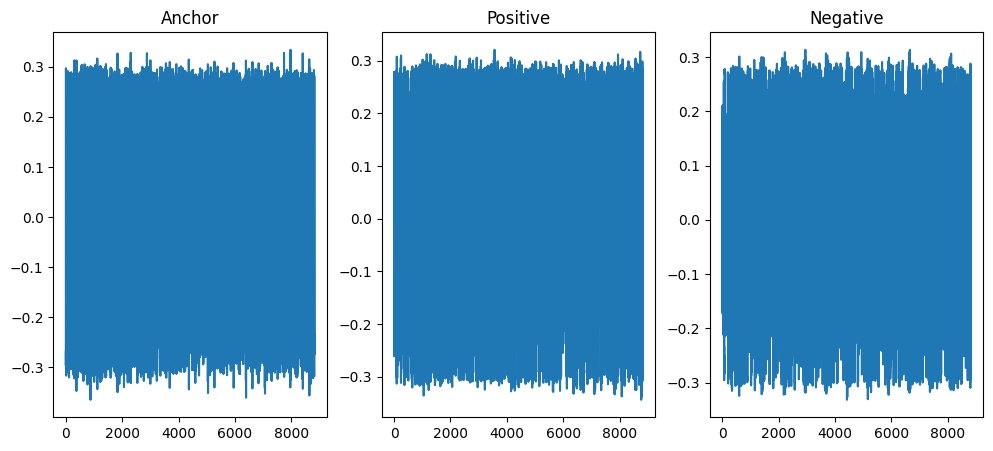

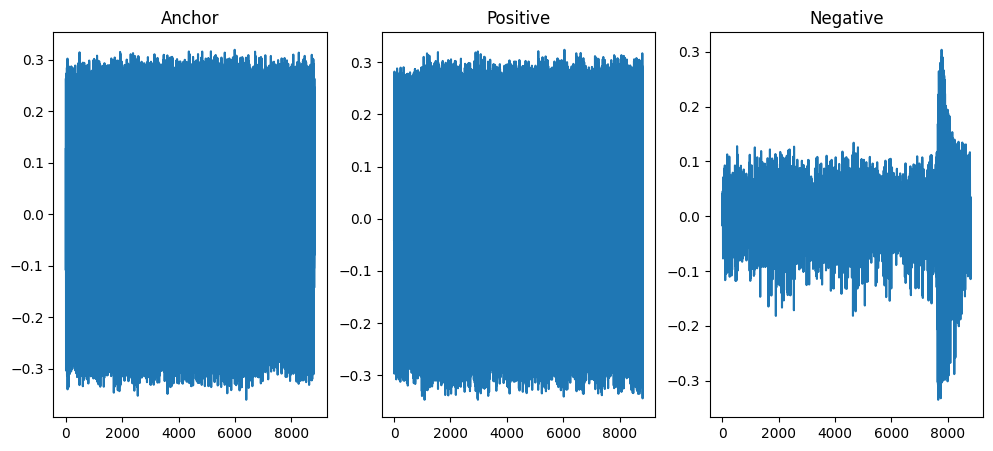

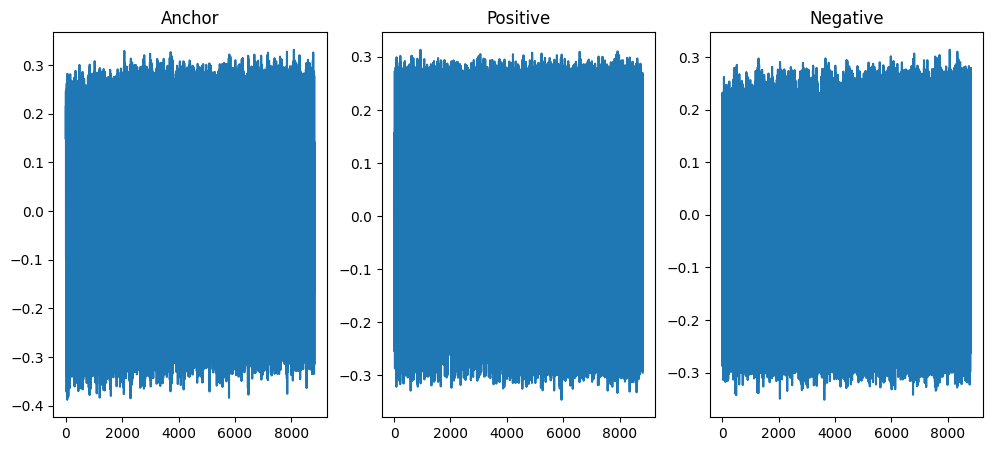

In [9]:
example_triplets = [next(batch_generator(train_triplets, 3))]
visualize_triplets(example_triplets[0])


# ***2. MODEL WDCNN***

In [10]:
def WDCNN(input_shape =(8820,1)):

    model = Sequential()

    # WDCNN
    model.add(Conv1D(filters=16, kernel_size=32, strides=16, activation='relu', padding='same',input_shape=input_shape))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'))
    model.add(MaxPooling1D(strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
    model.add(MaxPooling1D(strides=2))
    model.add(Flatten())
    model.add(Dense(100,activation='sigmoid'))
    return model


## ***2.1. DISTANCE LAYER***

In [12]:
@tf.keras.utils.register_keras_serializable()
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

input_shape = (8820, 1)

anchor_input = Input(name='anchor', shape=input_shape)
positive_input = Input(name='positive', shape=input_shape)
negative_input = Input(name='negative', shape=input_shape)

embedding = WDCNN()
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input)
)

siamese_net = Model(
    inputs=[anchor_input,
            positive_input,
            negative_input],
    outputs=distances
)

print(siamese_net.summary())


ValueError: Custom>DistanceLayer has already been registered to <class '__main__.DistanceLayer'>

# ***3. TRAIN MODEL***

In [13]:
@tf.keras.utils.register_keras_serializable()
class SiameseModel(Model):
    def __init__(self, siamese_net, margin=5):
        super().__init__()
        self.siamese_net = siamese_net
        self.margin = margin
        self.loss_tracker = Mean(name='loss')
        self.accuracy_tracker = Mean(name='accuracy')

    def call(self, inputs):
        return self.siamese_net(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_net.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_net.trainable_weights)
        )

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)

        accuracy = self._compute_accuracy(data)
        self.accuracy_tracker.update_state(accuracy)

        return {'loss': self.loss_tracker.result(),
                'accuracy': self.accuracy_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_net(data)

        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, .0)
        return loss

    def _compute_accuracy(self, data):
        ap_distance, an_distance = self.siamese_net(data)
        accuracy = tf.reduce_mean(tf.cast(ap_distance < an_distance,
                                          tf.float32))
        return accuracy

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    def get_config(self):
        base_config = super().get_config()
        config = {
            'siamese_net': tf.keras.saving.serialize_keras_object(self.siamese_net),
            'margin': tf.keras.saving.serialize_keras_object(self.margin),
            'loss_tracker': tf.keras.saving.serialize_keras_object(self.loss_tracker),
            'accuracy_tracker': tf.keras.saving.serialize_keras_object(self.accuracy_tracker),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        config['siamese_net'] = tf.keras.saving.deserialize_keras_object(config.pop('siamese_net'))
        config['margin'] = tf.keras.saving.deserialize_keras_object(config.pop('margin'))
        config['loss_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('loss_tracker'))
        config['accuracy_tracker'] = tf.keras.saving.deserialize_keras_object(config.pop('accuracy_tracker'))
        return cls(**config)


In [14]:
def train_model(model,
                train_triplets,
                epochs,
                batch_size,
                val_triplets,
                patience,
                delta=0.0001):

    best_val_accuracy = 0
    best_val_loss = float('inf')
    temp_patience = patience
    history = {
        'loss': [],
        'val_loss': [],
        'accuracy': [],
        'val_accuracy': []
    }

    train_steps_per_epoch = math.ceil(len(train_triplets) / batch_size)
    val_steps_per_epoch = math.ceil(len(val_triplets) / batch_size)

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        train_loss = 0.
        train_accuracy = 0.
        val_loss = 0.
        val_accuracy = 0.

        with tqdm(total=train_steps_per_epoch, desc='Training') as pbar:
            for batch in batch_generator(train_triplets, batch_size=batch_size):
                loss, accuracy = model.train_on_batch(batch)
                train_loss += loss
                train_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        with tqdm(total=val_steps_per_epoch, desc='Validation') as pbar:
            for batch in batch_generator(val_triplets, batch_size=batch_size):
                loss, accuracy = model.test_on_batch(batch)
                val_loss += loss
                val_accuracy += accuracy

                pbar.update()
                pbar.set_postfix({'Loss': loss, 'Accuracy': accuracy})

        train_loss /= train_steps_per_epoch
        train_accuracy /= train_steps_per_epoch
        val_loss /= val_steps_per_epoch
        val_accuracy /= val_steps_per_epoch

        history['loss'].append(train_loss)
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model.layers[0].layers[3].save_weights('best_model.weights.h5')

        if val_loss - best_val_loss > delta:
            temp_patience -= 1
            if temp_patience == 0:
                print('Early stopping: Validation loss did not improve.')
                break
        else:
            best_val_loss = val_loss
            temp_patience = patience

    return model, history


In [15]:
siamese_model = SiameseModel(siamese_net)
siamese_model.compile(optimizer=Adam(0.001))

siamese_model, history = train_model(siamese_model,
                                     train_triplets=train_triplets,
                                     epochs=50,
                                     batch_size=512,
                                     val_triplets=val_triplets,
                                     patience=5)


Epoch 1/50


Training:   0%|          | 0/22 [00:00<?, ?it/s]

Validation: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s, Loss=2.43, Accuracy=0.833]



Train Loss: 3.7716, Train Accuracy: 0.7930
Validation Loss: 2.1329, Validation Accuracy: 0.8691

Epoch 2/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s, Loss=1.06, Accuracy=0.917] 



Train Loss: 1.5333, Train Accuracy: 0.8999
Validation Loss: 0.9550, Validation Accuracy: 0.9246

Epoch 3/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s, Loss=0.188, Accuracy=0.981]



Train Loss: 0.6438, Train Accuracy: 0.9589
Validation Loss: 0.4072, Validation Accuracy: 0.9718

Epoch 4/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s, Loss=0.316, Accuracy=0.981]



Train Loss: 0.3775, Train Accuracy: 0.9782
Validation Loss: 0.3303, Validation Accuracy: 0.9816

Epoch 5/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s, Loss=0.189, Accuracy=0.981]



Train Loss: 0.2807, Train Accuracy: 0.9830
Validation Loss: 0.2283, Validation Accuracy: 0.9843

Epoch 6/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.14it/s, Loss=0.172, Accuracy=1]    



Train Loss: 0.2408, Train Accuracy: 0.9856
Validation Loss: 0.2013, Validation Accuracy: 0.9878

Epoch 7/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s, Loss=0.189, Accuracy=0.981]



Train Loss: 0.2267, Train Accuracy: 0.9869
Validation Loss: 0.2027, Validation Accuracy: 0.9877

Epoch 8/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s, Loss=0.372, Accuracy=0.972]



Train Loss: 0.2273, Train Accuracy: 0.9859
Validation Loss: 0.2409, Validation Accuracy: 0.9826

Epoch 9/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s, Loss=0.0889, Accuracy=1]    



Train Loss: 0.1979, Train Accuracy: 0.9859
Validation Loss: 0.1468, Validation Accuracy: 0.9905

Epoch 10/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s, Loss=0.26, Accuracy=0.981] 



Train Loss: 0.1547, Train Accuracy: 0.9893
Validation Loss: 0.2117, Validation Accuracy: 0.9857

Epoch 11/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s, Loss=0.259, Accuracy=0.991] 



Train Loss: 0.1743, Train Accuracy: 0.9882
Validation Loss: 0.1685, Validation Accuracy: 0.9886

Epoch 12/50


Validation: 100%|██████████| 8/8 [00:07<00:00,  1.14it/s, Loss=0, Accuracy=1]        



Train Loss: 0.1338, Train Accuracy: 0.9909
Validation Loss: 0.2441, Validation Accuracy: 0.9827

Epoch 13/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s, Loss=0.0503, Accuracy=1]    



Train Loss: 0.1445, Train Accuracy: 0.9897
Validation Loss: 0.1104, Validation Accuracy: 0.9917

Epoch 14/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s, Loss=0.0168, Accuracy=1]    



Train Loss: 0.1186, Train Accuracy: 0.9913
Validation Loss: 0.1054, Validation Accuracy: 0.9917

Epoch 15/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s, Loss=0.0425, Accuracy=1]    



Train Loss: 0.1250, Train Accuracy: 0.9913
Validation Loss: 0.1075, Validation Accuracy: 0.9912

Epoch 16/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s, Loss=0.0121, Accuracy=1]    



Train Loss: 0.0969, Train Accuracy: 0.9923
Validation Loss: 0.0949, Validation Accuracy: 0.9924

Epoch 17/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s, Loss=0.149, Accuracy=0.972] 



Train Loss: 0.1303, Train Accuracy: 0.9923
Validation Loss: 0.1309, Validation Accuracy: 0.9880

Epoch 18/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s, Loss=0.227, Accuracy=0.981] 



Train Loss: 0.0950, Train Accuracy: 0.9925
Validation Loss: 0.1210, Validation Accuracy: 0.9904

Epoch 19/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s, Loss=0.214, Accuracy=0.981] 



Train Loss: 0.0921, Train Accuracy: 0.9935
Validation Loss: 0.1426, Validation Accuracy: 0.9877

Epoch 20/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s, Loss=0, Accuracy=1]        



Train Loss: 0.0857, Train Accuracy: 0.9934
Validation Loss: 0.1111, Validation Accuracy: 0.9915

Epoch 21/50


Validation: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s, Loss=0.0738, Accuracy=1]    


Train Loss: 0.0943, Train Accuracy: 0.9933
Validation Loss: 0.0973, Validation Accuracy: 0.9924

Early stopping: Validation loss did not improve.


## ***3.1. TRAIN & VAL PROCESS***

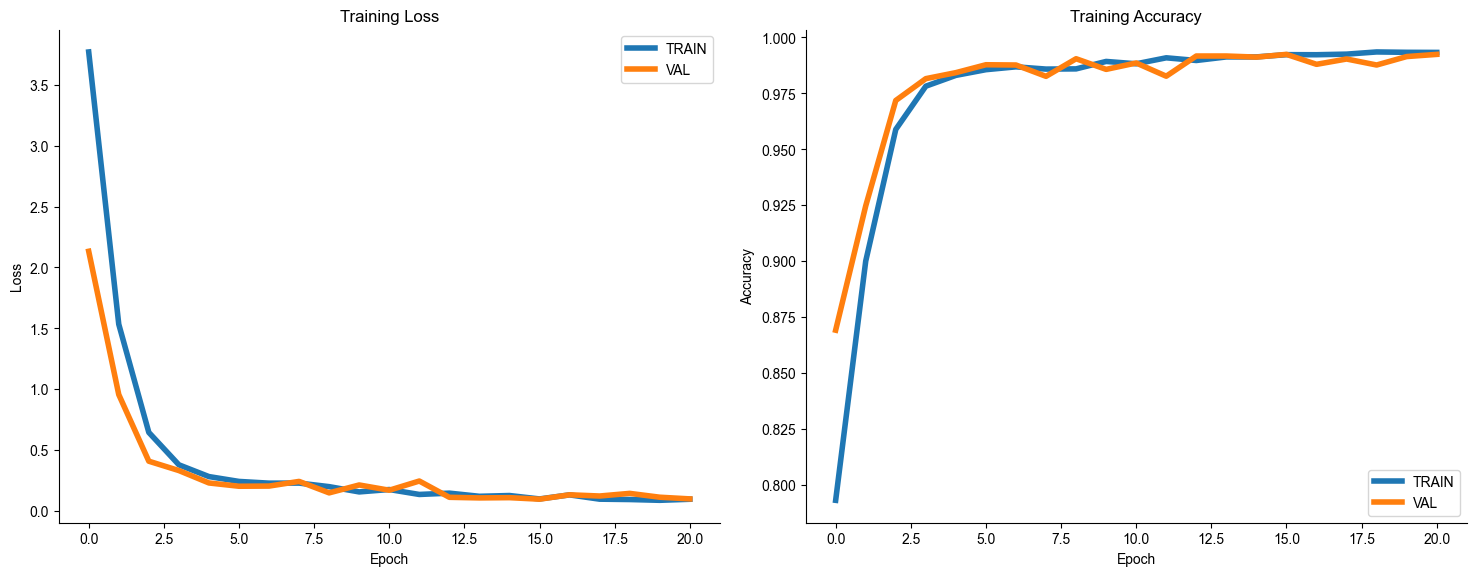

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


sns.lineplot(data=history, x=range(len(history['loss'])), y=history['loss'],
             ax=axes[0], label='TRAIN', color='tab:blue', linewidth=4)

sns.lineplot(data=history, x=range(len(history['val_loss'])),
             y=history['val_loss'], ax=axes[0], label='VAL', color='tab:orange', linewidth=4)
axes[0].set_title('Training Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper right')


sns.lineplot(data=history, x=range(len(history['accuracy'])), y=history['accuracy'],
             ax=axes[1], label='TRAIN', color='tab:blue', linewidth=4)
sns.lineplot(data=history, x=range(len(history['val_accuracy'])),
             y=history['val_accuracy'], ax=axes[1], label='VAL', color='tab:orange', linewidth=4)
axes[1].set_title('Training Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='lower right')

sns.set(style="whitegrid")
sns.despine()
sns.set_context("notebook", font_scale=1.2)


plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.color'] = 'white'


plt.tight_layout()
plt.show()
plt.close()


# ***4. RESULT***

In [17]:
def sum_loss(embA, embB):
    return np.sum(abs(embA - embB))


In [20]:
sample = next(batch_generator(val_triplets, 1))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative)
)
dis_pos, dis_neg = siamese_model.predict([anchor, positive, negative])
print(f"Distance by model:\nPositive: {dis_pos[0]}, Negative: {dis_neg[0]}")


print(f"\nSum loss positive: {sum_loss(anchor_embedding, positive_embedding)}")
print(f"\nSum loss negative: {sum_loss(anchor_embedding, negative_embedding)}")

print(f"Sum loss positive & negative: {sum_loss(positive_embedding, negative_embedding)}")
for s in sample:
    play_sound(s)


1/1 [==============================] - 0s 12ms/step
Distance by model:
Positive: 0.41507473587989807, Negative: 67.3751449584961

Sum loss positive: 2.4069771766662598

Sum loss negative: 70.5005874633789
Sum loss positive & negative: 68.1623764038086


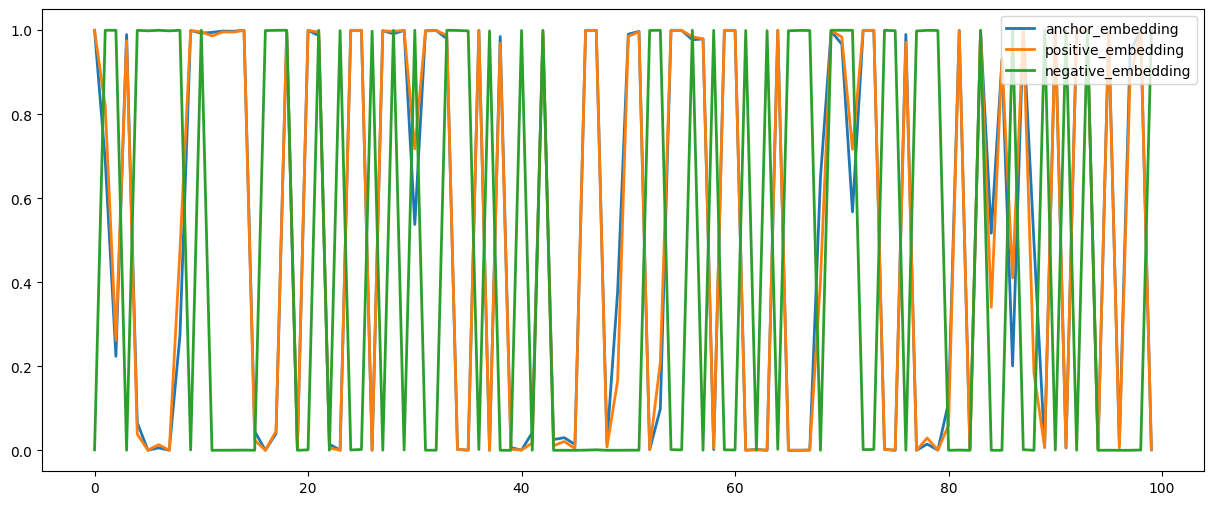

In [21]:
sns.reset_defaults()
embs = [anchor_embedding, positive_embedding, negative_embedding]
labels = ['anchor_embedding', 'positive_embedding', 'negative_embedding']
plt.subplots(figsize=(15, 6))
plt.rcParams['lines.linewidth'] = 2
for emb, label in zip(embs, labels):
    plt.plot(emb[0, :], label=label)
plt.legend(loc='upper right')
plt.show()


## ***4.1. DISTANCE DISTRIBUTION VISUALIZE***

In [22]:
def sumloss_visualize(type_triplets, type_name, threshold=None):
    pos_loss = []
    neg_loss = []

    for _ in tqdm(type_triplets):
        sample = next(batch_generator(type_triplets, 1))

        anchor, positive, negative = sample
        dis_pos, dis_neg = siamese_model.predict([anchor, positive, negative])

    # Lưu các giá trị sum loss vào một list để vẽ biểu đồ histogram
        pos_loss.append(dis_pos[0])
        neg_loss.append(dis_neg[0])



    fig = plt.figure(figsize=(15,10))
    axes = fig.subplot_mosaic("""AB
                                CC
                                """)

    plt.title('Distribution of Sum Loss')
    plt.xlabel(f'Sum Loss {type_name.title()}')
    plt.ylabel('Number of samples')

    sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["A"], color='blue');

    axes["A"].legend(loc='upper right')

    sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["B"], color='red');

    axes["B"].legend(loc='upper right')

    sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["C"],  color='blue')
    sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["C"],  color='red')

    axes["C"].legend(loc='upper right')

    if threshold is not None:
        axes["A"].axvline(x=threshold, color='r', linestyle='--')
        axes["B"].axvline(x=threshold, color='r', linestyle='--')
        axes["C"].axvline(x=threshold, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()
    return pos_loss, neg_loss


  0%|          | 0/11189 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 3/11189 [00:00<07:41, 24.26it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 6/11189 [00:00<07:09, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 9/11189 [00:00<06:51, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 12/11189 [00:00<06:50, 27.21it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 15/11189 [00:00<06:48, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 18/11189 [00:00<06:47, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 21/11189 [00:00<06:47, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 24/11189 [00:00<06:41, 27.83it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 27/11189 [00:00<06:54, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 30/11189 [00:01<07:00, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 33/11189 [00:01<07:00, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 36/11189 [00:01<06:56, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 39/11189 [00:01<06:57, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 42/11189 [00:01<06:51, 27.09it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 45/11189 [00:01<06:50, 27.13it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 48/11189 [00:01<07:01, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 51/11189 [00:01<06:54, 26.87it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 54/11189 [00:02<07:03, 26.27it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 57/11189 [00:02<07:04, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 60/11189 [00:02<06:56, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 63/11189 [00:02<06:56, 26.72it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 66/11189 [00:02<06:53, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 69/11189 [00:02<06:51, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 72/11189 [00:02<06:53, 26.89it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 75/11189 [00:02<06:53, 26.88it/s]

1/1 [==============================] - 0s 11ms/step


  1%|          | 78/11189 [00:02<06:55, 26.73it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 81/11189 [00:03<06:56, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 84/11189 [00:03<06:59, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 87/11189 [00:03<07:00, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 90/11189 [00:03<06:51, 26.95it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 93/11189 [00:03<06:49, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 96/11189 [00:03<06:46, 27.26it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 99/11189 [00:03<06:51, 26.96it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 102/11189 [00:03<07:09, 25.81it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 105/11189 [00:03<07:01, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 108/11189 [00:04<07:11, 25.68it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 111/11189 [00:04<07:06, 25.99it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 114/11189 [00:04<06:55, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 117/11189 [00:04<06:56, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 120/11189 [00:04<06:47, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 123/11189 [00:04<06:44, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 126/11189 [00:04<06:46, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 129/11189 [00:04<06:51, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 132/11189 [00:04<06:48, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 135/11189 [00:05<06:54, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 138/11189 [00:05<06:51, 26.85it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏         | 141/11189 [00:05<07:10, 25.67it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏         | 144/11189 [00:05<07:01, 26.19it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 147/11189 [00:05<06:52, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 150/11189 [00:05<06:55, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 153/11189 [00:05<07:01, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 156/11189 [00:05<06:54, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 159/11189 [00:05<06:50, 26.86it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏         | 162/11189 [00:06<06:47, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 165/11189 [00:06<06:50, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 168/11189 [00:06<06:52, 26.70it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 171/11189 [00:06<06:45, 27.17it/s]

1/1 [==============================] - 0s 11ms/step


  2%|▏         | 174/11189 [00:06<06:48, 26.93it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 177/11189 [00:06<06:54, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 180/11189 [00:06<06:50, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 183/11189 [00:06<06:57, 26.38it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 186/11189 [00:06<06:47, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 189/11189 [00:07<06:48, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 192/11189 [00:07<06:43, 27.28it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 195/11189 [00:07<06:44, 27.19it/s]

1/1 [==============================] - 0s 11ms/step


  2%|▏         | 198/11189 [00:07<06:45, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 201/11189 [00:07<06:40, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 204/11189 [00:07<06:45, 27.06it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 207/11189 [00:07<06:50, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 210/11189 [00:07<06:56, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 213/11189 [00:07<07:20, 24.92it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 216/11189 [00:08<07:17, 25.09it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 219/11189 [00:08<07:02, 25.96it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 222/11189 [00:08<07:00, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 225/11189 [00:08<06:53, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 228/11189 [00:08<06:47, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 231/11189 [00:08<06:45, 26.99it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 234/11189 [00:08<06:43, 27.14it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 237/11189 [00:08<06:46, 26.95it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 240/11189 [00:08<06:49, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 243/11189 [00:09<06:45, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 246/11189 [00:09<06:40, 27.31it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 249/11189 [00:09<06:56, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 252/11189 [00:09<06:49, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 255/11189 [00:09<06:52, 26.50it/s]

1/1 [==============================] - 0s 11ms/step


  2%|▏         | 258/11189 [00:09<06:50, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 261/11189 [00:09<06:48, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 264/11189 [00:09<06:56, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 267/11189 [00:10<07:04, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 270/11189 [00:10<06:56, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 273/11189 [00:10<06:49, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 276/11189 [00:10<06:45, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 279/11189 [00:10<06:46, 26.86it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 282/11189 [00:10<06:42, 27.12it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 285/11189 [00:10<06:57, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 288/11189 [00:10<06:49, 26.62it/s]

1/1 [==============================] - 0s 11ms/step


  3%|▎         | 291/11189 [00:10<06:49, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 294/11189 [00:11<06:57, 26.12it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 297/11189 [00:11<06:46, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


  3%|▎         | 300/11189 [00:11<06:50, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 303/11189 [00:11<06:47, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 306/11189 [00:11<06:46, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 309/11189 [00:11<06:44, 26.93it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 312/11189 [00:11<06:50, 26.52it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 315/11189 [00:11<06:57, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 318/11189 [00:11<06:57, 26.05it/s]

1/1 [==============================] - 0s 11ms/step


  3%|▎         | 321/11189 [00:12<07:09, 25.33it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 324/11189 [00:12<07:02, 25.74it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 327/11189 [00:12<07:01, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 330/11189 [00:12<06:52, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 333/11189 [00:12<06:52, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


  3%|▎         | 336/11189 [00:12<06:45, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


  3%|▎         | 339/11189 [00:12<06:42, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 342/11189 [00:12<06:37, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 345/11189 [00:12<06:37, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 348/11189 [00:13<06:37, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 351/11189 [00:13<06:35, 27.40it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 354/11189 [00:13<06:34, 27.50it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 357/11189 [00:13<06:57, 25.96it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 360/11189 [00:13<06:43, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 363/11189 [00:13<06:39, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 366/11189 [00:13<06:36, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 369/11189 [00:13<06:43, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 372/11189 [00:13<06:42, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 375/11189 [00:14<06:41, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 378/11189 [00:14<06:43, 26.79it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 381/11189 [00:14<06:46, 26.57it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 384/11189 [00:14<06:51, 26.27it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 387/11189 [00:14<06:45, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 390/11189 [00:14<06:58, 25.79it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 393/11189 [00:14<07:04, 25.41it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 396/11189 [00:14<06:57, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 399/11189 [00:14<06:59, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▎         | 402/11189 [00:15<06:58, 25.76it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 405/11189 [00:15<07:04, 25.42it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 408/11189 [00:15<06:58, 25.74it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▎         | 411/11189 [00:15<06:53, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 414/11189 [00:15<06:52, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


  4%|▎         | 417/11189 [00:15<07:00, 25.63it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 420/11189 [00:15<06:51, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 423/11189 [00:15<06:52, 26.13it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 426/11189 [00:16<07:04, 25.35it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 429/11189 [00:16<07:06, 25.23it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 432/11189 [00:16<06:57, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 435/11189 [00:16<06:53, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 438/11189 [00:16<06:52, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 441/11189 [00:16<06:52, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 444/11189 [00:16<06:58, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 447/11189 [00:16<06:54, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 450/11189 [00:16<06:49, 26.22it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 453/11189 [00:17<06:52, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 456/11189 [00:17<06:48, 26.25it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 459/11189 [00:17<06:51, 26.05it/s]

1/1 [==============================] - 0s 11ms/step


  4%|▍         | 462/11189 [00:17<07:02, 25.36it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 465/11189 [00:17<07:01, 25.44it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 468/11189 [00:17<06:54, 25.89it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 471/11189 [00:17<06:48, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 474/11189 [00:17<06:52, 25.99it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 477/11189 [00:18<07:05, 25.16it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 480/11189 [00:18<07:01, 25.39it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 483/11189 [00:18<06:50, 26.05it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 486/11189 [00:18<06:49, 26.12it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 489/11189 [00:18<06:40, 26.73it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 492/11189 [00:18<06:43, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 495/11189 [00:18<07:00, 25.45it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 498/11189 [00:18<06:50, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


  4%|▍         | 501/11189 [00:18<06:48, 26.15it/s]

1/1 [==============================] - 0s 11ms/step


  5%|▍         | 504/11189 [00:19<06:47, 26.19it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 507/11189 [00:19<06:38, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 510/11189 [00:19<06:39, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


  5%|▍         | 513/11189 [00:19<06:39, 26.73it/s]

1/1 [==============================] - 0s 11ms/step


  5%|▍         | 516/11189 [00:19<06:42, 26.49it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 519/11189 [00:19<06:57, 25.55it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 522/11189 [00:19<06:56, 25.60it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 525/11189 [00:19<06:59, 25.41it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 528/11189 [00:19<07:04, 25.09it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 531/11189 [00:20<06:56, 25.57it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 534/11189 [00:20<06:46, 26.18it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 537/11189 [00:20<06:40, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 540/11189 [00:20<06:44, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 543/11189 [00:20<06:44, 26.34it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 546/11189 [00:20<06:48, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 549/11189 [00:20<06:56, 25.52it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 552/11189 [00:20<06:51, 25.84it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 555/11189 [00:21<06:52, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 558/11189 [00:21<06:52, 25.79it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 561/11189 [00:21<07:04, 25.06it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 564/11189 [00:21<06:54, 25.61it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 567/11189 [00:21<06:52, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 570/11189 [00:21<06:52, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 573/11189 [00:21<06:59, 25.30it/s]

1/1 [==============================] - 0s 11ms/step


  5%|▌         | 576/11189 [00:21<06:55, 25.55it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 579/11189 [00:21<06:56, 25.50it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 582/11189 [00:22<06:52, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 585/11189 [00:22<06:42, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 588/11189 [00:22<06:46, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 591/11189 [00:22<06:43, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 594/11189 [00:22<06:52, 25.67it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 597/11189 [00:22<06:48, 25.95it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 600/11189 [00:22<06:49, 25.85it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 603/11189 [00:22<06:52, 25.65it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 606/11189 [00:22<06:51, 25.70it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 609/11189 [00:23<06:48, 25.87it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 612/11189 [00:23<06:45, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 615/11189 [00:23<06:45, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 618/11189 [00:23<06:45, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 621/11189 [00:23<06:50, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 624/11189 [00:23<06:44, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 627/11189 [00:23<06:54, 25.50it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 630/11189 [00:23<06:47, 25.93it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 633/11189 [00:24<06:51, 25.63it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 636/11189 [00:24<06:41, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 639/11189 [00:24<06:36, 26.62it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 642/11189 [00:24<06:46, 25.97it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 645/11189 [00:24<06:55, 25.40it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 648/11189 [00:24<09:08, 19.22it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 651/11189 [00:24<08:20, 21.04it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 654/11189 [00:24<07:53, 22.23it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 657/11189 [00:25<07:27, 23.53it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 660/11189 [00:25<07:26, 23.61it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 663/11189 [00:25<07:16, 24.12it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 666/11189 [00:25<07:10, 24.46it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 669/11189 [00:25<06:56, 25.23it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 672/11189 [00:25<07:01, 24.96it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 675/11189 [00:25<06:53, 25.41it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 678/11189 [00:25<06:51, 25.54it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 681/11189 [00:26<06:55, 25.30it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 684/11189 [00:26<06:51, 25.56it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 687/11189 [00:26<06:45, 25.90it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 690/11189 [00:26<06:46, 25.82it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 693/11189 [00:26<07:02, 24.86it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 696/11189 [00:26<06:57, 25.15it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 699/11189 [00:26<06:54, 25.33it/s]

1/1 [==============================] - 0s 11ms/step


  6%|▋         | 702/11189 [00:26<06:57, 25.14it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▋         | 705/11189 [00:26<06:52, 25.41it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▋         | 708/11189 [00:27<06:47, 25.73it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▋         | 711/11189 [00:27<06:39, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▋         | 714/11189 [00:27<06:44, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▋         | 717/11189 [00:27<06:52, 25.36it/s]

1/1 [==============================] - 0s 11ms/step


  6%|▋         | 720/11189 [00:27<06:43, 25.93it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 723/11189 [00:27<06:51, 25.44it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▋         | 726/11189 [00:27<07:01, 24.80it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 729/11189 [00:27<06:57, 25.07it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 732/11189 [00:28<06:55, 25.17it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 735/11189 [00:28<06:57, 25.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 738/11189 [00:28<06:51, 25.38it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 741/11189 [00:28<06:59, 24.88it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 744/11189 [00:28<06:59, 24.91it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 747/11189 [00:28<06:54, 25.18it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 750/11189 [00:28<06:55, 25.15it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 753/11189 [00:28<06:44, 25.81it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 756/11189 [00:28<06:45, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 759/11189 [00:29<06:44, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 762/11189 [00:29<06:38, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 765/11189 [00:29<06:31, 26.61it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 768/11189 [00:29<06:25, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 771/11189 [00:29<06:18, 27.52it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 774/11189 [00:29<06:19, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 777/11189 [00:29<06:17, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 780/11189 [00:29<06:18, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 783/11189 [00:29<06:26, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 786/11189 [00:30<06:20, 27.31it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 789/11189 [00:30<06:33, 26.43it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 792/11189 [00:30<06:25, 26.95it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 795/11189 [00:30<06:18, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 798/11189 [00:30<06:14, 27.71it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 801/11189 [00:30<06:14, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 804/11189 [00:30<06:13, 27.80it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 807/11189 [00:30<06:12, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 810/11189 [00:30<06:14, 27.74it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 813/11189 [00:31<06:15, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 816/11189 [00:31<06:30, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 819/11189 [00:31<06:31, 26.50it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 822/11189 [00:31<06:25, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 825/11189 [00:31<06:15, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 828/11189 [00:31<06:18, 27.39it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 831/11189 [00:31<06:19, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


  7%|▋         | 834/11189 [00:31<06:16, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 837/11189 [00:31<06:14, 27.64it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 840/11189 [00:32<06:18, 27.33it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 843/11189 [00:32<06:24, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 846/11189 [00:32<06:23, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 849/11189 [00:32<06:22, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 852/11189 [00:32<06:18, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 855/11189 [00:32<06:15, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 858/11189 [00:32<06:18, 27.29it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 861/11189 [00:32<06:14, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 864/11189 [00:32<06:25, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 867/11189 [00:33<06:25, 26.80it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 870/11189 [00:33<06:24, 26.83it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 873/11189 [00:33<06:25, 26.73it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 876/11189 [00:33<06:23, 26.91it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 879/11189 [00:33<06:23, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 882/11189 [00:33<06:16, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 885/11189 [00:33<06:16, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 888/11189 [00:33<06:17, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 891/11189 [00:33<06:11, 27.71it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 894/11189 [00:34<06:11, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 897/11189 [00:34<06:09, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 900/11189 [00:34<06:11, 27.68it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 903/11189 [00:34<06:15, 27.36it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 906/11189 [00:34<06:11, 27.70it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 909/11189 [00:34<06:27, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 912/11189 [00:34<06:25, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 915/11189 [00:34<06:18, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 918/11189 [00:34<06:15, 27.37it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 921/11189 [00:35<06:10, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 924/11189 [00:35<06:04, 28.15it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 927/11189 [00:35<06:04, 28.18it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 930/11189 [00:35<06:01, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 933/11189 [00:35<06:04, 28.17it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 936/11189 [00:35<06:11, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 939/11189 [00:35<06:05, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 942/11189 [00:35<06:03, 28.16it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 945/11189 [00:35<06:00, 28.44it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 948/11189 [00:35<06:02, 28.23it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 951/11189 [00:36<06:16, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▊         | 954/11189 [00:36<06:09, 27.68it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 957/11189 [00:36<06:10, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 960/11189 [00:36<06:10, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▊         | 963/11189 [00:36<06:12, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 966/11189 [00:36<06:12, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▊         | 969/11189 [00:36<06:06, 27.87it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 972/11189 [00:36<06:10, 27.60it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 975/11189 [00:36<06:16, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▊         | 978/11189 [00:37<06:21, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 981/11189 [00:37<06:13, 27.33it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 984/11189 [00:37<06:06, 27.84it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▉         | 987/11189 [00:37<06:08, 27.66it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 990/11189 [00:37<06:03, 28.07it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 993/11189 [00:37<06:10, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 996/11189 [00:37<06:21, 26.69it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 999/11189 [00:37<06:20, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1002/11189 [00:37<06:13, 27.28it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1005/11189 [00:38<06:17, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1008/11189 [00:38<06:14, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1011/11189 [00:38<06:11, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1014/11189 [00:38<06:11, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1017/11189 [00:38<06:16, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1020/11189 [00:38<06:06, 27.74it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1023/11189 [00:38<06:10, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1026/11189 [00:38<06:18, 26.86it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▉         | 1029/11189 [00:38<06:24, 26.44it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 1032/11189 [00:39<06:20, 26.71it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 1035/11189 [00:39<06:18, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 1038/11189 [00:39<06:19, 26.72it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▉         | 1041/11189 [00:39<06:12, 27.23it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 1044/11189 [00:39<06:20, 26.63it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1047/11189 [00:39<06:16, 26.96it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 1050/11189 [00:39<06:09, 27.45it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 1053/11189 [00:39<06:07, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1056/11189 [00:39<06:06, 27.65it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 1059/11189 [00:40<06:11, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 1062/11189 [00:40<06:03, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1065/11189 [00:40<05:58, 28.23it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1068/11189 [00:40<06:01, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1071/11189 [00:40<06:05, 27.67it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1074/11189 [00:40<06:05, 27.69it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1077/11189 [00:40<05:59, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1080/11189 [00:40<06:01, 27.98it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1083/11189 [00:40<06:07, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1086/11189 [00:41<06:08, 27.44it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 1089/11189 [00:41<06:13, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1092/11189 [00:41<06:11, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1095/11189 [00:41<06:15, 26.86it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1098/11189 [00:41<06:08, 27.37it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1101/11189 [00:41<06:08, 27.41it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1104/11189 [00:41<06:05, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1107/11189 [00:41<05:58, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 1110/11189 [00:41<06:17, 26.72it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1113/11189 [00:42<06:15, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 1116/11189 [00:42<06:14, 26.93it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1119/11189 [00:42<06:09, 27.24it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1122/11189 [00:42<06:01, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1125/11189 [00:42<06:00, 27.93it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1128/11189 [00:42<06:02, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1131/11189 [00:42<06:03, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1134/11189 [00:42<06:18, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1137/11189 [00:42<06:08, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1140/11189 [00:42<06:06, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1143/11189 [00:43<06:12, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1146/11189 [00:43<06:10, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1149/11189 [00:43<06:15, 26.76it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 1152/11189 [00:43<06:09, 27.19it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1155/11189 [00:43<06:01, 27.73it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1158/11189 [00:43<06:08, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1161/11189 [00:43<06:12, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1164/11189 [00:43<06:06, 27.36it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1167/11189 [00:44<06:18, 26.46it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 1170/11189 [00:44<06:19, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 1173/11189 [00:44<06:10, 27.01it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█         | 1176/11189 [00:44<06:21, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1179/11189 [00:44<06:17, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1182/11189 [00:44<06:11, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1185/11189 [00:44<06:04, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1188/11189 [00:44<06:06, 27.25it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1191/11189 [00:44<06:02, 27.55it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█         | 1194/11189 [00:44<05:59, 27.83it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1197/11189 [00:45<05:58, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1200/11189 [00:45<06:15, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1203/11189 [00:45<06:11, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1206/11189 [00:45<06:07, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1209/11189 [00:45<06:00, 27.70it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1212/11189 [00:45<05:55, 28.10it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█         | 1215/11189 [00:45<05:50, 28.48it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1218/11189 [00:45<05:51, 28.34it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1221/11189 [00:45<05:54, 28.15it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1224/11189 [00:46<06:02, 27.45it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█         | 1227/11189 [00:46<06:01, 27.55it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 1230/11189 [00:46<06:18, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1233/11189 [00:46<06:05, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1236/11189 [00:46<06:10, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1239/11189 [00:46<06:14, 26.55it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1242/11189 [00:46<06:18, 26.26it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1245/11189 [00:46<06:21, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1248/11189 [00:46<06:24, 25.88it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 1251/11189 [00:47<06:15, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1254/11189 [00:47<06:14, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 1257/11189 [00:47<06:17, 26.31it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█▏        | 1260/11189 [00:47<06:09, 26.90it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█▏        | 1263/11189 [00:47<06:21, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 1266/11189 [00:47<06:10, 26.79it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█▏        | 1269/11189 [00:47<06:07, 26.96it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█▏        | 1272/11189 [00:47<06:06, 27.04it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█▏        | 1275/11189 [00:47<06:09, 26.81it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 1278/11189 [00:48<06:04, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 1281/11189 [00:48<05:57, 27.70it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 1284/11189 [00:48<05:51, 28.18it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1287/11189 [00:48<05:53, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1290/11189 [00:48<05:54, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1293/11189 [00:48<06:02, 27.28it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1296/11189 [00:48<06:02, 27.27it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 1299/11189 [00:48<06:04, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1302/11189 [00:48<06:08, 26.82it/s]

1/1 [==============================] - 0s 10ms/step


 12%|█▏        | 1305/11189 [00:49<06:09, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1308/11189 [00:49<06:04, 27.10it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1311/11189 [00:49<06:13, 26.42it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 1314/11189 [00:49<06:11, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1317/11189 [00:49<06:14, 26.36it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1320/11189 [00:49<06:12, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1323/11189 [00:49<06:13, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1326/11189 [00:49<06:05, 26.95it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1329/11189 [00:49<06:00, 27.35it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1332/11189 [00:50<05:57, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1335/11189 [00:50<05:59, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1338/11189 [00:50<05:56, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1341/11189 [00:50<05:57, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1344/11189 [00:50<05:55, 27.70it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 1347/11189 [00:50<05:57, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1350/11189 [00:50<05:56, 27.61it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1353/11189 [00:50<06:01, 27.20it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 1356/11189 [00:50<06:00, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1359/11189 [00:51<05:58, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1362/11189 [00:51<05:54, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1365/11189 [00:51<05:48, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1368/11189 [00:51<05:50, 28.04it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 1371/11189 [00:51<05:50, 28.04it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1374/11189 [00:51<06:06, 26.76it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1377/11189 [00:51<06:00, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1380/11189 [00:51<05:54, 27.66it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1383/11189 [00:51<05:59, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1386/11189 [00:52<05:59, 27.28it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1389/11189 [00:52<05:53, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1392/11189 [00:52<05:50, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 1395/11189 [00:52<05:46, 28.25it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 1398/11189 [00:52<05:46, 28.27it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1401/11189 [00:52<05:40, 28.75it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1404/11189 [00:52<05:36, 29.10it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1407/11189 [00:52<05:39, 28.84it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1410/11189 [00:52<05:45, 28.34it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1413/11189 [00:53<06:04, 26.80it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 1416/11189 [00:53<06:00, 27.12it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 1419/11189 [00:53<05:59, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1422/11189 [00:53<05:56, 27.40it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1425/11189 [00:53<05:59, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1428/11189 [00:53<05:54, 27.50it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1431/11189 [00:53<05:52, 27.64it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1434/11189 [00:53<05:47, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1437/11189 [00:53<05:45, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1440/11189 [00:53<05:54, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1443/11189 [00:54<05:57, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1446/11189 [00:54<05:52, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1449/11189 [00:54<05:51, 27.73it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1452/11189 [00:54<05:48, 27.97it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1455/11189 [00:54<05:51, 27.67it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1458/11189 [00:54<05:46, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1461/11189 [00:54<05:45, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1464/11189 [00:54<05:46, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1467/11189 [00:54<05:48, 27.91it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1470/11189 [00:55<05:49, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1473/11189 [00:55<06:05, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1476/11189 [00:55<05:58, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1479/11189 [00:55<05:58, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1482/11189 [00:55<05:48, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1486/11189 [00:55<05:41, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1489/11189 [00:55<05:40, 28.45it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1492/11189 [00:55<05:43, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 1495/11189 [00:55<05:51, 27.57it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1498/11189 [00:56<05:52, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 1501/11189 [00:56<05:53, 27.43it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 1504/11189 [00:56<06:07, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 1507/11189 [00:56<06:05, 26.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 1510/11189 [00:56<06:03, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 1513/11189 [00:56<05:52, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 1516/11189 [00:56<05:47, 27.85it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▎        | 1519/11189 [00:56<05:48, 27.74it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▎        | 1522/11189 [00:56<05:49, 27.67it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▎        | 1525/11189 [00:57<05:51, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 1528/11189 [00:57<08:01, 20.06it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 1531/11189 [00:57<07:28, 21.55it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 1534/11189 [00:57<07:13, 22.27it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 1537/11189 [00:57<06:51, 23.47it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1540/11189 [00:57<06:34, 24.45it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1543/11189 [00:57<06:23, 25.17it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1546/11189 [00:57<06:06, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1549/11189 [00:58<05:59, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1552/11189 [00:58<05:55, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1555/11189 [00:58<05:45, 27.92it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1558/11189 [00:58<05:43, 28.03it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1561/11189 [00:58<05:48, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1564/11189 [00:58<05:55, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1567/11189 [00:58<05:58, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1570/11189 [00:58<05:53, 27.17it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 1573/11189 [00:58<05:50, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1576/11189 [00:59<05:53, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1579/11189 [00:59<05:52, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1582/11189 [00:59<05:47, 27.63it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 1585/11189 [00:59<05:45, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1588/11189 [00:59<05:39, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1591/11189 [00:59<05:51, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1594/11189 [00:59<05:46, 27.67it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 1597/11189 [00:59<05:42, 28.00it/s]

1/1 [==============================] - 0s 11ms/step


 14%|█▍        | 1600/11189 [00:59<05:48, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1603/11189 [01:00<05:53, 27.15it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 1606/11189 [01:00<05:50, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1609/11189 [01:00<05:51, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1612/11189 [01:00<05:46, 27.68it/s]

1/1 [==============================] - 0s 10ms/step


 14%|█▍        | 1615/11189 [01:00<05:47, 27.58it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1618/11189 [01:00<06:03, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 1621/11189 [01:00<05:53, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1624/11189 [01:00<05:59, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1627/11189 [01:00<05:57, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1630/11189 [01:01<06:04, 26.21it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▍        | 1633/11189 [01:01<05:55, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1636/11189 [01:01<05:58, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1639/11189 [01:01<05:58, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1643/11189 [01:01<05:42, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1646/11189 [01:01<05:40, 28.01it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 1649/11189 [01:01<05:59, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1652/11189 [01:01<05:55, 26.79it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▍        | 1655/11189 [01:01<05:56, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1658/11189 [01:02<05:49, 27.25it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▍        | 1661/11189 [01:02<05:48, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1664/11189 [01:02<05:48, 27.29it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 1667/11189 [01:02<05:50, 27.20it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 1670/11189 [01:02<05:46, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1673/11189 [01:02<05:46, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 1676/11189 [01:02<05:56, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1679/11189 [01:02<05:48, 27.27it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 1682/11189 [01:02<05:44, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1685/11189 [01:03<05:43, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 1688/11189 [01:03<05:43, 27.63it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 1691/11189 [01:03<05:42, 27.70it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 1694/11189 [01:03<05:37, 28.10it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1697/11189 [01:03<05:43, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1700/11189 [01:03<05:39, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1703/11189 [01:03<05:47, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1706/11189 [01:03<05:42, 27.68it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 1709/11189 [01:03<05:46, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1712/11189 [01:04<05:50, 27.08it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 1715/11189 [01:04<05:45, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1718/11189 [01:04<05:47, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1721/11189 [01:04<05:46, 27.30it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 1724/11189 [01:04<05:41, 27.72it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 1727/11189 [01:04<05:38, 27.96it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 1730/11189 [01:04<05:48, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 1733/11189 [01:04<05:48, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1736/11189 [01:04<05:42, 27.64it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1739/11189 [01:05<05:38, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1742/11189 [01:05<05:34, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1745/11189 [01:05<05:35, 28.18it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1748/11189 [01:05<05:40, 27.73it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1751/11189 [01:05<05:43, 27.51it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1754/11189 [01:05<05:39, 27.80it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1757/11189 [01:05<05:54, 26.64it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1760/11189 [01:05<05:49, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1763/11189 [01:05<05:47, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1766/11189 [01:06<05:51, 26.79it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1769/11189 [01:06<05:50, 26.86it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1772/11189 [01:06<05:51, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1775/11189 [01:06<05:44, 27.31it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1778/11189 [01:06<05:37, 27.90it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 1781/11189 [01:06<05:39, 27.70it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1784/11189 [01:06<05:53, 26.64it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1787/11189 [01:06<05:52, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1790/11189 [01:06<05:44, 27.28it/s]

1/1 [==============================] - 0s 10ms/step


 16%|█▌        | 1793/11189 [01:07<05:45, 27.19it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1796/11189 [01:07<05:41, 27.50it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1799/11189 [01:07<05:41, 27.50it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1802/11189 [01:07<05:34, 28.03it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1805/11189 [01:07<05:34, 28.02it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1808/11189 [01:07<05:37, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 1811/11189 [01:07<05:49, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1814/11189 [01:07<05:46, 27.05it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 1817/11189 [01:07<05:42, 27.33it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 1820/11189 [01:08<05:39, 27.59it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▋        | 1823/11189 [01:08<05:38, 27.63it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▋        | 1826/11189 [01:08<05:45, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 1829/11189 [01:08<05:43, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▋        | 1832/11189 [01:08<05:48, 26.82it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1835/11189 [01:08<05:59, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 1838/11189 [01:08<05:52, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 1841/11189 [01:08<05:47, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 1844/11189 [01:08<05:54, 26.37it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1847/11189 [01:09<06:00, 25.94it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1850/11189 [01:09<05:58, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1853/11189 [01:09<05:50, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1856/11189 [01:09<05:46, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1859/11189 [01:09<05:46, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1862/11189 [01:09<05:52, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1865/11189 [01:09<05:46, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1868/11189 [01:09<05:50, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1871/11189 [01:09<05:51, 26.51it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1874/11189 [01:10<05:39, 27.45it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1877/11189 [01:10<05:35, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1880/11189 [01:10<05:34, 27.82it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 1883/11189 [01:10<05:32, 28.03it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 1886/11189 [01:10<05:57, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1889/11189 [01:10<06:00, 25.79it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1892/11189 [01:10<05:57, 26.03it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1895/11189 [01:10<05:53, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1898/11189 [01:10<05:45, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1901/11189 [01:11<05:40, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1904/11189 [01:11<05:39, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1907/11189 [01:11<05:38, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1910/11189 [01:11<05:38, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1913/11189 [01:11<05:54, 26.20it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1916/11189 [01:11<05:50, 26.43it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 1919/11189 [01:11<05:58, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 1922/11189 [01:11<06:02, 25.59it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1925/11189 [01:11<05:56, 26.00it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 1928/11189 [01:12<05:54, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1931/11189 [01:12<05:56, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1934/11189 [01:12<05:44, 26.83it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1937/11189 [01:12<05:43, 26.90it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1940/11189 [01:12<05:40, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1943/11189 [01:12<05:41, 27.10it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1946/11189 [01:12<05:36, 27.44it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 1949/11189 [01:12<05:38, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1952/11189 [01:12<05:47, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1955/11189 [01:13<05:40, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 1958/11189 [01:13<05:43, 26.86it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 1961/11189 [01:13<05:37, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1964/11189 [01:13<05:36, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1967/11189 [01:13<05:37, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1970/11189 [01:13<05:39, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1973/11189 [01:13<05:53, 26.09it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 1976/11189 [01:13<05:50, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1979/11189 [01:13<05:43, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1982/11189 [01:14<05:44, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1985/11189 [01:14<05:35, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1988/11189 [01:14<05:29, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1991/11189 [01:14<05:29, 27.90it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 1994/11189 [01:14<05:28, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 1997/11189 [01:14<05:28, 28.00it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 2000/11189 [01:14<05:28, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2003/11189 [01:14<05:30, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2006/11189 [01:14<05:28, 27.95it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 2009/11189 [01:15<05:43, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2012/11189 [01:15<05:42, 26.77it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2015/11189 [01:15<05:36, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2018/11189 [01:15<05:32, 27.60it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2021/11189 [01:15<05:32, 27.56it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2024/11189 [01:15<05:32, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2027/11189 [01:15<05:27, 27.98it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2030/11189 [01:15<05:23, 28.30it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2033/11189 [01:15<05:38, 27.07it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 2036/11189 [01:16<05:47, 26.37it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2039/11189 [01:16<05:55, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2042/11189 [01:16<05:56, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2045/11189 [01:16<05:46, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2048/11189 [01:16<05:46, 26.42it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 2051/11189 [01:16<05:45, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2054/11189 [01:16<05:39, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2057/11189 [01:16<05:35, 27.25it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2060/11189 [01:16<05:30, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2063/11189 [01:17<05:31, 27.50it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 2066/11189 [01:17<05:33, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 2069/11189 [01:17<05:33, 27.33it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▊        | 2072/11189 [01:17<05:38, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▊        | 2075/11189 [01:17<05:37, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▊        | 2078/11189 [01:17<05:36, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▊        | 2081/11189 [01:17<05:33, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▊        | 2084/11189 [01:17<05:28, 27.72it/s]

1/1 [==============================] - 0s 10ms/step


 19%|█▊        | 2087/11189 [01:17<05:43, 26.52it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▊        | 2090/11189 [01:18<05:36, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▊        | 2093/11189 [01:18<05:33, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▊        | 2096/11189 [01:18<05:35, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2099/11189 [01:18<05:34, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2102/11189 [01:18<05:31, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2105/11189 [01:18<05:35, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2108/11189 [01:18<05:29, 27.56it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2111/11189 [01:18<05:28, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2114/11189 [01:18<05:26, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2117/11189 [01:19<05:21, 28.26it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2120/11189 [01:19<05:36, 26.93it/s]

1/1 [==============================] - 0s 10ms/step


 19%|█▉        | 2123/11189 [01:19<05:28, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2126/11189 [01:19<05:28, 27.58it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2129/11189 [01:19<05:27, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2132/11189 [01:19<05:25, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2135/11189 [01:19<05:29, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2138/11189 [01:19<05:24, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2141/11189 [01:19<05:19, 28.30it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2144/11189 [01:19<05:25, 27.80it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2147/11189 [01:20<05:21, 28.09it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 2150/11189 [01:20<05:32, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2153/11189 [01:20<05:30, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2156/11189 [01:20<05:34, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2159/11189 [01:20<05:32, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2162/11189 [01:20<05:33, 27.03it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 2165/11189 [01:20<05:27, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2168/11189 [01:20<05:24, 27.78it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 2171/11189 [01:20<05:29, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2174/11189 [01:21<05:27, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 2177/11189 [01:21<05:26, 27.64it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 2180/11189 [01:21<05:35, 26.86it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2183/11189 [01:21<05:33, 27.04it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2186/11189 [01:21<05:29, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2189/11189 [01:21<05:23, 27.80it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2192/11189 [01:21<05:26, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2195/11189 [01:21<05:24, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2198/11189 [01:21<05:34, 26.88it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2201/11189 [01:22<05:29, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2204/11189 [01:22<05:28, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2207/11189 [01:22<05:33, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2210/11189 [01:22<05:25, 27.55it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 2213/11189 [01:22<05:34, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2216/11189 [01:22<05:33, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2219/11189 [01:22<05:27, 27.42it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2222/11189 [01:22<05:30, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2225/11189 [01:22<05:29, 27.24it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2228/11189 [01:23<05:26, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2231/11189 [01:23<05:21, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 2234/11189 [01:23<05:21, 27.90it/s]

1/1 [==============================] - 0s 11ms/step


 20%|█▉        | 2237/11189 [01:23<05:20, 27.93it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2240/11189 [01:23<05:20, 27.93it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2243/11189 [01:23<05:36, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2246/11189 [01:23<05:39, 26.35it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 2249/11189 [01:23<05:40, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2252/11189 [01:23<05:32, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2255/11189 [01:24<05:35, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2258/11189 [01:24<05:30, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2261/11189 [01:24<05:27, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2264/11189 [01:24<05:26, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2267/11189 [01:24<05:26, 27.36it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 2270/11189 [01:24<05:31, 26.88it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 2273/11189 [01:24<05:25, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2276/11189 [01:24<05:23, 27.52it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 2279/11189 [01:24<05:23, 27.55it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 2282/11189 [01:25<05:23, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2285/11189 [01:25<05:17, 28.05it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 2288/11189 [01:25<05:25, 27.35it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 2291/11189 [01:25<05:20, 27.79it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 2294/11189 [01:25<05:16, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2297/11189 [01:25<05:31, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2300/11189 [01:25<05:20, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2303/11189 [01:25<05:25, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2306/11189 [01:25<05:24, 27.41it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2309/11189 [01:26<05:26, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2312/11189 [01:26<05:28, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2315/11189 [01:26<05:21, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2318/11189 [01:26<05:17, 27.96it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2321/11189 [01:26<05:24, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2324/11189 [01:26<05:19, 27.78it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2327/11189 [01:26<05:34, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2330/11189 [01:26<05:34, 26.45it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2333/11189 [01:26<05:29, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2336/11189 [01:27<05:33, 26.57it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2339/11189 [01:27<05:33, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2342/11189 [01:27<05:28, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2345/11189 [01:27<05:34, 26.46it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 2348/11189 [01:27<05:39, 26.06it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2351/11189 [01:27<05:39, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2354/11189 [01:27<05:50, 25.20it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2357/11189 [01:27<05:39, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2360/11189 [01:27<05:31, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2363/11189 [01:28<05:25, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 2366/11189 [01:28<05:25, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2369/11189 [01:28<05:22, 27.38it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 2372/11189 [01:28<05:21, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 2375/11189 [01:28<05:22, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2378/11189 [01:28<05:19, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2381/11189 [01:28<05:19, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2384/11189 [01:28<05:24, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2387/11189 [01:28<05:29, 26.72it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██▏       | 2390/11189 [01:29<05:26, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2393/11189 [01:29<05:24, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2396/11189 [01:29<05:21, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2399/11189 [01:29<05:19, 27.50it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2402/11189 [01:29<05:20, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 2405/11189 [01:29<05:20, 27.44it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██▏       | 2408/11189 [01:29<07:29, 19.54it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2411/11189 [01:29<06:49, 21.44it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 2414/11189 [01:30<06:29, 22.54it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 2417/11189 [01:30<06:28, 22.59it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2420/11189 [01:30<05:59, 24.39it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2423/11189 [01:30<05:43, 25.50it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2426/11189 [01:30<05:35, 26.13it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2429/11189 [01:30<05:27, 26.74it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2432/11189 [01:30<05:30, 26.53it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2435/11189 [01:30<05:27, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2438/11189 [01:30<05:23, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2441/11189 [01:31<05:40, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2444/11189 [01:31<05:48, 25.10it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2447/11189 [01:31<05:38, 25.84it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2450/11189 [01:31<05:34, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2453/11189 [01:31<05:33, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2456/11189 [01:31<05:28, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2459/11189 [01:31<05:23, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2462/11189 [01:31<05:20, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2465/11189 [01:31<05:29, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 2468/11189 [01:32<05:29, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2471/11189 [01:32<05:24, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██▏       | 2474/11189 [01:32<05:25, 26.76it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██▏       | 2477/11189 [01:32<05:18, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2480/11189 [01:32<05:12, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2483/11189 [01:32<05:13, 27.73it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2486/11189 [01:32<05:15, 27.54it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 2489/11189 [01:32<05:22, 26.94it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 2492/11189 [01:32<05:27, 26.53it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2495/11189 [01:33<05:25, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2498/11189 [01:33<05:22, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2501/11189 [01:33<05:20, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2504/11189 [01:33<05:21, 26.99it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 2507/11189 [01:33<05:24, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2510/11189 [01:33<05:22, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2513/11189 [01:33<05:30, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 2516/11189 [01:33<05:25, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 2519/11189 [01:33<05:20, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2522/11189 [01:34<05:30, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 2525/11189 [01:34<05:28, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2528/11189 [01:34<05:25, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2531/11189 [01:34<05:24, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2534/11189 [01:34<05:19, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2537/11189 [01:34<05:17, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2540/11189 [01:34<05:12, 27.67it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2543/11189 [01:34<05:19, 27.10it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 2546/11189 [01:35<05:36, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 2549/11189 [01:35<05:29, 26.25it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2552/11189 [01:35<05:21, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2555/11189 [01:35<05:22, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2558/11189 [01:35<05:19, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2561/11189 [01:35<05:18, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2564/11189 [01:35<05:15, 27.34it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2567/11189 [01:35<05:20, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2570/11189 [01:35<05:30, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2573/11189 [01:36<05:25, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2576/11189 [01:36<05:21, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2579/11189 [01:36<05:17, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2582/11189 [01:36<05:18, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2585/11189 [01:36<05:20, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2588/11189 [01:36<05:15, 27.24it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 2591/11189 [01:36<05:13, 27.44it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 2594/11189 [01:36<05:20, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2597/11189 [01:36<05:31, 25.88it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2600/11189 [01:37<05:28, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2603/11189 [01:37<05:19, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2606/11189 [01:37<05:09, 27.73it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2609/11189 [01:37<05:06, 27.97it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2612/11189 [01:37<05:04, 28.12it/s]

1/1 [==============================] - 0s 11ms/step


 23%|██▎       | 2615/11189 [01:37<05:07, 27.93it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2618/11189 [01:37<05:08, 27.79it/s]

1/1 [==============================] - 0s 10ms/step


 23%|██▎       | 2621/11189 [01:37<05:05, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 2624/11189 [01:37<05:03, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 2627/11189 [01:37<05:03, 28.17it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2630/11189 [01:38<05:02, 28.27it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2633/11189 [01:38<05:02, 28.27it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2636/11189 [01:38<04:58, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▎       | 2639/11189 [01:38<04:56, 28.79it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▎       | 2642/11189 [01:38<04:58, 28.63it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2645/11189 [01:38<05:14, 27.13it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2648/11189 [01:38<05:09, 27.63it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2651/11189 [01:38<05:09, 27.59it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2654/11189 [01:38<05:10, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 2657/11189 [01:39<05:10, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2660/11189 [01:39<05:05, 27.90it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2663/11189 [01:39<05:02, 28.17it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2666/11189 [01:39<04:59, 28.43it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2669/11189 [01:39<04:58, 28.54it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 2672/11189 [01:39<05:16, 26.93it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2675/11189 [01:39<05:17, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2678/11189 [01:39<05:16, 26.93it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2681/11189 [01:39<05:12, 27.24it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2684/11189 [01:40<05:07, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2688/11189 [01:40<04:59, 28.35it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2691/11189 [01:40<05:03, 28.03it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2694/11189 [01:40<05:02, 28.09it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 2697/11189 [01:40<05:15, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2700/11189 [01:40<05:14, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2703/11189 [01:40<05:12, 27.15it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2706/11189 [01:40<05:12, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2709/11189 [01:40<05:07, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2712/11189 [01:41<05:12, 27.17it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 2715/11189 [01:41<05:13, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2718/11189 [01:41<05:17, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2721/11189 [01:41<05:15, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2724/11189 [01:41<05:22, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2727/11189 [01:41<05:16, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2730/11189 [01:41<05:16, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2733/11189 [01:41<05:17, 26.64it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▍       | 2736/11189 [01:41<05:16, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 2739/11189 [01:42<05:14, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2742/11189 [01:42<05:20, 26.34it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 2745/11189 [01:42<05:31, 25.46it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 2748/11189 [01:42<05:27, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2751/11189 [01:42<05:16, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2754/11189 [01:42<05:15, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2757/11189 [01:42<05:16, 26.62it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 2760/11189 [01:42<05:13, 26.91it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▍       | 2763/11189 [01:42<05:04, 27.68it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 2766/11189 [01:43<05:10, 27.10it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▍       | 2769/11189 [01:43<05:11, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2772/11189 [01:43<05:07, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2775/11189 [01:43<05:05, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2778/11189 [01:43<05:16, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2781/11189 [01:43<05:08, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2784/11189 [01:43<05:04, 27.63it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▍       | 2787/11189 [01:43<04:59, 28.05it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▍       | 2790/11189 [01:43<05:00, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 2793/11189 [01:44<05:06, 27.36it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▍       | 2796/11189 [01:44<05:05, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2799/11189 [01:44<05:11, 26.93it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2802/11189 [01:44<05:11, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2805/11189 [01:44<05:05, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2808/11189 [01:44<05:09, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▌       | 2811/11189 [01:44<05:06, 27.29it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▌       | 2814/11189 [01:44<05:02, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2817/11189 [01:44<04:59, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2820/11189 [01:45<05:00, 27.86it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▌       | 2823/11189 [01:45<04:56, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2826/11189 [01:45<05:14, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2829/11189 [01:45<05:11, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2832/11189 [01:45<05:06, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2835/11189 [01:45<05:00, 27.78it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▌       | 2838/11189 [01:45<04:57, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2841/11189 [01:45<04:56, 28.16it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 2844/11189 [01:45<05:10, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2847/11189 [01:46<05:03, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 2850/11189 [01:46<05:02, 27.61it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▌       | 2853/11189 [01:46<05:02, 27.57it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2856/11189 [01:46<05:07, 27.10it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2859/11189 [01:46<05:00, 27.74it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2862/11189 [01:46<05:08, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2865/11189 [01:46<05:11, 26.75it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 2868/11189 [01:46<05:07, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2871/11189 [01:46<05:07, 27.03it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2874/11189 [01:47<05:05, 27.24it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2877/11189 [01:47<05:00, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2880/11189 [01:47<05:11, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2883/11189 [01:47<05:07, 27.05it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2886/11189 [01:47<05:04, 27.26it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2889/11189 [01:47<05:08, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2892/11189 [01:47<05:01, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2895/11189 [01:47<04:59, 27.72it/s]

1/1 [==============================] - 0s 10ms/step


 26%|██▌       | 2898/11189 [01:47<04:57, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2901/11189 [01:48<05:15, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2904/11189 [01:48<05:08, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2907/11189 [01:48<05:03, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2910/11189 [01:48<05:02, 27.41it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2913/11189 [01:48<05:10, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2916/11189 [01:48<05:17, 26.10it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2919/11189 [01:48<05:19, 25.88it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2922/11189 [01:48<05:16, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2925/11189 [01:48<05:05, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2928/11189 [01:49<05:08, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2931/11189 [01:49<05:03, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▌       | 2934/11189 [01:49<05:00, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 2937/11189 [01:49<04:58, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2940/11189 [01:49<05:02, 27.23it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2943/11189 [01:49<05:04, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2946/11189 [01:49<05:03, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2949/11189 [01:49<04:56, 27.81it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2952/11189 [01:49<04:54, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▋       | 2955/11189 [01:50<05:00, 27.43it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2958/11189 [01:50<05:10, 26.47it/s]

1/1 [==============================] - 0s 10ms/step


 26%|██▋       | 2961/11189 [01:50<05:04, 27.01it/s]

1/1 [==============================] - 0s 11ms/step


 26%|██▋       | 2964/11189 [01:50<05:02, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 2967/11189 [01:50<04:53, 27.99it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 2970/11189 [01:50<04:54, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 2973/11189 [01:50<04:50, 28.32it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 2976/11189 [01:50<05:04, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 2979/11189 [01:50<04:59, 27.43it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 2982/11189 [01:50<04:55, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 2985/11189 [01:51<04:53, 27.98it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 2988/11189 [01:51<04:50, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 2991/11189 [01:51<04:56, 27.69it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 2994/11189 [01:51<04:55, 27.78it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 2997/11189 [01:51<05:06, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3000/11189 [01:51<05:09, 26.46it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3003/11189 [01:51<05:05, 26.76it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3006/11189 [01:51<04:57, 27.49it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 3009/11189 [01:51<04:58, 27.37it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3012/11189 [01:52<04:51, 28.02it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3015/11189 [01:52<05:05, 26.74it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3018/11189 [01:52<04:59, 27.25it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3021/11189 [01:52<04:53, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3024/11189 [01:52<05:00, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3027/11189 [01:52<04:59, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3030/11189 [01:52<04:59, 27.23it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 3033/11189 [01:52<05:07, 26.51it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 3036/11189 [01:52<05:07, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3039/11189 [01:53<05:13, 25.96it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3042/11189 [01:53<05:07, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3045/11189 [01:53<05:02, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3048/11189 [01:53<05:06, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3051/11189 [01:53<05:09, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3054/11189 [01:53<05:01, 27.00it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3057/11189 [01:53<05:06, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3060/11189 [01:53<05:04, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3063/11189 [01:53<04:56, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3066/11189 [01:54<04:56, 27.41it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 3069/11189 [01:54<05:11, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 3072/11189 [01:54<05:12, 25.98it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 3075/11189 [01:54<05:16, 25.67it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3078/11189 [01:54<05:04, 26.68it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3081/11189 [01:54<05:05, 26.56it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3084/11189 [01:54<05:00, 27.01it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3087/11189 [01:54<04:51, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3090/11189 [01:55<05:01, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3093/11189 [01:55<04:57, 27.23it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3096/11189 [01:55<04:59, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3099/11189 [01:55<04:58, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3102/11189 [01:55<04:52, 27.67it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3105/11189 [01:55<04:50, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3108/11189 [01:55<05:00, 26.85it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3111/11189 [01:55<05:01, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3114/11189 [01:55<05:04, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3117/11189 [01:55<04:58, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3120/11189 [01:56<05:02, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3123/11189 [01:56<04:56, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3126/11189 [01:56<05:01, 26.72it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3129/11189 [01:56<05:04, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3132/11189 [01:56<05:04, 26.47it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3135/11189 [01:56<04:56, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3138/11189 [01:56<04:55, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3141/11189 [01:56<04:49, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3144/11189 [01:56<04:51, 27.61it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3147/11189 [01:57<04:59, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3150/11189 [01:57<04:50, 27.68it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3153/11189 [01:57<04:49, 27.77it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3156/11189 [01:57<04:48, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3159/11189 [01:57<04:50, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3162/11189 [01:57<04:53, 27.38it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 3165/11189 [01:57<05:05, 26.26it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3168/11189 [01:57<05:01, 26.61it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3171/11189 [01:57<04:54, 27.20it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3174/11189 [01:58<04:50, 27.57it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 3177/11189 [01:58<04:47, 27.85it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 3180/11189 [01:58<04:44, 28.13it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 3183/11189 [01:58<04:52, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 3186/11189 [01:58<04:59, 26.76it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3189/11189 [01:58<04:52, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3192/11189 [01:58<05:01, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3195/11189 [01:58<05:04, 26.24it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3198/11189 [01:58<05:01, 26.50it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 3201/11189 [01:59<05:02, 26.43it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▊       | 3204/11189 [01:59<04:57, 26.81it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3207/11189 [01:59<04:53, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3210/11189 [01:59<05:00, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 3213/11189 [01:59<04:56, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▊       | 3216/11189 [01:59<04:59, 26.60it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 3219/11189 [01:59<04:59, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3222/11189 [01:59<04:51, 27.33it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3225/11189 [01:59<05:00, 26.47it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3228/11189 [02:00<04:54, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3231/11189 [02:00<04:46, 27.79it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3234/11189 [02:00<04:45, 27.85it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 3237/11189 [02:00<04:56, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3240/11189 [02:00<04:54, 27.00it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3243/11189 [02:00<04:48, 27.59it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 3246/11189 [02:00<04:44, 27.94it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3249/11189 [02:00<04:46, 27.75it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 3252/11189 [02:00<04:50, 27.30it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 3255/11189 [02:01<04:58, 26.59it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 3258/11189 [02:01<04:58, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3261/11189 [02:01<04:51, 27.20it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3264/11189 [02:01<04:48, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3267/11189 [02:01<04:43, 27.96it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 3270/11189 [02:01<04:44, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3273/11189 [02:01<04:44, 27.79it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3276/11189 [02:01<04:44, 27.78it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3279/11189 [02:01<04:51, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3282/11189 [02:02<04:54, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3285/11189 [02:02<04:54, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3288/11189 [02:02<04:52, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3291/11189 [02:02<06:42, 19.61it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3294/11189 [02:02<06:11, 21.26it/s]

1/1 [==============================] - 0s 11ms/step


 29%|██▉       | 3297/11189 [02:02<05:59, 21.96it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 3300/11189 [02:02<05:36, 23.47it/s]

1/1 [==============================] - 0s 11ms/step


 30%|██▉       | 3303/11189 [02:03<05:22, 24.43it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3306/11189 [02:03<05:11, 25.27it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3309/11189 [02:03<05:09, 25.50it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3312/11189 [02:03<04:59, 26.27it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 3315/11189 [02:03<05:08, 25.51it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3318/11189 [02:03<05:01, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3321/11189 [02:03<05:01, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3324/11189 [02:03<04:55, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3327/11189 [02:03<04:50, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3330/11189 [02:04<04:54, 26.69it/s]

1/1 [==============================] - 0s 11ms/step


 30%|██▉       | 3333/11189 [02:04<04:47, 27.37it/s]

1/1 [==============================] - 0s 13ms/step


 30%|██▉       | 3336/11189 [02:04<04:55, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3339/11189 [02:04<04:50, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3342/11189 [02:04<04:45, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3345/11189 [02:04<04:44, 27.53it/s]

1/1 [==============================] - 0s 11ms/step


 30%|██▉       | 3348/11189 [02:04<04:40, 27.98it/s]

1/1 [==============================] - 0s 13ms/step


 30%|██▉       | 3351/11189 [02:04<04:43, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 3354/11189 [02:04<04:57, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 3357/11189 [02:05<04:54, 26.55it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 3360/11189 [02:05<04:47, 27.19it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 3363/11189 [02:05<04:46, 27.31it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3366/11189 [02:05<04:49, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3369/11189 [02:05<04:49, 27.05it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 3372/11189 [02:05<04:53, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3375/11189 [02:05<04:49, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3378/11189 [02:05<04:59, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 3381/11189 [02:05<04:57, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3384/11189 [02:06<04:50, 26.86it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 3387/11189 [02:06<04:46, 27.19it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 3390/11189 [02:06<04:45, 27.28it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 3393/11189 [02:06<04:57, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3396/11189 [02:06<04:56, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3399/11189 [02:06<04:52, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3402/11189 [02:06<04:48, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3405/11189 [02:06<04:46, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 3408/11189 [02:06<04:49, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 3411/11189 [02:07<04:56, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3414/11189 [02:07<04:54, 26.37it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3417/11189 [02:07<04:49, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3420/11189 [02:07<04:45, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3423/11189 [02:07<04:43, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3426/11189 [02:07<04:41, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3429/11189 [02:07<04:52, 26.51it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███       | 3432/11189 [02:07<04:59, 25.89it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3435/11189 [02:07<04:53, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3438/11189 [02:08<04:49, 26.73it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3441/11189 [02:08<04:49, 26.74it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3444/11189 [02:08<04:57, 26.05it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3447/11189 [02:08<04:51, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3450/11189 [02:08<04:53, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3453/11189 [02:08<04:46, 27.04it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3456/11189 [02:08<04:47, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3459/11189 [02:08<04:53, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3462/11189 [02:08<04:46, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3465/11189 [02:09<04:46, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3468/11189 [02:09<04:42, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3471/11189 [02:09<04:42, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3474/11189 [02:09<04:50, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3477/11189 [02:09<04:44, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3480/11189 [02:09<04:41, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3483/11189 [02:09<04:40, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3486/11189 [02:09<04:38, 27.71it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3489/11189 [02:09<04:36, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 3492/11189 [02:10<04:45, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 3495/11189 [02:10<04:45, 26.95it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 3498/11189 [02:10<04:41, 27.33it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███▏      | 3501/11189 [02:10<04:40, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███▏      | 3504/11189 [02:10<04:35, 27.91it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 3507/11189 [02:10<04:38, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███▏      | 3510/11189 [02:10<04:45, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 3513/11189 [02:10<04:48, 26.58it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 3516/11189 [02:10<04:41, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 3519/11189 [02:11<04:44, 27.00it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███▏      | 3522/11189 [02:11<04:42, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3525/11189 [02:11<04:48, 26.59it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3528/11189 [02:11<04:51, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3531/11189 [02:11<04:48, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3534/11189 [02:11<04:42, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3537/11189 [02:11<04:46, 26.72it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3540/11189 [02:11<04:40, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3543/11189 [02:11<04:47, 26.58it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3546/11189 [02:12<04:43, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3549/11189 [02:12<04:42, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3552/11189 [02:12<04:37, 27.52it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3555/11189 [02:12<04:39, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3558/11189 [02:12<04:45, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3561/11189 [02:12<04:45, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3564/11189 [02:12<04:43, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3567/11189 [02:12<04:40, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3570/11189 [02:12<04:37, 27.46it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3573/11189 [02:13<04:38, 27.40it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 3576/11189 [02:13<04:45, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3579/11189 [02:13<04:40, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3582/11189 [02:13<04:38, 27.30it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 3585/11189 [02:13<04:41, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3588/11189 [02:13<04:36, 27.51it/s]

1/1 [==============================] - 0s 14ms/step


 32%|███▏      | 3591/11189 [02:13<04:40, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3594/11189 [02:13<04:46, 26.47it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3597/11189 [02:13<04:47, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3600/11189 [02:14<04:46, 26.52it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3603/11189 [02:14<04:46, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3606/11189 [02:14<04:41, 26.90it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3609/11189 [02:14<04:49, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3612/11189 [02:14<04:42, 26.81it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3615/11189 [02:14<04:39, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3618/11189 [02:14<04:38, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3621/11189 [02:14<04:34, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3624/11189 [02:14<04:50, 26.09it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3627/11189 [02:15<04:47, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3630/11189 [02:15<04:37, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 3633/11189 [02:15<04:39, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 3636/11189 [02:15<04:33, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3639/11189 [02:15<04:41, 26.79it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3642/11189 [02:15<04:41, 26.81it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3645/11189 [02:15<04:37, 27.23it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3648/11189 [02:15<04:38, 27.12it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3651/11189 [02:15<04:35, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3654/11189 [02:16<04:33, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3657/11189 [02:16<04:46, 26.26it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3660/11189 [02:16<04:36, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3663/11189 [02:16<04:36, 27.24it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3666/11189 [02:16<04:34, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3669/11189 [02:16<04:36, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3672/11189 [02:16<04:44, 26.42it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3675/11189 [02:16<04:38, 26.98it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3678/11189 [02:16<04:40, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3681/11189 [02:17<04:41, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3684/11189 [02:17<04:37, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3687/11189 [02:17<04:36, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3690/11189 [02:17<04:44, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3693/11189 [02:17<04:35, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3696/11189 [02:17<04:37, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3699/11189 [02:17<04:34, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3702/11189 [02:17<04:33, 27.34it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3705/11189 [02:17<04:45, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3708/11189 [02:18<04:44, 26.31it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3711/11189 [02:18<04:40, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3714/11189 [02:18<04:37, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3717/11189 [02:18<04:34, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3720/11189 [02:18<04:41, 26.49it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3723/11189 [02:18<04:36, 26.98it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3726/11189 [02:18<04:33, 27.28it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3729/11189 [02:18<04:37, 26.86it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3732/11189 [02:18<04:34, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 3735/11189 [02:19<04:37, 26.84it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 3738/11189 [02:19<04:36, 26.96it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3741/11189 [02:19<04:34, 27.11it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3744/11189 [02:19<04:32, 27.30it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 3747/11189 [02:19<04:41, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3750/11189 [02:19<04:34, 27.07it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3753/11189 [02:19<04:32, 27.26it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3756/11189 [02:19<04:28, 27.71it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3759/11189 [02:19<04:29, 27.53it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3762/11189 [02:20<04:29, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▎      | 3765/11189 [02:20<04:43, 26.22it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3768/11189 [02:20<04:35, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3771/11189 [02:20<04:34, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▎      | 3774/11189 [02:20<04:31, 27.31it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3777/11189 [02:20<04:28, 27.58it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3780/11189 [02:20<04:25, 27.86it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3783/11189 [02:20<04:30, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3786/11189 [02:20<04:27, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3789/11189 [02:21<04:36, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3792/11189 [02:21<04:32, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3795/11189 [02:21<04:30, 27.35it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3798/11189 [02:21<04:26, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3801/11189 [02:21<04:25, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3804/11189 [02:21<04:35, 26.85it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3807/11189 [02:21<04:26, 27.66it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3810/11189 [02:21<04:26, 27.68it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3813/11189 [02:21<04:27, 27.55it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3816/11189 [02:22<04:25, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3819/11189 [02:22<04:33, 26.97it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3822/11189 [02:22<04:29, 27.34it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3825/11189 [02:22<04:25, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3828/11189 [02:22<04:22, 28.01it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3831/11189 [02:22<04:24, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3834/11189 [02:22<04:36, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3837/11189 [02:22<04:33, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3840/11189 [02:22<04:25, 27.63it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3843/11189 [02:22<04:24, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 3846/11189 [02:23<04:20, 28.14it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 3849/11189 [02:23<04:32, 26.96it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 3852/11189 [02:23<04:28, 27.38it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 3855/11189 [02:23<04:34, 26.75it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 3858/11189 [02:23<04:42, 25.99it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 3861/11189 [02:23<04:38, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3864/11189 [02:23<04:35, 26.55it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3867/11189 [02:23<04:46, 25.53it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 3870/11189 [02:24<04:42, 25.93it/s]

1/1 [==============================] - 0s 10ms/step


 35%|███▍      | 3873/11189 [02:24<04:35, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3876/11189 [02:24<04:38, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3879/11189 [02:24<04:35, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3882/11189 [02:24<04:31, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3885/11189 [02:24<04:29, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3888/11189 [02:24<04:27, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3891/11189 [02:24<04:39, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 3894/11189 [02:24<04:32, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3897/11189 [02:25<04:35, 26.51it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 3900/11189 [02:25<04:32, 26.76it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3903/11189 [02:25<04:27, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3906/11189 [02:25<04:41, 25.90it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 3909/11189 [02:25<04:36, 26.36it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 3912/11189 [02:25<04:32, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 3915/11189 [02:25<04:38, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 3918/11189 [02:25<04:30, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3921/11189 [02:25<04:27, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 3924/11189 [02:26<04:37, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 3927/11189 [02:26<04:33, 26.57it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3930/11189 [02:26<04:28, 27.02it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3933/11189 [02:26<04:30, 26.81it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 3936/11189 [02:26<04:24, 27.40it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3939/11189 [02:26<04:32, 26.62it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3942/11189 [02:26<04:38, 25.98it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3945/11189 [02:26<04:38, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 3948/11189 [02:26<04:31, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3951/11189 [02:27<04:29, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3954/11189 [02:27<04:41, 25.66it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3957/11189 [02:27<04:33, 26.46it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3960/11189 [02:27<04:27, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 3963/11189 [02:27<04:24, 27.33it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3966/11189 [02:27<04:20, 27.75it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 3969/11189 [02:27<04:20, 27.75it/s]

1/1 [==============================] - 0s 10ms/step


 35%|███▌      | 3972/11189 [02:27<04:32, 26.46it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 3975/11189 [02:27<04:27, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 3978/11189 [02:28<04:25, 27.13it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 3981/11189 [02:28<04:35, 26.17it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 3984/11189 [02:28<04:27, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 3987/11189 [02:28<04:26, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 3990/11189 [02:28<04:21, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 3993/11189 [02:28<04:19, 27.71it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 3996/11189 [02:28<04:26, 26.97it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 3999/11189 [02:28<04:22, 27.42it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 4002/11189 [02:28<04:22, 27.33it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 4005/11189 [02:29<04:22, 27.37it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 4008/11189 [02:29<04:22, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4011/11189 [02:29<04:28, 26.70it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4014/11189 [02:29<04:24, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4017/11189 [02:29<04:28, 26.74it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 4020/11189 [02:29<04:26, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4023/11189 [02:29<04:24, 27.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 4026/11189 [02:29<04:31, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4029/11189 [02:29<04:29, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4032/11189 [02:30<04:26, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4035/11189 [02:30<04:21, 27.31it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4038/11189 [02:30<04:29, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4041/11189 [02:30<04:36, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4044/11189 [02:30<04:29, 26.47it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 4047/11189 [02:30<04:27, 26.70it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4050/11189 [02:30<04:24, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4053/11189 [02:30<04:24, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 4056/11189 [02:30<04:33, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▋      | 4059/11189 [02:31<04:27, 26.70it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▋      | 4062/11189 [02:31<04:21, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▋      | 4065/11189 [02:31<04:20, 27.30it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▋      | 4068/11189 [02:31<04:22, 27.13it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▋      | 4071/11189 [02:31<04:31, 26.17it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▋      | 4074/11189 [02:31<04:26, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▋      | 4077/11189 [02:31<04:20, 27.33it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▋      | 4080/11189 [02:31<04:18, 27.53it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▋      | 4083/11189 [02:31<04:18, 27.51it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4086/11189 [02:32<04:16, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4089/11189 [02:32<04:29, 26.34it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4092/11189 [02:32<04:28, 26.39it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4095/11189 [02:32<04:22, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4098/11189 [02:32<04:22, 26.97it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4101/11189 [02:32<04:19, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4104/11189 [02:32<04:17, 27.56it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4107/11189 [02:32<04:18, 27.42it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4110/11189 [02:32<04:13, 27.90it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 4113/11189 [02:33<04:33, 25.84it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4116/11189 [02:33<04:24, 26.73it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4119/11189 [02:33<04:17, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4122/11189 [02:33<04:16, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4125/11189 [02:33<04:16, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4128/11189 [02:33<04:28, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4131/11189 [02:33<04:23, 26.79it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4134/11189 [02:33<04:19, 27.17it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4137/11189 [02:33<04:31, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4140/11189 [02:34<04:30, 26.01it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4143/11189 [02:34<04:34, 25.69it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4146/11189 [02:34<04:28, 26.27it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4149/11189 [02:34<04:27, 26.34it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4152/11189 [02:34<04:20, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4155/11189 [02:34<04:16, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4158/11189 [02:34<04:26, 26.35it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4161/11189 [02:34<04:22, 26.75it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 4164/11189 [02:34<04:20, 26.97it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4167/11189 [02:35<04:18, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4170/11189 [02:35<05:54, 19.82it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4173/11189 [02:35<05:31, 21.14it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4176/11189 [02:35<05:07, 22.79it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4179/11189 [02:35<04:53, 23.90it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4182/11189 [02:35<04:40, 25.00it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 4185/11189 [02:35<04:31, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4188/11189 [02:36<04:35, 25.39it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4191/11189 [02:36<04:24, 26.47it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 4194/11189 [02:36<04:25, 26.34it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4197/11189 [02:36<04:21, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4200/11189 [02:36<04:19, 26.96it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4203/11189 [02:36<04:26, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4206/11189 [02:36<04:29, 25.90it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4209/11189 [02:36<04:25, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4212/11189 [02:36<04:21, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4215/11189 [02:37<04:18, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4218/11189 [02:37<04:21, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4221/11189 [02:37<04:28, 25.90it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4224/11189 [02:37<04:24, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4227/11189 [02:37<04:19, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4230/11189 [02:37<04:15, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4233/11189 [02:37<04:16, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4236/11189 [02:37<04:18, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4239/11189 [02:37<04:18, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4242/11189 [02:38<04:34, 25.29it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4245/11189 [02:38<04:26, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4248/11189 [02:38<04:21, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4251/11189 [02:38<04:18, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4254/11189 [02:38<04:16, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4257/11189 [02:38<04:22, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4260/11189 [02:38<04:18, 26.84it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4263/11189 [02:38<04:14, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4266/11189 [02:38<04:16, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4269/11189 [02:39<04:21, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4272/11189 [02:39<04:25, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4275/11189 [02:39<04:20, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4278/11189 [02:39<04:15, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4281/11189 [02:39<04:12, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4284/11189 [02:39<04:18, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4287/11189 [02:39<04:26, 25.90it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4290/11189 [02:39<04:27, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4293/11189 [02:39<04:19, 26.59it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4296/11189 [02:40<04:20, 26.46it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4299/11189 [02:40<04:16, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 4302/11189 [02:40<04:17, 26.74it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 4305/11189 [02:40<04:14, 27.03it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 4308/11189 [02:40<04:18, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 4311/11189 [02:40<04:25, 25.94it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███▊      | 4314/11189 [02:40<04:21, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 4317/11189 [02:40<04:15, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 4320/11189 [02:40<04:09, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 4323/11189 [02:41<04:13, 27.14it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▊      | 4326/11189 [02:41<04:18, 26.59it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▊      | 4329/11189 [02:41<04:17, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 4332/11189 [02:41<04:14, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▊      | 4335/11189 [02:41<04:10, 27.31it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4338/11189 [02:41<04:15, 26.81it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4341/11189 [02:41<04:19, 26.42it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4344/11189 [02:41<04:12, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4347/11189 [02:41<04:13, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4350/11189 [02:42<04:12, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4353/11189 [02:42<04:19, 26.35it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 4356/11189 [02:42<04:26, 25.66it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4359/11189 [02:42<04:19, 26.32it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4362/11189 [02:42<04:16, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4365/11189 [02:42<04:10, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4368/11189 [02:42<04:11, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4371/11189 [02:42<04:23, 25.88it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4374/11189 [02:42<04:18, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4377/11189 [02:43<04:20, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4380/11189 [02:43<04:17, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4383/11189 [02:43<04:14, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4386/11189 [02:43<04:24, 25.74it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4389/11189 [02:43<04:15, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4392/11189 [02:43<04:12, 26.94it/s]

1/1 [==============================] - 0s 10ms/step


 39%|███▉      | 4395/11189 [02:43<04:16, 26.53it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4398/11189 [02:43<04:14, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4401/11189 [02:44<04:19, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4404/11189 [02:44<04:15, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4407/11189 [02:44<04:13, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4410/11189 [02:44<04:14, 26.62it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 4413/11189 [02:44<04:18, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4416/11189 [02:44<04:23, 25.70it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 4419/11189 [02:44<04:19, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4422/11189 [02:44<04:15, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4425/11189 [02:44<04:14, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4428/11189 [02:45<04:14, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4431/11189 [02:45<04:23, 25.69it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4434/11189 [02:45<04:16, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4437/11189 [02:45<04:10, 27.01it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4440/11189 [02:45<04:10, 26.93it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4443/11189 [02:45<04:08, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4446/11189 [02:45<04:18, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4449/11189 [02:45<04:14, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4452/11189 [02:45<04:11, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4455/11189 [02:46<04:07, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4458/11189 [02:46<04:10, 26.85it/s]

1/1 [==============================] - 0s 11ms/step


 40%|███▉      | 4461/11189 [02:46<04:20, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4464/11189 [02:46<04:13, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4467/11189 [02:46<04:12, 26.63it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4470/11189 [02:46<04:13, 26.46it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 4473/11189 [02:46<04:09, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4476/11189 [02:46<04:18, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4479/11189 [02:46<04:12, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4482/11189 [02:47<04:13, 26.47it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 4485/11189 [02:47<04:13, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4488/11189 [02:47<04:10, 26.73it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 4491/11189 [02:47<04:17, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4494/11189 [02:47<04:09, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4497/11189 [02:47<04:07, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 4500/11189 [02:47<04:10, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4503/11189 [02:47<04:07, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4506/11189 [02:47<04:18, 25.83it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 4509/11189 [02:48<04:13, 26.37it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 4512/11189 [02:48<04:06, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4515/11189 [02:48<04:05, 27.24it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4518/11189 [02:48<04:03, 27.38it/s]

1/1 [==============================] - 0s 10ms/step


 40%|████      | 4521/11189 [02:48<04:10, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 4524/11189 [02:48<04:07, 26.91it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 4527/11189 [02:48<04:04, 27.30it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 4530/11189 [02:48<04:08, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4533/11189 [02:48<04:05, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4536/11189 [02:49<04:16, 25.92it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4539/11189 [02:49<04:15, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4542/11189 [02:49<04:11, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4545/11189 [02:49<04:08, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4548/11189 [02:49<04:14, 26.12it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4551/11189 [02:49<04:08, 26.73it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4554/11189 [02:49<04:08, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4557/11189 [02:49<04:04, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4560/11189 [02:49<04:06, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4563/11189 [02:50<04:15, 25.90it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4566/11189 [02:50<04:11, 26.36it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4569/11189 [02:50<04:09, 26.54it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4572/11189 [02:50<04:08, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4575/11189 [02:50<04:06, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4578/11189 [02:50<04:13, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4581/11189 [02:50<04:10, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4584/11189 [02:50<04:05, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4587/11189 [02:50<04:05, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4590/11189 [02:51<04:02, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4593/11189 [02:51<04:08, 26.51it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4596/11189 [02:51<04:07, 26.65it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4599/11189 [02:51<04:08, 26.47it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4602/11189 [02:51<04:08, 26.48it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 4605/11189 [02:51<04:10, 26.25it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 4608/11189 [02:51<04:07, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4611/11189 [02:51<04:07, 26.53it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 4614/11189 [02:52<04:08, 26.46it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 4617/11189 [02:52<04:06, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 4620/11189 [02:52<04:02, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████▏     | 4623/11189 [02:52<04:00, 27.32it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████▏     | 4626/11189 [02:52<04:05, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 4629/11189 [02:52<04:13, 25.88it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████▏     | 4632/11189 [02:52<04:07, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████▏     | 4635/11189 [02:52<04:03, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 4638/11189 [02:52<04:02, 27.01it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████▏     | 4641/11189 [02:53<04:10, 26.10it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4644/11189 [02:53<04:07, 26.43it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4647/11189 [02:53<04:04, 26.81it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4650/11189 [02:53<04:06, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4653/11189 [02:53<04:04, 26.74it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4656/11189 [02:53<04:12, 25.91it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4659/11189 [02:53<04:07, 26.42it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4662/11189 [02:53<04:02, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4665/11189 [02:53<04:01, 26.96it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4668/11189 [02:54<03:59, 27.19it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4671/11189 [02:54<04:08, 26.24it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4674/11189 [02:54<04:09, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4677/11189 [02:54<04:02, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4680/11189 [02:54<03:56, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4683/11189 [02:54<03:56, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4686/11189 [02:54<04:10, 25.92it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4689/11189 [02:54<04:06, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4692/11189 [02:54<04:07, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4695/11189 [02:55<04:03, 26.65it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████▏     | 4698/11189 [02:55<04:10, 25.95it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4701/11189 [02:55<04:09, 26.05it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4704/11189 [02:55<04:03, 26.66it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4707/11189 [02:55<04:06, 26.34it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4710/11189 [02:55<04:06, 26.32it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████▏     | 4713/11189 [02:55<04:08, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4716/11189 [02:55<04:05, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4719/11189 [02:55<03:58, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4722/11189 [02:56<03:59, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4725/11189 [02:56<03:57, 27.24it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4728/11189 [02:56<04:04, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4731/11189 [02:56<04:03, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4734/11189 [02:56<04:01, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4737/11189 [02:56<03:59, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4740/11189 [02:56<04:01, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4743/11189 [02:56<04:09, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 4746/11189 [02:56<04:06, 26.19it/s]

1/1 [==============================] - 0s 10ms/step


 42%|████▏     | 4749/11189 [02:57<03:59, 26.85it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 4752/11189 [02:57<03:52, 27.63it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 4755/11189 [02:57<04:00, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4758/11189 [02:57<03:56, 27.23it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4761/11189 [02:57<03:54, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4764/11189 [02:57<03:52, 27.64it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████▎     | 4767/11189 [02:57<04:02, 26.43it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4770/11189 [02:57<04:04, 26.25it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4773/11189 [02:57<04:05, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4776/11189 [02:58<04:01, 26.54it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4779/11189 [02:58<03:59, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4782/11189 [02:58<04:05, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4785/11189 [02:58<03:59, 26.78it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4788/11189 [02:58<03:55, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4791/11189 [02:58<03:56, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4794/11189 [02:58<03:56, 26.99it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 4797/11189 [02:58<04:00, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4800/11189 [02:58<03:58, 26.79it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████▎     | 4803/11189 [02:59<04:01, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4806/11189 [02:59<03:57, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4809/11189 [02:59<03:55, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4812/11189 [02:59<04:02, 26.33it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4815/11189 [02:59<04:00, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4818/11189 [02:59<04:01, 26.35it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4821/11189 [02:59<03:56, 26.97it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4824/11189 [02:59<03:56, 26.94it/s]

1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 4827/11189 [03:00<04:08, 25.58it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4830/11189 [03:00<04:05, 25.92it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4833/11189 [03:00<04:01, 26.37it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4836/11189 [03:00<03:56, 26.91it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4839/11189 [03:00<03:55, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4842/11189 [03:00<04:03, 26.06it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4845/11189 [03:00<03:59, 26.47it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4848/11189 [03:00<04:00, 26.34it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4851/11189 [03:00<03:56, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4854/11189 [03:01<03:56, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4857/11189 [03:01<03:56, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 4860/11189 [03:01<03:56, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 4863/11189 [03:01<04:04, 25.91it/s]

1/1 [==============================] - 0s 10ms/step


 43%|████▎     | 4866/11189 [03:01<04:03, 25.99it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4869/11189 [03:01<03:56, 26.70it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▎     | 4872/11189 [03:01<03:55, 26.79it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4875/11189 [03:01<03:54, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4878/11189 [03:01<03:58, 26.51it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4881/11189 [03:02<03:58, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4884/11189 [03:02<03:58, 26.49it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4887/11189 [03:02<03:56, 26.64it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4890/11189 [03:02<04:04, 25.77it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 4893/11189 [03:02<03:56, 26.57it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4896/11189 [03:02<03:51, 27.13it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4899/11189 [03:02<03:52, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4902/11189 [03:02<03:53, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4905/11189 [03:02<03:47, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4908/11189 [03:03<03:56, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4911/11189 [03:03<04:04, 25.69it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4914/11189 [03:03<04:02, 25.91it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4917/11189 [03:03<03:59, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4920/11189 [03:03<03:55, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4923/11189 [03:03<04:01, 25.93it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4926/11189 [03:03<03:55, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4929/11189 [03:03<03:50, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4932/11189 [03:03<03:48, 27.37it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4935/11189 [03:04<03:48, 27.41it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4938/11189 [03:04<03:57, 26.34it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4941/11189 [03:04<03:51, 26.96it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4944/11189 [03:04<03:52, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4947/11189 [03:04<03:48, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4950/11189 [03:04<03:44, 27.80it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4953/11189 [03:04<03:44, 27.78it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 4956/11189 [03:04<03:55, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4959/11189 [03:04<03:51, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 4962/11189 [03:05<03:58, 26.07it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4965/11189 [03:05<03:55, 26.45it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4968/11189 [03:05<03:50, 27.04it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4971/11189 [03:05<03:49, 27.10it/s]

1/1 [==============================] - 0s 13ms/step


 44%|████▍     | 4974/11189 [03:05<03:55, 26.35it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 4977/11189 [03:05<03:49, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 4980/11189 [03:05<03:48, 27.15it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 4983/11189 [03:05<03:48, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 4986/11189 [03:05<03:54, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 4989/11189 [03:06<03:51, 26.77it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 4992/11189 [03:06<03:50, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 4995/11189 [03:06<03:54, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 4998/11189 [03:06<03:48, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 5001/11189 [03:06<03:47, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 5004/11189 [03:06<03:47, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 5007/11189 [03:06<03:41, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 5010/11189 [03:06<03:54, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 5013/11189 [03:06<03:51, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 5016/11189 [03:07<03:49, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 5019/11189 [03:07<03:48, 27.00it/s]

1/1 [==============================] - 0s 10ms/step


 45%|████▍     | 5022/11189 [03:07<03:50, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 5025/11189 [03:07<03:47, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 5028/11189 [03:07<03:52, 26.49it/s]

1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 5031/11189 [03:07<03:56, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 5034/11189 [03:07<03:57, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5037/11189 [03:07<03:52, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5040/11189 [03:07<03:51, 26.51it/s]

1/1 [==============================] - 0s 10ms/step


 45%|████▌     | 5043/11189 [03:08<03:49, 26.81it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5046/11189 [03:08<03:46, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5049/11189 [03:08<03:42, 27.57it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5052/11189 [03:08<05:18, 19.27it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5055/11189 [03:08<04:52, 20.99it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5058/11189 [03:08<04:28, 22.86it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5061/11189 [03:08<04:16, 23.86it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▌     | 5064/11189 [03:09<04:14, 24.07it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5067/11189 [03:09<04:09, 24.51it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5070/11189 [03:09<03:57, 25.73it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5073/11189 [03:09<03:58, 25.69it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5076/11189 [03:09<03:56, 25.80it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5079/11189 [03:09<03:52, 26.28it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 5082/11189 [03:09<03:52, 26.25it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5085/11189 [03:09<04:00, 25.37it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 5088/11189 [03:09<03:54, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5091/11189 [03:10<03:54, 25.97it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5094/11189 [03:10<03:51, 26.34it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5097/11189 [03:10<03:45, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5100/11189 [03:10<03:44, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5103/11189 [03:10<03:43, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5106/11189 [03:10<03:52, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5109/11189 [03:10<03:54, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5112/11189 [03:10<03:46, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5115/11189 [03:10<03:43, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5118/11189 [03:11<03:43, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5121/11189 [03:11<03:40, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5124/11189 [03:11<03:40, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5127/11189 [03:11<03:48, 26.52it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 5130/11189 [03:11<03:44, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5133/11189 [03:11<03:43, 27.08it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 5136/11189 [03:11<03:47, 26.56it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▌     | 5139/11189 [03:11<03:44, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5142/11189 [03:11<03:48, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5145/11189 [03:12<03:47, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5148/11189 [03:12<03:43, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5151/11189 [03:12<03:42, 27.14it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 5154/11189 [03:12<03:46, 26.59it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▌     | 5157/11189 [03:12<03:45, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▌     | 5160/11189 [03:12<03:41, 27.26it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 5163/11189 [03:12<03:48, 26.39it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 5166/11189 [03:12<03:52, 25.88it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5169/11189 [03:12<03:46, 26.55it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 5172/11189 [03:13<03:42, 27.04it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 5175/11189 [03:13<03:40, 27.32it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 5178/11189 [03:13<03:39, 27.44it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 5181/11189 [03:13<03:47, 26.38it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▋     | 5184/11189 [03:13<03:45, 26.68it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 5187/11189 [03:13<03:43, 26.91it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▋     | 5190/11189 [03:13<03:40, 27.23it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▋     | 5193/11189 [03:13<03:47, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▋     | 5196/11189 [03:13<03:49, 26.14it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 5199/11189 [03:14<03:43, 26.74it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 5202/11189 [03:14<03:42, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5205/11189 [03:14<03:39, 27.26it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 5208/11189 [03:14<03:37, 27.53it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5211/11189 [03:14<03:37, 27.51it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 5214/11189 [03:14<03:47, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5217/11189 [03:14<03:46, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5220/11189 [03:14<03:42, 26.82it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 5223/11189 [03:14<03:43, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5226/11189 [03:15<03:49, 25.98it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5229/11189 [03:15<03:48, 26.03it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5232/11189 [03:15<03:48, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5235/11189 [03:15<03:44, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5238/11189 [03:15<03:39, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5241/11189 [03:15<03:40, 26.98it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 5244/11189 [03:15<03:52, 25.56it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5247/11189 [03:15<03:46, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5250/11189 [03:16<03:44, 26.49it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5253/11189 [03:16<03:41, 26.74it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 5256/11189 [03:16<03:46, 26.19it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5259/11189 [03:16<03:46, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5262/11189 [03:16<03:41, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5265/11189 [03:16<03:37, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5268/11189 [03:16<03:45, 26.24it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5271/11189 [03:16<03:41, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5274/11189 [03:16<03:38, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5277/11189 [03:17<03:39, 26.91it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 5280/11189 [03:17<03:42, 26.57it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5283/11189 [03:17<03:38, 26.99it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5286/11189 [03:17<03:38, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5289/11189 [03:17<03:36, 27.26it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 5292/11189 [03:17<03:45, 26.19it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5295/11189 [03:17<03:41, 26.63it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5298/11189 [03:17<03:42, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5301/11189 [03:17<03:41, 26.53it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 5304/11189 [03:18<03:51, 25.42it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 5307/11189 [03:18<03:49, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5310/11189 [03:18<03:42, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 5313/11189 [03:18<03:39, 26.81it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 5316/11189 [03:18<03:49, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5319/11189 [03:18<03:45, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5322/11189 [03:18<03:40, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5325/11189 [03:18<03:40, 26.55it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 5328/11189 [03:18<03:47, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5331/11189 [03:19<03:49, 25.56it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5334/11189 [03:19<03:44, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5337/11189 [03:19<03:41, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5340/11189 [03:19<03:51, 25.25it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5343/11189 [03:19<03:51, 25.29it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5346/11189 [03:19<03:44, 25.98it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5349/11189 [03:19<03:39, 26.55it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 5352/11189 [03:19<03:43, 26.13it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 5355/11189 [03:19<03:44, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5358/11189 [03:20<03:43, 26.06it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5361/11189 [03:20<03:43, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 5364/11189 [03:20<03:48, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5367/11189 [03:20<03:40, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5370/11189 [03:20<03:37, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5373/11189 [03:20<03:35, 27.02it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5376/11189 [03:20<03:42, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5379/11189 [03:20<03:38, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5382/11189 [03:21<03:41, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5385/11189 [03:21<03:36, 26.76it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5388/11189 [03:21<03:43, 25.93it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5391/11189 [03:21<03:44, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5394/11189 [03:21<03:51, 25.07it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5397/11189 [03:21<03:46, 25.55it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5400/11189 [03:21<03:42, 26.07it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5403/11189 [03:21<03:37, 26.55it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5406/11189 [03:21<03:33, 27.11it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5409/11189 [03:22<03:44, 25.75it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5412/11189 [03:22<03:39, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5415/11189 [03:22<03:40, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5418/11189 [03:22<03:36, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 5421/11189 [03:22<03:39, 26.23it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 5424/11189 [03:22<03:38, 26.35it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▊     | 5427/11189 [03:22<03:37, 26.54it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▊     | 5430/11189 [03:22<03:42, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 5433/11189 [03:22<03:51, 24.82it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▊     | 5436/11189 [03:23<03:50, 24.97it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▊     | 5439/11189 [03:23<03:43, 25.68it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▊     | 5442/11189 [03:23<03:37, 26.44it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▊     | 5445/11189 [03:23<03:46, 25.34it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 5448/11189 [03:23<03:38, 26.28it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▊     | 5451/11189 [03:23<03:35, 26.63it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 5454/11189 [03:23<03:35, 26.67it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 5457/11189 [03:23<03:40, 26.00it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 5460/11189 [03:24<03:37, 26.29it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5463/11189 [03:24<03:34, 26.64it/s]

1/1 [==============================] - 0s 10ms/step


 49%|████▉     | 5466/11189 [03:24<03:31, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5469/11189 [03:24<03:44, 25.49it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5472/11189 [03:24<03:38, 26.19it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5475/11189 [03:24<03:37, 26.29it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5478/11189 [03:24<03:32, 26.92it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 5481/11189 [03:24<03:38, 26.17it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 5484/11189 [03:24<03:36, 26.40it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5487/11189 [03:25<03:34, 26.61it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5490/11189 [03:25<03:33, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5493/11189 [03:25<03:40, 25.79it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5496/11189 [03:25<03:35, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5499/11189 [03:25<03:34, 26.52it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5502/11189 [03:25<03:30, 27.02it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 5505/11189 [03:25<03:39, 25.89it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5508/11189 [03:25<03:35, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5511/11189 [03:25<03:34, 26.45it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5514/11189 [03:26<03:31, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5517/11189 [03:26<03:30, 26.94it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 5520/11189 [03:26<03:36, 26.18it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5523/11189 [03:26<03:36, 26.15it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5526/11189 [03:26<03:32, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 5529/11189 [03:26<03:30, 26.93it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5532/11189 [03:26<03:30, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 5535/11189 [03:26<03:26, 27.38it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 5538/11189 [03:26<03:34, 26.33it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 5541/11189 [03:27<03:34, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 5544/11189 [03:27<03:33, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 5547/11189 [03:27<03:31, 26.68it/s]

1/1 [==============================] - 0s 13ms/step


 50%|████▉     | 5550/11189 [03:27<03:39, 25.68it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 5553/11189 [03:27<03:34, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 5556/11189 [03:27<03:35, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 5559/11189 [03:27<03:30, 26.70it/s]

1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 5562/11189 [03:27<03:30, 26.78it/s]

1/1 [==============================] - 0s 13ms/step


 50%|████▉     | 5565/11189 [03:27<03:38, 25.74it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 5568/11189 [03:28<03:35, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 5571/11189 [03:28<03:32, 26.46it/s]

1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 5574/11189 [03:28<03:29, 26.76it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 5577/11189 [03:28<03:30, 26.68it/s]

1/1 [==============================] - 0s 13ms/step


 50%|████▉     | 5580/11189 [03:28<03:41, 25.35it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 5583/11189 [03:28<03:33, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 5586/11189 [03:28<03:35, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 5589/11189 [03:28<03:31, 26.53it/s]

1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 5592/11189 [03:29<03:38, 25.58it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5595/11189 [03:29<03:36, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5598/11189 [03:29<03:34, 26.09it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5601/11189 [03:29<03:28, 26.78it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5604/11189 [03:29<03:38, 25.54it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5607/11189 [03:29<03:31, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5610/11189 [03:29<03:28, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5613/11189 [03:29<03:30, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5616/11189 [03:29<03:30, 26.51it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5619/11189 [03:30<03:28, 26.69it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 5622/11189 [03:30<03:32, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5625/11189 [03:30<03:33, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5628/11189 [03:30<03:31, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5631/11189 [03:30<03:25, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5634/11189 [03:30<03:24, 27.19it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 5637/11189 [03:30<03:26, 26.84it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5640/11189 [03:30<03:33, 25.99it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 5643/11189 [03:30<03:30, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5646/11189 [03:31<03:27, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 5649/11189 [03:31<03:23, 27.21it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████     | 5652/11189 [03:31<03:29, 26.43it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████     | 5655/11189 [03:31<03:34, 25.80it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████     | 5658/11189 [03:31<03:39, 25.16it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5661/11189 [03:31<03:37, 25.46it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5664/11189 [03:31<03:31, 26.17it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5667/11189 [03:31<03:28, 26.48it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████     | 5670/11189 [03:31<03:32, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5673/11189 [03:32<03:27, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5676/11189 [03:32<03:27, 26.62it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5679/11189 [03:32<03:21, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5682/11189 [03:32<03:18, 27.74it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5685/11189 [03:32<03:17, 27.83it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████     | 5688/11189 [03:32<03:23, 27.05it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5691/11189 [03:32<03:23, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5694/11189 [03:32<03:19, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5697/11189 [03:32<03:17, 27.75it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████     | 5700/11189 [03:33<03:27, 26.43it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5703/11189 [03:33<03:22, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5706/11189 [03:33<03:18, 27.65it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5709/11189 [03:33<03:16, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5712/11189 [03:33<03:27, 26.45it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5715/11189 [03:33<03:24, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5718/11189 [03:33<03:23, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 5721/11189 [03:33<03:21, 27.14it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 5724/11189 [03:33<03:29, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5727/11189 [03:34<03:29, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5730/11189 [03:34<03:23, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 5733/11189 [03:34<03:22, 26.98it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████▏    | 5736/11189 [03:34<03:20, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████▏    | 5739/11189 [03:34<03:28, 26.15it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████▏    | 5742/11189 [03:34<03:23, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████▏    | 5745/11189 [03:34<03:22, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████▏    | 5748/11189 [03:34<03:24, 26.66it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████▏    | 5751/11189 [03:34<03:33, 25.45it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████▏    | 5754/11189 [03:35<03:31, 25.73it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████▏    | 5757/11189 [03:35<03:27, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████▏    | 5760/11189 [03:35<03:20, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5763/11189 [03:35<03:28, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5766/11189 [03:35<03:26, 26.27it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5769/11189 [03:35<03:24, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5772/11189 [03:35<03:23, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5775/11189 [03:35<03:20, 26.94it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5778/11189 [03:36<03:20, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5781/11189 [03:36<03:18, 27.20it/s]

1/1 [==============================] - 0s 10ms/step


 52%|█████▏    | 5784/11189 [03:36<03:24, 26.45it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5787/11189 [03:36<03:19, 27.03it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5790/11189 [03:36<03:17, 27.35it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5793/11189 [03:36<03:14, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5796/11189 [03:36<03:24, 26.38it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5799/11189 [03:36<03:25, 26.22it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5802/11189 [03:36<03:21, 26.72it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5805/11189 [03:37<03:21, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5808/11189 [03:37<03:17, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5811/11189 [03:37<03:21, 26.70it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5814/11189 [03:37<03:27, 25.87it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5817/11189 [03:37<03:22, 26.54it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5820/11189 [03:37<03:19, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5823/11189 [03:37<03:16, 27.31it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5826/11189 [03:37<03:13, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5829/11189 [03:37<03:12, 27.79it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5832/11189 [03:37<03:11, 27.97it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5835/11189 [03:38<03:18, 26.98it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5838/11189 [03:38<03:13, 27.70it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5841/11189 [03:38<03:10, 28.10it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5844/11189 [03:38<03:08, 28.39it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 5847/11189 [03:38<03:13, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5850/11189 [03:38<03:13, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5853/11189 [03:38<03:14, 27.43it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 5856/11189 [03:38<03:12, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5859/11189 [03:38<03:13, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 5862/11189 [03:39<03:11, 27.79it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5865/11189 [03:39<03:09, 28.16it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5868/11189 [03:39<03:06, 28.47it/s]

1/1 [==============================] - 0s 10ms/step


 52%|█████▏    | 5871/11189 [03:39<03:04, 28.82it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 5874/11189 [03:39<03:04, 28.75it/s]

1/1 [==============================] - 0s 10ms/step


 53%|█████▎    | 5877/11189 [03:39<03:04, 28.76it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5880/11189 [03:39<03:05, 28.61it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 5883/11189 [03:39<03:13, 27.49it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5886/11189 [03:39<03:10, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5889/11189 [03:40<03:10, 27.75it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5892/11189 [03:40<03:07, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5895/11189 [03:40<03:04, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5898/11189 [03:40<03:04, 28.67it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5901/11189 [03:40<03:06, 28.38it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5904/11189 [03:40<03:12, 27.49it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5907/11189 [03:40<03:14, 27.12it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5910/11189 [03:40<03:11, 27.60it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5913/11189 [03:40<03:07, 28.07it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5916/11189 [03:40<03:09, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5919/11189 [03:41<03:07, 28.08it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 5922/11189 [03:41<03:15, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5925/11189 [03:41<03:14, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5928/11189 [03:41<03:12, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5931/11189 [03:41<03:12, 27.31it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 5934/11189 [03:41<04:30, 19.42it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 5937/11189 [03:41<04:09, 21.07it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5940/11189 [03:42<03:49, 22.86it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5943/11189 [03:42<03:35, 24.31it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5946/11189 [03:42<03:35, 24.33it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5949/11189 [03:42<03:25, 25.45it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5952/11189 [03:42<03:19, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5955/11189 [03:42<03:14, 26.93it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5958/11189 [03:42<03:11, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5961/11189 [03:42<03:18, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5964/11189 [03:42<03:14, 26.88it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5967/11189 [03:43<03:13, 27.06it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5970/11189 [03:43<03:09, 27.61it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 5973/11189 [03:43<03:16, 26.54it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5976/11189 [03:43<03:12, 27.11it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5979/11189 [03:43<03:08, 27.67it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 5982/11189 [03:43<03:07, 27.84it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 5985/11189 [03:43<03:11, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 5988/11189 [03:43<03:11, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 5991/11189 [03:43<03:08, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 5994/11189 [03:43<03:08, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████▎    | 5997/11189 [03:44<03:16, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▎    | 6000/11189 [03:44<03:12, 26.93it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 6003/11189 [03:44<03:13, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 6006/11189 [03:44<03:14, 26.69it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▎    | 6009/11189 [03:44<03:19, 25.99it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 6012/11189 [03:44<03:14, 26.66it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6015/11189 [03:44<03:09, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6018/11189 [03:44<03:07, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6021/11189 [03:45<03:15, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6024/11189 [03:45<03:13, 26.65it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6027/11189 [03:45<03:08, 27.41it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6030/11189 [03:45<03:06, 27.66it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████▍    | 6033/11189 [03:45<03:14, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6036/11189 [03:45<03:19, 25.83it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6039/11189 [03:45<03:16, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6042/11189 [03:45<03:10, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6045/11189 [03:45<03:07, 27.51it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6048/11189 [03:46<03:05, 27.73it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6051/11189 [03:46<03:03, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6054/11189 [03:46<03:04, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6057/11189 [03:46<03:10, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6060/11189 [03:46<03:14, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6063/11189 [03:46<03:09, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6066/11189 [03:46<03:12, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6069/11189 [03:46<03:20, 25.53it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6072/11189 [03:46<03:14, 26.36it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6075/11189 [03:47<03:12, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6078/11189 [03:47<03:11, 26.71it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6081/11189 [03:47<03:10, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6084/11189 [03:47<03:08, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6087/11189 [03:47<03:12, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 6090/11189 [03:47<03:09, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6093/11189 [03:47<03:07, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 6096/11189 [03:47<03:07, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6099/11189 [03:47<03:05, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6102/11189 [03:48<03:09, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 6105/11189 [03:48<03:15, 26.01it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 6108/11189 [03:48<03:13, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 6111/11189 [03:48<03:14, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6114/11189 [03:48<03:10, 26.68it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 6117/11189 [03:48<03:09, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6120/11189 [03:48<03:07, 27.09it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 6123/11189 [03:48<03:14, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6126/11189 [03:48<03:14, 26.02it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6129/11189 [03:49<03:15, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6132/11189 [03:49<03:15, 25.90it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 6135/11189 [03:49<03:21, 25.13it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6138/11189 [03:49<03:15, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6141/11189 [03:49<03:11, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6144/11189 [03:49<03:09, 26.68it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 6147/11189 [03:49<03:13, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 6150/11189 [03:49<03:11, 26.30it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████▍    | 6153/11189 [03:49<03:13, 26.02it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6156/11189 [03:50<03:10, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6159/11189 [03:50<03:14, 25.91it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6162/11189 [03:50<03:10, 26.43it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6165/11189 [03:50<03:10, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 6168/11189 [03:50<03:07, 26.73it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6171/11189 [03:50<03:03, 27.39it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6174/11189 [03:50<03:04, 27.12it/s]

1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 6177/11189 [03:50<03:11, 26.17it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 6180/11189 [03:50<03:10, 26.34it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6183/11189 [03:51<03:07, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6186/11189 [03:51<03:04, 27.08it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 6189/11189 [03:51<03:11, 26.14it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6192/11189 [03:51<03:07, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6195/11189 [03:51<03:08, 26.46it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 6198/11189 [03:51<03:05, 26.98it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 6201/11189 [03:51<03:12, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 6204/11189 [03:51<03:12, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 6207/11189 [03:52<03:10, 26.12it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6210/11189 [03:52<03:14, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6213/11189 [03:52<03:21, 24.64it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6216/11189 [03:52<03:14, 25.62it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6219/11189 [03:52<03:12, 25.89it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6222/11189 [03:52<03:07, 26.54it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6225/11189 [03:52<03:09, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6228/11189 [03:52<03:05, 26.75it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6231/11189 [03:52<03:05, 26.68it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6234/11189 [03:53<03:04, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6237/11189 [03:53<03:04, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6240/11189 [03:53<03:02, 27.06it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 6243/11189 [03:53<03:08, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6246/11189 [03:53<03:12, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6249/11189 [03:53<03:05, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6252/11189 [03:53<03:03, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6255/11189 [03:53<02:59, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6258/11189 [03:53<02:59, 27.46it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6261/11189 [03:54<03:09, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6264/11189 [03:54<03:06, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6267/11189 [03:54<03:02, 26.93it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6270/11189 [03:54<03:02, 26.95it/s]

1/1 [==============================] - 0s 10ms/step


 56%|█████▌    | 6273/11189 [03:54<03:08, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6276/11189 [03:54<03:06, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6279/11189 [03:54<03:03, 26.74it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 6282/11189 [03:54<03:03, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 6285/11189 [03:54<03:06, 26.27it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 6288/11189 [03:55<03:10, 25.67it/s]

1/1 [==============================] - 0s 10ms/step


 56%|█████▌    | 6291/11189 [03:55<03:15, 25.11it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 6294/11189 [03:55<03:10, 25.73it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▋    | 6297/11189 [03:55<03:05, 26.44it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▋    | 6300/11189 [03:55<03:02, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 6303/11189 [03:55<03:01, 26.87it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████▋    | 6306/11189 [03:55<02:59, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▋    | 6309/11189 [03:55<03:06, 26.12it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 6312/11189 [03:55<03:03, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 6315/11189 [03:56<03:00, 26.95it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▋    | 6318/11189 [03:56<03:02, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 6321/11189 [03:56<03:01, 26.89it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6324/11189 [03:56<03:03, 26.56it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 6327/11189 [03:56<03:07, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6330/11189 [03:56<03:05, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6333/11189 [03:56<03:01, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6336/11189 [03:56<03:00, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6339/11189 [03:57<03:07, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6342/11189 [03:57<03:10, 25.46it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6345/11189 [03:57<03:09, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6348/11189 [03:57<03:05, 26.12it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6351/11189 [03:57<03:09, 25.50it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6354/11189 [03:57<03:05, 26.07it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6357/11189 [03:57<03:05, 26.10it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 6360/11189 [03:57<03:08, 25.55it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6363/11189 [03:57<03:09, 25.46it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6366/11189 [03:58<03:10, 25.31it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6369/11189 [03:58<03:08, 25.53it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6372/11189 [03:58<03:14, 24.71it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6375/11189 [03:58<03:07, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6378/11189 [03:58<03:02, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6381/11189 [03:58<03:03, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6384/11189 [03:58<03:11, 25.12it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6387/11189 [03:58<03:06, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6390/11189 [03:59<03:03, 26.09it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 6393/11189 [03:59<03:15, 24.56it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6396/11189 [03:59<03:11, 25.08it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6399/11189 [03:59<03:04, 25.96it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6402/11189 [03:59<03:03, 26.07it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6405/11189 [03:59<03:08, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6408/11189 [03:59<03:04, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6411/11189 [03:59<03:01, 26.29it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 6414/11189 [03:59<03:06, 25.62it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6417/11189 [04:00<03:03, 25.95it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6420/11189 [04:00<03:00, 26.39it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6423/11189 [04:00<02:57, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6426/11189 [04:00<02:55, 27.13it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 6429/11189 [04:00<02:55, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 6432/11189 [04:00<03:02, 26.02it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6435/11189 [04:00<02:58, 26.58it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6438/11189 [04:00<02:59, 26.41it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6441/11189 [04:00<02:59, 26.40it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6444/11189 [04:01<03:04, 25.66it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6447/11189 [04:01<03:02, 25.98it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6450/11189 [04:01<02:57, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6453/11189 [04:01<03:04, 25.67it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6456/11189 [04:01<03:01, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6459/11189 [04:01<03:02, 25.94it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6462/11189 [04:01<03:02, 25.91it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6465/11189 [04:01<03:06, 25.37it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6468/11189 [04:02<03:02, 25.90it/s]

1/1 [==============================] - 0s 10ms/step


 58%|█████▊    | 6471/11189 [04:02<03:01, 25.97it/s]

1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 6474/11189 [04:02<03:03, 25.76it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6477/11189 [04:02<03:00, 26.05it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6480/11189 [04:02<02:56, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6483/11189 [04:02<02:56, 26.70it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6486/11189 [04:02<03:01, 25.84it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6489/11189 [04:02<02:59, 26.12it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6492/11189 [04:02<03:01, 25.93it/s]

1/1 [==============================] - 0s 10ms/step


 58%|█████▊    | 6495/11189 [04:03<02:57, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6498/11189 [04:03<03:03, 25.61it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6501/11189 [04:03<03:00, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6504/11189 [04:03<02:57, 26.37it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 6507/11189 [04:03<02:59, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6510/11189 [04:03<02:59, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6513/11189 [04:03<02:58, 26.14it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6516/11189 [04:03<02:56, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6519/11189 [04:03<02:53, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6522/11189 [04:04<02:54, 26.70it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████▊    | 6525/11189 [04:04<02:58, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6528/11189 [04:04<02:54, 26.68it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6531/11189 [04:04<02:53, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 6534/11189 [04:04<02:50, 27.33it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6537/11189 [04:04<02:57, 26.23it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6540/11189 [04:04<02:55, 26.55it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 6543/11189 [04:04<02:55, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 6546/11189 [04:04<02:53, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 6549/11189 [04:05<03:01, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 6552/11189 [04:05<02:56, 26.25it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▊    | 6555/11189 [04:05<02:54, 26.61it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 6558/11189 [04:05<02:58, 25.93it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▊    | 6561/11189 [04:05<02:55, 26.31it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▊    | 6564/11189 [04:05<02:54, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 6567/11189 [04:05<02:55, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 6570/11189 [04:05<03:03, 25.23it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████▊    | 6573/11189 [04:06<03:02, 25.35it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6576/11189 [04:06<02:56, 26.15it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 6579/11189 [04:06<02:59, 25.73it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6582/11189 [04:06<02:57, 25.89it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6585/11189 [04:06<02:52, 26.70it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6588/11189 [04:06<02:50, 26.93it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6591/11189 [04:06<02:58, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6594/11189 [04:06<02:54, 26.33it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6597/11189 [04:06<02:52, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6600/11189 [04:07<02:51, 26.84it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6603/11189 [04:07<02:58, 25.74it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6606/11189 [04:07<02:54, 26.24it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6609/11189 [04:07<02:50, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6612/11189 [04:07<02:50, 26.80it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6615/11189 [04:07<02:55, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6618/11189 [04:07<02:54, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6621/11189 [04:07<02:52, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6624/11189 [04:07<02:49, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6627/11189 [04:08<02:54, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6630/11189 [04:08<02:55, 25.92it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6633/11189 [04:08<02:55, 25.96it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6636/11189 [04:08<02:52, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6639/11189 [04:08<02:58, 25.51it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6642/11189 [04:08<02:54, 26.01it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6645/11189 [04:08<02:52, 26.33it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 6648/11189 [04:08<02:54, 25.98it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████▉    | 6651/11189 [04:08<02:56, 25.67it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 6654/11189 [04:09<02:54, 25.92it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 6657/11189 [04:09<02:51, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6660/11189 [04:09<02:49, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6663/11189 [04:09<02:46, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6666/11189 [04:09<02:53, 26.02it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6669/11189 [04:09<02:51, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6672/11189 [04:09<02:51, 26.33it/s]

1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 6675/11189 [04:09<02:56, 25.58it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6678/11189 [04:10<02:51, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6681/11189 [04:10<02:49, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6684/11189 [04:10<02:47, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6687/11189 [04:10<02:49, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6690/11189 [04:10<02:49, 26.51it/s]

1/1 [==============================] - 0s 10ms/step


 60%|█████▉    | 6693/11189 [04:10<02:58, 25.20it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6696/11189 [04:10<02:56, 25.52it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6699/11189 [04:10<02:54, 25.78it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6702/11189 [04:10<02:54, 25.66it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6705/11189 [04:11<03:01, 24.73it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 6708/11189 [04:11<02:59, 24.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 6711/11189 [04:11<02:53, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6714/11189 [04:11<02:50, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6717/11189 [04:11<02:52, 25.99it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 6720/11189 [04:11<02:54, 25.66it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 6723/11189 [04:11<02:51, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6726/11189 [04:11<02:48, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6729/11189 [04:11<02:50, 26.23it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 6732/11189 [04:12<02:56, 25.19it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 6735/11189 [04:12<02:52, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6738/11189 [04:12<02:49, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6741/11189 [04:12<02:47, 26.53it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6744/11189 [04:12<02:51, 25.94it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 6747/11189 [04:12<02:48, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6750/11189 [04:12<02:48, 26.36it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 6753/11189 [04:12<02:45, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6756/11189 [04:13<02:52, 25.71it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6759/11189 [04:13<02:48, 26.33it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 6762/11189 [04:13<02:46, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6765/11189 [04:13<02:44, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 6768/11189 [04:13<02:43, 27.08it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████    | 6771/11189 [04:13<02:49, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6774/11189 [04:13<02:48, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6777/11189 [04:13<02:47, 26.40it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6780/11189 [04:13<02:46, 26.44it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6783/11189 [04:14<02:50, 25.85it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6786/11189 [04:14<02:47, 26.36it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6789/11189 [04:14<02:45, 26.58it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 6792/11189 [04:14<02:47, 26.28it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6795/11189 [04:14<02:44, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6798/11189 [04:14<02:42, 27.01it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 6801/11189 [04:14<02:46, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6804/11189 [04:14<02:46, 26.41it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6807/11189 [04:14<02:42, 26.94it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 6810/11189 [04:15<02:49, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6813/11189 [04:15<03:48, 19.18it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6816/11189 [04:15<03:27, 21.09it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 6819/11189 [04:15<03:17, 22.12it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6822/11189 [04:15<03:06, 23.39it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6825/11189 [04:15<02:56, 24.76it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6828/11189 [04:15<02:50, 25.55it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6831/11189 [04:15<02:53, 25.06it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6834/11189 [04:16<02:51, 25.35it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6837/11189 [04:16<02:47, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6840/11189 [04:16<02:43, 26.61it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 6843/11189 [04:16<02:46, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████    | 6846/11189 [04:16<02:45, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6849/11189 [04:16<02:43, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 6852/11189 [04:16<02:42, 26.77it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████▏   | 6855/11189 [04:16<02:48, 25.75it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████▏   | 6858/11189 [04:17<02:45, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████▏   | 6861/11189 [04:17<02:44, 26.30it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████▏   | 6864/11189 [04:17<02:47, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 6867/11189 [04:17<02:45, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 6870/11189 [04:17<02:43, 26.46it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 6873/11189 [04:17<02:42, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 6876/11189 [04:17<02:48, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 6879/11189 [04:17<02:47, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6882/11189 [04:17<02:43, 26.31it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 6885/11189 [04:18<02:47, 25.76it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 6888/11189 [04:18<02:47, 25.66it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6891/11189 [04:18<02:43, 26.25it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6894/11189 [04:18<02:42, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6897/11189 [04:18<02:46, 25.76it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6900/11189 [04:18<02:42, 26.32it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 6903/11189 [04:18<02:44, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6906/11189 [04:18<02:40, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6909/11189 [04:18<02:40, 26.69it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 6912/11189 [04:19<02:44, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6915/11189 [04:19<02:40, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6918/11189 [04:19<02:38, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6921/11189 [04:19<02:38, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6924/11189 [04:19<02:43, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6927/11189 [04:19<02:41, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6930/11189 [04:19<02:38, 26.82it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 6933/11189 [04:19<02:42, 26.21it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 6936/11189 [04:19<02:40, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6939/11189 [04:20<02:40, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6942/11189 [04:20<02:41, 26.34it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6945/11189 [04:20<02:44, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6948/11189 [04:20<02:42, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6951/11189 [04:20<02:43, 25.91it/s]

1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 6954/11189 [04:20<02:50, 24.89it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6957/11189 [04:20<02:48, 25.11it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6960/11189 [04:20<02:44, 25.71it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 6963/11189 [04:21<02:51, 24.61it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6966/11189 [04:21<02:48, 25.06it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6969/11189 [04:21<02:44, 25.61it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6972/11189 [04:21<02:40, 26.27it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 6975/11189 [04:21<02:43, 25.74it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 6978/11189 [04:21<02:41, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6981/11189 [04:21<02:42, 25.97it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6984/11189 [04:21<02:39, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6987/11189 [04:21<02:46, 25.27it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 6990/11189 [04:22<02:45, 25.44it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 6993/11189 [04:22<02:44, 25.56it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 6996/11189 [04:22<02:47, 25.00it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 6999/11189 [04:22<02:43, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7002/11189 [04:22<02:41, 25.98it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7005/11189 [04:22<02:40, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7008/11189 [04:22<02:37, 26.50it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 7011/11189 [04:22<02:44, 25.43it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7014/11189 [04:23<02:43, 25.55it/s]

1/1 [==============================] - 0s 10ms/step


 63%|██████▎   | 7017/11189 [04:23<02:40, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7020/11189 [04:23<02:38, 26.32it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7023/11189 [04:23<02:42, 25.70it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7026/11189 [04:23<02:41, 25.84it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7029/11189 [04:23<02:38, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7032/11189 [04:23<02:38, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7035/11189 [04:23<02:42, 25.55it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7038/11189 [04:23<02:40, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7041/11189 [04:24<02:39, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 7044/11189 [04:24<02:36, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7047/11189 [04:24<02:40, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7050/11189 [04:24<02:40, 25.76it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7053/11189 [04:24<02:40, 25.78it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7056/11189 [04:24<02:39, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7059/11189 [04:24<02:41, 25.53it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7062/11189 [04:24<02:42, 25.45it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7065/11189 [04:24<02:37, 26.17it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7068/11189 [04:25<02:34, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7071/11189 [04:25<02:38, 26.04it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7074/11189 [04:25<02:34, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7077/11189 [04:25<02:32, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7080/11189 [04:25<02:32, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7083/11189 [04:25<02:37, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7086/11189 [04:25<02:35, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7089/11189 [04:25<02:33, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7092/11189 [04:25<02:32, 26.78it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7095/11189 [04:26<02:30, 27.28it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 7098/11189 [04:26<02:31, 27.05it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 7101/11189 [04:26<02:32, 26.74it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 7104/11189 [04:26<02:32, 26.75it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 7107/11189 [04:26<02:34, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 7110/11189 [04:26<02:36, 25.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 7113/11189 [04:26<02:34, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 7116/11189 [04:26<02:36, 25.99it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▎   | 7119/11189 [04:27<02:35, 26.15it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▎   | 7122/11189 [04:27<02:33, 26.46it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▎   | 7125/11189 [04:27<02:32, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 7128/11189 [04:27<02:29, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▎   | 7131/11189 [04:27<02:29, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7134/11189 [04:27<02:29, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7137/11189 [04:27<02:29, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7140/11189 [04:27<02:32, 26.61it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7143/11189 [04:27<02:31, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7146/11189 [04:28<02:31, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7149/11189 [04:28<02:31, 26.70it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7152/11189 [04:28<02:29, 27.00it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 7155/11189 [04:28<02:33, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7158/11189 [04:28<02:32, 26.43it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7161/11189 [04:28<02:30, 26.77it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7164/11189 [04:28<02:29, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7167/11189 [04:28<02:28, 27.06it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 7170/11189 [04:28<02:32, 26.33it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7173/11189 [04:29<02:32, 26.32it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7176/11189 [04:29<02:31, 26.45it/s]

1/1 [==============================] - 0s 14ms/step


 64%|██████▍   | 7179/11189 [04:29<02:31, 26.40it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7182/11189 [04:29<02:34, 25.99it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7185/11189 [04:29<02:31, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████▍   | 7188/11189 [04:29<02:31, 26.47it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7191/11189 [04:29<02:30, 26.55it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7194/11189 [04:29<02:28, 26.83it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7197/11189 [04:29<02:36, 25.51it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7200/11189 [04:30<02:32, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 7203/11189 [04:30<02:30, 26.44it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7206/11189 [04:30<02:27, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7209/11189 [04:30<02:33, 25.97it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████▍   | 7212/11189 [04:30<02:29, 26.54it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 7215/11189 [04:30<02:29, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7218/11189 [04:30<02:29, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7221/11189 [04:30<02:32, 26.01it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 7224/11189 [04:30<02:36, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7227/11189 [04:31<02:31, 26.13it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7230/11189 [04:31<02:29, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7233/11189 [04:31<02:28, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7236/11189 [04:31<02:26, 26.90it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 7239/11189 [04:31<02:31, 26.03it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▍   | 7242/11189 [04:31<02:29, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7245/11189 [04:31<02:28, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7248/11189 [04:31<02:29, 26.39it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████▍   | 7251/11189 [04:31<02:27, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7254/11189 [04:32<02:30, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7257/11189 [04:32<02:35, 25.29it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▍   | 7260/11189 [04:32<02:34, 25.39it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 7263/11189 [04:32<02:33, 25.65it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▍   | 7266/11189 [04:32<02:30, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▍   | 7269/11189 [04:32<02:29, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▍   | 7272/11189 [04:32<02:28, 26.43it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7275/11189 [04:32<02:32, 25.64it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7278/11189 [04:33<02:30, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7281/11189 [04:33<02:26, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7284/11189 [04:33<02:25, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7287/11189 [04:33<02:24, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7290/11189 [04:33<02:25, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7293/11189 [04:33<02:31, 25.78it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7296/11189 [04:33<02:30, 25.92it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7299/11189 [04:33<02:27, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7302/11189 [04:33<02:27, 26.44it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7305/11189 [04:34<02:25, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7308/11189 [04:34<02:23, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7311/11189 [04:34<02:30, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7314/11189 [04:34<02:27, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7317/11189 [04:34<02:26, 26.43it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7320/11189 [04:34<02:25, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 7323/11189 [04:34<02:26, 26.34it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 7326/11189 [04:34<02:24, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7329/11189 [04:34<02:24, 26.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 7332/11189 [04:35<02:34, 25.04it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7335/11189 [04:35<02:35, 24.72it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7338/11189 [04:35<02:34, 24.99it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7341/11189 [04:35<02:30, 25.49it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7344/11189 [04:35<02:26, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7347/11189 [04:35<02:26, 26.22it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7350/11189 [04:35<02:25, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7353/11189 [04:35<02:32, 25.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7356/11189 [04:36<02:30, 25.55it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7359/11189 [04:36<02:27, 25.90it/s]

1/1 [==============================] - 0s 13ms/step


 66%|██████▌   | 7362/11189 [04:36<02:33, 24.90it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7365/11189 [04:36<02:29, 25.61it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7368/11189 [04:36<02:28, 25.77it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 7371/11189 [04:36<02:29, 25.53it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7374/11189 [04:36<02:28, 25.71it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7377/11189 [04:36<02:25, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7380/11189 [04:36<02:21, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7383/11189 [04:37<02:29, 25.53it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7386/11189 [04:37<02:24, 26.36it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7389/11189 [04:37<02:20, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7392/11189 [04:37<02:17, 27.68it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7395/11189 [04:37<02:14, 28.20it/s]

1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 7398/11189 [04:37<02:17, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 7401/11189 [04:37<02:18, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7404/11189 [04:37<02:16, 27.64it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7407/11189 [04:37<02:17, 27.59it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 7410/11189 [04:38<02:15, 27.79it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7413/11189 [04:38<02:15, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▋   | 7416/11189 [04:38<02:19, 27.11it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7419/11189 [04:38<02:17, 27.37it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7422/11189 [04:38<02:15, 27.71it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7425/11189 [04:38<02:13, 28.18it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▋   | 7428/11189 [04:38<02:11, 28.53it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7431/11189 [04:38<02:11, 28.53it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7434/11189 [04:38<02:17, 27.40it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7437/11189 [04:39<02:17, 27.27it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 7440/11189 [04:39<02:15, 27.64it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7443/11189 [04:39<02:13, 28.13it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7446/11189 [04:39<02:13, 27.94it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 7449/11189 [04:39<02:17, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7452/11189 [04:39<02:16, 27.43it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7455/11189 [04:39<02:14, 27.67it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7458/11189 [04:39<02:12, 28.16it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7461/11189 [04:39<02:12, 28.19it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7464/11189 [04:39<02:10, 28.61it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7467/11189 [04:40<02:11, 28.34it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 7470/11189 [04:40<02:15, 27.43it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7473/11189 [04:40<02:15, 27.52it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7476/11189 [04:40<02:13, 27.74it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7479/11189 [04:40<02:15, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7482/11189 [04:40<02:13, 27.70it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 7485/11189 [04:40<02:16, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7488/11189 [04:40<02:14, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7491/11189 [04:40<02:11, 28.04it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7494/11189 [04:41<02:13, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7497/11189 [04:41<02:10, 28.23it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7500/11189 [04:41<02:11, 28.00it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7503/11189 [04:41<02:14, 27.39it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7506/11189 [04:41<02:20, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7509/11189 [04:41<02:23, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7512/11189 [04:41<02:19, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7515/11189 [04:41<02:18, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7518/11189 [04:41<02:16, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7521/11189 [04:42<02:16, 26.94it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 7524/11189 [04:42<02:24, 25.31it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7527/11189 [04:42<02:21, 25.89it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7530/11189 [04:42<02:17, 26.56it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7533/11189 [04:42<02:17, 26.62it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 7536/11189 [04:42<02:20, 25.97it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7539/11189 [04:42<02:19, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7542/11189 [04:42<02:17, 26.44it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 7545/11189 [04:42<02:18, 26.36it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7548/11189 [04:43<02:15, 26.84it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 7551/11189 [04:43<02:17, 26.40it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7554/11189 [04:43<02:16, 26.58it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7557/11189 [04:43<02:25, 25.03it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7560/11189 [04:43<02:22, 25.46it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7563/11189 [04:43<02:20, 25.84it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 7566/11189 [04:43<02:23, 25.28it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7569/11189 [04:43<02:21, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7572/11189 [04:44<02:19, 25.85it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 7575/11189 [04:44<02:22, 25.32it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7578/11189 [04:44<02:18, 26.07it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 7581/11189 [04:44<02:17, 26.20it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 7584/11189 [04:44<02:20, 25.65it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7587/11189 [04:44<02:19, 25.84it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7590/11189 [04:44<02:18, 26.00it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7593/11189 [04:44<02:16, 26.29it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7596/11189 [04:44<02:15, 26.57it/s]

1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 7599/11189 [04:45<02:19, 25.67it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 7602/11189 [04:45<02:16, 26.31it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7605/11189 [04:45<02:16, 26.30it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 7608/11189 [04:45<02:18, 25.82it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7611/11189 [04:45<02:18, 25.82it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7614/11189 [04:45<02:17, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 7617/11189 [04:45<02:16, 26.22it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7620/11189 [04:45<02:14, 26.47it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 7623/11189 [04:46<02:23, 24.94it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7626/11189 [04:46<02:19, 25.45it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7629/11189 [04:46<02:18, 25.70it/s]

1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 7632/11189 [04:46<02:17, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7635/11189 [04:46<02:15, 26.25it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 7638/11189 [04:46<02:17, 25.92it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7641/11189 [04:46<02:17, 25.79it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7644/11189 [04:46<02:21, 25.09it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 7647/11189 [04:46<02:20, 25.18it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 7650/11189 [04:47<02:21, 25.00it/s]

1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 7653/11189 [04:47<02:23, 24.62it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7656/11189 [04:47<02:19, 25.26it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 7659/11189 [04:47<02:21, 24.86it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 7662/11189 [04:47<02:22, 24.71it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 7665/11189 [04:47<02:18, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 7668/11189 [04:47<02:15, 25.98it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▊   | 7671/11189 [04:47<02:12, 26.49it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▊   | 7674/11189 [04:47<02:11, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 7677/11189 [04:48<02:11, 26.63it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 7680/11189 [04:48<02:10, 26.94it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 7683/11189 [04:48<02:14, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▊   | 7686/11189 [04:48<02:15, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 7689/11189 [04:48<02:13, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 7692/11189 [04:48<02:13, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7695/11189 [04:48<03:04, 18.94it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7698/11189 [04:49<02:47, 20.81it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7701/11189 [04:49<02:36, 22.34it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7704/11189 [04:49<02:27, 23.67it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7707/11189 [04:49<02:20, 24.76it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 7710/11189 [04:49<02:22, 24.49it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7713/11189 [04:49<02:16, 25.38it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7716/11189 [04:49<02:12, 26.11it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 7719/11189 [04:49<02:16, 25.37it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7722/11189 [04:49<02:15, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7725/11189 [04:50<02:11, 26.25it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 7728/11189 [04:50<02:14, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7731/11189 [04:50<02:12, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7734/11189 [04:50<02:11, 26.29it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 7737/11189 [04:50<02:15, 25.49it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7740/11189 [04:50<02:14, 25.66it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7743/11189 [04:50<02:11, 26.18it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▉   | 7746/11189 [04:50<02:08, 26.84it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▉   | 7749/11189 [04:50<02:08, 26.81it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▉   | 7752/11189 [04:51<02:14, 25.47it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7755/11189 [04:51<02:11, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7758/11189 [04:51<02:10, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7761/11189 [04:51<02:17, 24.85it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7764/11189 [04:51<02:13, 25.56it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7767/11189 [04:51<02:11, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 7770/11189 [04:51<02:11, 26.01it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7773/11189 [04:51<02:09, 26.30it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 7776/11189 [04:52<02:14, 25.34it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7779/11189 [04:52<02:10, 26.15it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7782/11189 [04:52<02:09, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7785/11189 [04:52<02:07, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7788/11189 [04:52<02:05, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7791/11189 [04:52<02:04, 27.32it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7794/11189 [04:52<02:04, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7797/11189 [04:52<02:07, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7800/11189 [04:52<02:07, 26.60it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7803/11189 [04:53<02:06, 26.86it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 7806/11189 [04:53<02:11, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7809/11189 [04:53<02:10, 25.92it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7812/11189 [04:53<02:08, 26.37it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████▉   | 7815/11189 [04:53<02:11, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7818/11189 [04:53<02:08, 26.19it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7821/11189 [04:53<02:08, 26.22it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7824/11189 [04:53<02:09, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 7827/11189 [04:53<02:15, 24.75it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 7830/11189 [04:54<02:14, 24.91it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7833/11189 [04:54<02:10, 25.70it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7836/11189 [04:54<02:06, 26.48it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 7839/11189 [04:54<02:10, 25.61it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 7842/11189 [04:54<02:10, 25.69it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7845/11189 [04:54<02:09, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7848/11189 [04:54<02:10, 25.59it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 7851/11189 [04:54<02:07, 26.20it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 7854/11189 [04:55<02:10, 25.52it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 7857/11189 [04:55<02:09, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7860/11189 [04:55<02:05, 26.43it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 7863/11189 [04:55<02:10, 25.52it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7866/11189 [04:55<02:08, 25.87it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 7869/11189 [04:55<02:08, 25.93it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 7872/11189 [04:55<02:06, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7875/11189 [04:55<02:06, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7878/11189 [04:55<02:06, 26.23it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 7881/11189 [04:56<02:09, 25.58it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7884/11189 [04:56<02:06, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 7887/11189 [04:56<02:04, 26.47it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7890/11189 [04:56<02:09, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7893/11189 [04:56<02:07, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7896/11189 [04:56<02:06, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7899/11189 [04:56<02:03, 26.67it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7902/11189 [04:56<02:01, 26.98it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 7905/11189 [04:56<02:04, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7908/11189 [04:57<02:04, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7911/11189 [04:57<02:04, 26.34it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7914/11189 [04:57<02:07, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7917/11189 [04:57<02:04, 26.24it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7920/11189 [04:57<02:05, 26.12it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 7923/11189 [04:57<02:06, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7926/11189 [04:57<02:04, 26.17it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7929/11189 [04:57<02:04, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7932/11189 [04:58<02:02, 26.68it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7935/11189 [04:58<02:03, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7938/11189 [04:58<02:06, 25.76it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7941/11189 [04:58<02:04, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7944/11189 [04:58<02:03, 26.25it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 7947/11189 [04:58<02:05, 25.74it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7950/11189 [04:58<02:04, 26.11it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7953/11189 [04:58<02:02, 26.33it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████   | 7956/11189 [04:58<02:03, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7959/11189 [04:59<02:02, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7962/11189 [04:59<02:04, 25.84it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████   | 7965/11189 [04:59<02:08, 25.12it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 7968/11189 [04:59<02:05, 25.71it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 7971/11189 [04:59<02:04, 25.88it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 7974/11189 [04:59<02:04, 25.73it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 7977/11189 [04:59<02:02, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 7980/11189 [04:59<02:00, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 7983/11189 [04:59<01:59, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 7986/11189 [05:00<01:59, 26.73it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 7989/11189 [05:00<01:57, 27.17it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████▏  | 7992/11189 [05:00<02:00, 26.61it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████▏  | 7995/11189 [05:00<01:59, 26.72it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████▏  | 7998/11189 [05:00<01:58, 27.02it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 8001/11189 [05:00<01:56, 27.42it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 8004/11189 [05:00<01:54, 27.82it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 8007/11189 [05:00<02:00, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8010/11189 [05:00<01:58, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8013/11189 [05:01<01:56, 27.27it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 8016/11189 [05:01<02:02, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8019/11189 [05:01<02:00, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8022/11189 [05:01<02:00, 26.25it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 8025/11189 [05:01<02:04, 25.46it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 8028/11189 [05:01<02:04, 25.31it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8031/11189 [05:01<02:05, 25.21it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 8034/11189 [05:01<02:06, 25.01it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8037/11189 [05:02<02:04, 25.41it/s]

1/1 [==============================] - 0s 10ms/step


 72%|███████▏  | 8040/11189 [05:02<02:01, 25.85it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 8043/11189 [05:02<02:02, 25.65it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 8046/11189 [05:02<02:03, 25.38it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 8049/11189 [05:02<01:59, 26.25it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 8052/11189 [05:02<02:01, 25.79it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8055/11189 [05:02<02:00, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8058/11189 [05:02<02:00, 25.88it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 8061/11189 [05:02<02:02, 25.47it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 8064/11189 [05:03<02:03, 25.32it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8067/11189 [05:03<01:59, 26.07it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 8070/11189 [05:03<02:03, 25.28it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8073/11189 [05:03<02:01, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8076/11189 [05:03<02:00, 25.88it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 8079/11189 [05:03<02:00, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 8082/11189 [05:03<01:58, 26.24it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8085/11189 [05:03<01:56, 26.60it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 8088/11189 [05:03<01:57, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8091/11189 [05:04<01:56, 26.64it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 8094/11189 [05:04<02:03, 24.98it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8097/11189 [05:04<02:01, 25.55it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 8100/11189 [05:04<02:02, 25.31it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8103/11189 [05:04<02:00, 25.60it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8106/11189 [05:04<01:57, 26.27it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 8109/11189 [05:04<01:57, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 8112/11189 [05:04<01:59, 25.78it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 8115/11189 [05:05<01:59, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8118/11189 [05:05<01:57, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8121/11189 [05:05<01:55, 26.50it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 8124/11189 [05:05<01:57, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8127/11189 [05:05<01:57, 26.08it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 8130/11189 [05:05<01:55, 26.49it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8133/11189 [05:05<01:54, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8136/11189 [05:05<01:55, 26.50it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 8139/11189 [05:05<01:54, 26.71it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 8142/11189 [05:06<02:02, 24.93it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 8145/11189 [05:06<02:00, 25.20it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 8148/11189 [05:06<01:57, 25.84it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 8151/11189 [05:06<02:01, 24.99it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 8154/11189 [05:06<01:58, 25.63it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8157/11189 [05:06<01:55, 26.23it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 8160/11189 [05:06<02:01, 24.84it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8163/11189 [05:06<01:57, 25.71it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8166/11189 [05:07<01:58, 25.62it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 8169/11189 [05:07<01:56, 25.88it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8172/11189 [05:07<01:55, 26.10it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8175/11189 [05:07<01:54, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8178/11189 [05:07<01:53, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8181/11189 [05:07<01:51, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8184/11189 [05:07<01:51, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8187/11189 [05:07<01:50, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8190/11189 [05:07<01:55, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8193/11189 [05:08<01:52, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 8196/11189 [05:08<01:51, 26.91it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 8199/11189 [05:08<01:54, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8202/11189 [05:08<01:53, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8205/11189 [05:08<01:53, 26.22it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8208/11189 [05:08<01:53, 26.17it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8211/11189 [05:08<01:51, 26.62it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8214/11189 [05:08<01:52, 26.38it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 8217/11189 [05:08<01:53, 26.18it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 8220/11189 [05:09<01:55, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 8223/11189 [05:09<01:53, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 8226/11189 [05:09<01:54, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 8229/11189 [05:09<01:52, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 8232/11189 [05:09<01:50, 26.71it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▎  | 8235/11189 [05:09<01:52, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 8238/11189 [05:09<01:50, 26.59it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▎  | 8241/11189 [05:09<01:49, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 8244/11189 [05:09<01:49, 26.78it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▎  | 8247/11189 [05:10<01:50, 26.63it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▎  | 8250/11189 [05:10<01:50, 26.59it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 8253/11189 [05:10<01:52, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8256/11189 [05:10<01:53, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8259/11189 [05:10<01:51, 26.24it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8262/11189 [05:10<01:55, 25.29it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8265/11189 [05:10<01:54, 25.58it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8268/11189 [05:10<01:51, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▍  | 8271/11189 [05:10<01:50, 26.48it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▍  | 8274/11189 [05:11<01:48, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8277/11189 [05:11<01:46, 27.28it/s]

1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 8280/11189 [05:11<01:52, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8283/11189 [05:11<01:51, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8286/11189 [05:11<01:51, 26.06it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8289/11189 [05:11<01:57, 24.77it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8292/11189 [05:11<01:53, 25.59it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8295/11189 [05:11<01:51, 26.00it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 8298/11189 [05:12<01:51, 25.88it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8301/11189 [05:12<01:50, 26.10it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8304/11189 [05:12<01:48, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8307/11189 [05:12<01:47, 26.79it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▍  | 8310/11189 [05:12<01:48, 26.57it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 8313/11189 [05:12<01:54, 25.15it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8316/11189 [05:12<01:52, 25.46it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8319/11189 [05:12<01:51, 25.67it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8322/11189 [05:12<01:52, 25.59it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8325/11189 [05:13<01:49, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 8328/11189 [05:13<01:48, 26.40it/s]

1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 8331/11189 [05:13<01:54, 25.05it/s]

1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 8334/11189 [05:13<01:52, 25.32it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8337/11189 [05:13<01:51, 25.64it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8340/11189 [05:13<01:48, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8343/11189 [05:13<01:49, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8346/11189 [05:13<01:51, 25.41it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8349/11189 [05:14<01:49, 26.00it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8352/11189 [05:14<01:49, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8355/11189 [05:14<01:52, 25.23it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8358/11189 [05:14<01:48, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8361/11189 [05:14<01:46, 26.62it/s]

1/1 [==============================] - 0s 13ms/step


 75%|███████▍  | 8364/11189 [05:14<01:44, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8367/11189 [05:14<01:45, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8370/11189 [05:14<01:49, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8373/11189 [05:14<01:47, 26.16it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8376/11189 [05:15<01:49, 25.66it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8379/11189 [05:15<01:47, 26.08it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8382/11189 [05:15<01:47, 26.21it/s]

1/1 [==============================] - 0s 13ms/step


 75%|███████▍  | 8385/11189 [05:15<01:44, 26.86it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▍  | 8388/11189 [05:15<01:43, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 8391/11189 [05:15<01:46, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8394/11189 [05:15<01:45, 26.58it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8397/11189 [05:15<01:44, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8400/11189 [05:15<01:46, 26.27it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8403/11189 [05:16<01:45, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8406/11189 [05:16<01:49, 25.35it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8409/11189 [05:16<01:47, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8412/11189 [05:16<01:46, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8415/11189 [05:16<01:46, 26.13it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8418/11189 [05:16<01:45, 26.24it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8421/11189 [05:16<01:46, 25.88it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8424/11189 [05:16<01:46, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8427/11189 [05:16<01:44, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8430/11189 [05:17<01:43, 26.57it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8433/11189 [05:17<01:42, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8436/11189 [05:17<01:45, 26.09it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8439/11189 [05:17<01:43, 26.64it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 8442/11189 [05:17<01:43, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 8445/11189 [05:17<01:48, 25.30it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8448/11189 [05:17<01:47, 25.56it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8451/11189 [05:17<01:44, 26.24it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 8454/11189 [05:18<01:47, 25.46it/s]

1/1 [==============================] - 0s 11ms/step


 76%|███████▌  | 8457/11189 [05:18<01:45, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8460/11189 [05:18<01:43, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8463/11189 [05:18<01:41, 26.82it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8466/11189 [05:18<01:41, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8469/11189 [05:18<01:45, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8472/11189 [05:18<01:44, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8475/11189 [05:18<01:44, 25.90it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8478/11189 [05:18<01:45, 25.68it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 8481/11189 [05:19<01:43, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 8484/11189 [05:19<01:44, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8487/11189 [05:19<01:42, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8490/11189 [05:19<01:42, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8493/11189 [05:19<01:46, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8496/11189 [05:19<01:43, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8499/11189 [05:19<01:41, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8502/11189 [05:19<01:41, 26.56it/s]

1/1 [==============================] - 0s 11ms/step


 76%|███████▌  | 8505/11189 [05:19<01:40, 26.58it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 8508/11189 [05:20<01:40, 26.77it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 8511/11189 [05:20<01:42, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8514/11189 [05:20<01:40, 26.53it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 8517/11189 [05:20<01:38, 27.03it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8520/11189 [05:20<01:39, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 76%|███████▌  | 8523/11189 [05:20<01:42, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8526/11189 [05:20<01:46, 24.99it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 8529/11189 [05:20<01:43, 25.63it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▋  | 8532/11189 [05:20<01:41, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 8535/11189 [05:21<01:41, 26.15it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▋  | 8538/11189 [05:21<01:40, 26.47it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▋  | 8541/11189 [05:21<01:42, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 8544/11189 [05:21<01:41, 26.03it/s]

1/1 [==============================] - 0s 11ms/step


 76%|███████▋  | 8547/11189 [05:21<01:40, 26.38it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 8550/11189 [05:21<01:39, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 8553/11189 [05:21<01:38, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 8556/11189 [05:21<01:37, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 8559/11189 [05:21<01:36, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8562/11189 [05:22<01:41, 25.83it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8565/11189 [05:22<01:39, 26.38it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8568/11189 [05:22<01:38, 26.63it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8571/11189 [05:22<01:41, 25.81it/s]

1/1 [==============================] - 0s 11ms/step


 77%|███████▋  | 8574/11189 [05:22<01:41, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8577/11189 [05:22<02:17, 18.97it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8580/11189 [05:22<02:08, 20.24it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8583/11189 [05:23<02:00, 21.55it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8586/11189 [05:23<01:53, 22.99it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 8589/11189 [05:23<01:52, 23.17it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8592/11189 [05:23<01:47, 24.16it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8595/11189 [05:23<01:43, 25.07it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8598/11189 [05:23<01:40, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8601/11189 [05:23<01:42, 25.16it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8604/11189 [05:23<01:46, 24.25it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8607/11189 [05:24<01:44, 24.77it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8610/11189 [05:24<01:40, 25.59it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8613/11189 [05:24<01:38, 26.27it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8616/11189 [05:24<01:36, 26.69it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8619/11189 [05:24<01:35, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8622/11189 [05:24<01:39, 25.86it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8625/11189 [05:24<01:39, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8628/11189 [05:24<01:37, 26.25it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8631/11189 [05:24<01:38, 25.92it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8634/11189 [05:25<01:38, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8637/11189 [05:25<01:36, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8640/11189 [05:25<01:39, 25.66it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8643/11189 [05:25<01:38, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8646/11189 [05:25<01:38, 25.71it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 8649/11189 [05:25<01:40, 25.23it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8652/11189 [05:25<01:40, 25.28it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8655/11189 [05:25<01:39, 25.47it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 8658/11189 [05:25<01:38, 25.65it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 8661/11189 [05:26<01:41, 25.00it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8664/11189 [05:26<01:40, 25.18it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 8667/11189 [05:26<01:39, 25.31it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 8670/11189 [05:26<01:37, 25.79it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8673/11189 [05:26<01:37, 25.90it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8676/11189 [05:26<01:41, 24.73it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8679/11189 [05:26<01:41, 24.74it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8682/11189 [05:26<01:38, 25.57it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8685/11189 [05:27<01:36, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8688/11189 [05:27<01:34, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8691/11189 [05:27<01:33, 26.68it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8694/11189 [05:27<01:37, 25.61it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 8697/11189 [05:27<01:36, 25.94it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8700/11189 [05:27<01:34, 26.25it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8703/11189 [05:27<01:33, 26.61it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8706/11189 [05:27<01:33, 26.52it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 8709/11189 [05:27<01:35, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8712/11189 [05:28<01:34, 26.21it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8715/11189 [05:28<01:34, 26.30it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 8718/11189 [05:28<01:35, 25.82it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 8721/11189 [05:28<01:36, 25.46it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8724/11189 [05:28<01:39, 24.81it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 8727/11189 [05:28<01:40, 24.59it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8730/11189 [05:28<01:42, 23.99it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8733/11189 [05:28<01:41, 24.28it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8736/11189 [05:29<01:40, 24.49it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8739/11189 [05:29<01:38, 24.78it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8742/11189 [05:29<01:35, 25.54it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 8745/11189 [05:29<01:34, 25.89it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8748/11189 [05:29<01:33, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8751/11189 [05:29<01:33, 26.00it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 8754/11189 [05:29<01:34, 25.69it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 8757/11189 [05:29<01:36, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8760/11189 [05:29<01:35, 25.42it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8763/11189 [05:30<01:34, 25.67it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 8766/11189 [05:30<01:34, 25.65it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8769/11189 [05:30<01:33, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 8772/11189 [05:30<01:32, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8775/11189 [05:30<01:31, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 8778/11189 [05:30<01:31, 26.28it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 8781/11189 [05:30<01:33, 25.75it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 8784/11189 [05:30<01:34, 25.51it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▊  | 8787/11189 [05:31<01:35, 25.16it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 8790/11189 [05:31<01:35, 25.04it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 8793/11189 [05:31<01:38, 24.26it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▊  | 8796/11189 [05:31<01:34, 25.21it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▊  | 8799/11189 [05:31<01:32, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▊  | 8802/11189 [05:31<01:32, 25.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 8805/11189 [05:31<01:33, 25.54it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 8808/11189 [05:31<01:32, 25.83it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▊  | 8811/11189 [05:31<01:30, 26.37it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8814/11189 [05:32<01:34, 25.17it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 8817/11189 [05:32<01:34, 25.11it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8820/11189 [05:32<01:31, 25.78it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 8823/11189 [05:32<01:33, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 8826/11189 [05:32<01:31, 25.81it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8829/11189 [05:32<01:30, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 8832/11189 [05:32<01:30, 26.02it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 8835/11189 [05:32<01:32, 25.57it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8838/11189 [05:33<01:31, 25.78it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 8841/11189 [05:33<01:30, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 8844/11189 [05:33<01:30, 25.99it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 8847/11189 [05:33<01:30, 26.01it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8850/11189 [05:33<01:28, 26.49it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 8853/11189 [05:33<01:29, 26.13it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8856/11189 [05:33<01:29, 26.11it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8859/11189 [05:33<01:29, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8862/11189 [05:33<01:31, 25.51it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8865/11189 [05:34<01:29, 26.00it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8868/11189 [05:34<01:31, 25.26it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8871/11189 [05:34<01:30, 25.63it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 8874/11189 [05:34<01:28, 26.16it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8877/11189 [05:34<01:28, 26.06it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 8880/11189 [05:34<01:29, 25.79it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 8883/11189 [05:34<01:28, 25.94it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8886/11189 [05:34<01:28, 26.11it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 8889/11189 [05:34<01:31, 25.02it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8892/11189 [05:35<01:31, 25.15it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 8895/11189 [05:35<01:29, 25.55it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 8898/11189 [05:35<01:30, 25.31it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8901/11189 [05:35<01:29, 25.59it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 8904/11189 [05:35<01:30, 25.31it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████▉  | 8907/11189 [05:35<01:32, 24.74it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 8910/11189 [05:35<01:31, 24.87it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8913/11189 [05:35<01:33, 24.24it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8916/11189 [05:36<01:30, 25.07it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 8919/11189 [05:36<01:30, 25.01it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8922/11189 [05:36<01:29, 25.38it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8925/11189 [05:36<01:28, 25.58it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 8928/11189 [05:36<01:28, 25.52it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8931/11189 [05:36<01:29, 25.29it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8934/11189 [05:36<01:28, 25.55it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 8937/11189 [05:36<01:30, 24.83it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8940/11189 [05:37<01:29, 25.12it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 8943/11189 [05:37<01:27, 25.59it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 8946/11189 [05:37<01:26, 25.99it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 8949/11189 [05:37<01:25, 26.29it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 8952/11189 [05:37<01:30, 24.76it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8955/11189 [05:37<01:29, 24.93it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8958/11189 [05:37<01:28, 25.32it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8961/11189 [05:37<01:29, 24.99it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 8964/11189 [05:37<01:28, 25.18it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 8967/11189 [05:38<01:30, 24.47it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8970/11189 [05:38<01:30, 24.62it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 8973/11189 [05:38<01:27, 25.42it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 8976/11189 [05:38<01:27, 25.39it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8979/11189 [05:38<01:25, 25.92it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8982/11189 [05:38<01:23, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8985/11189 [05:38<01:26, 25.51it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8988/11189 [05:38<01:26, 25.54it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 8991/11189 [05:39<01:28, 24.71it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 8994/11189 [05:39<01:25, 25.55it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 8997/11189 [05:39<01:25, 25.70it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 9000/11189 [05:39<01:24, 26.00it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 9003/11189 [05:39<01:24, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 9006/11189 [05:39<01:25, 25.56it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9009/11189 [05:39<01:25, 25.64it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9012/11189 [05:39<01:24, 25.90it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9015/11189 [05:39<01:23, 26.01it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 9018/11189 [05:40<01:23, 25.96it/s]

1/1 [==============================] - 0s 14ms/step


 81%|████████  | 9021/11189 [05:40<01:22, 26.29it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9024/11189 [05:40<01:23, 25.82it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9027/11189 [05:40<01:25, 25.36it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 9030/11189 [05:40<01:26, 25.06it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9033/11189 [05:40<01:26, 24.97it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9036/11189 [05:40<01:25, 25.13it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9039/11189 [05:40<01:24, 25.53it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9042/11189 [05:41<01:22, 25.95it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9045/11189 [05:41<01:22, 26.05it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 9048/11189 [05:41<01:23, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9051/11189 [05:41<01:22, 25.81it/s]

1/1 [==============================] - 0s 14ms/step


 81%|████████  | 9054/11189 [05:41<01:21, 26.29it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9057/11189 [05:41<01:21, 26.12it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9060/11189 [05:41<01:21, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9063/11189 [05:41<01:20, 26.39it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9066/11189 [05:41<01:20, 26.29it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9069/11189 [05:42<01:21, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9072/11189 [05:42<01:21, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9075/11189 [05:42<01:19, 26.47it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 9078/11189 [05:42<01:19, 26.55it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 9081/11189 [05:42<01:23, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9084/11189 [05:42<01:23, 25.10it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9087/11189 [05:42<01:22, 25.38it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 9090/11189 [05:42<01:21, 25.91it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████▏ | 9093/11189 [05:42<01:19, 26.22it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████▏ | 9096/11189 [05:43<01:20, 26.10it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 9099/11189 [05:43<01:20, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████▏ | 9102/11189 [05:43<01:20, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████▏ | 9105/11189 [05:43<01:19, 26.20it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████▏ | 9108/11189 [05:43<01:18, 26.43it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████▏ | 9111/11189 [05:43<01:18, 26.32it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 9114/11189 [05:43<01:20, 25.90it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████▏ | 9117/11189 [05:43<01:21, 25.52it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 9120/11189 [05:44<01:20, 25.74it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9123/11189 [05:44<01:22, 24.94it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9126/11189 [05:44<01:20, 25.65it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9129/11189 [05:44<01:19, 25.90it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 9132/11189 [05:44<01:21, 25.26it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9135/11189 [05:44<01:21, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9138/11189 [05:44<01:21, 25.19it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9141/11189 [05:44<01:20, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9144/11189 [05:44<01:20, 25.55it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9147/11189 [05:45<01:18, 25.97it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9150/11189 [05:45<01:18, 25.99it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 9153/11189 [05:45<01:20, 25.32it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9156/11189 [05:45<01:18, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9159/11189 [05:45<01:17, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9162/11189 [05:45<01:16, 26.40it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9165/11189 [05:45<01:16, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9168/11189 [05:45<01:19, 25.30it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9171/11189 [05:46<01:18, 25.65it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9174/11189 [05:46<01:16, 26.38it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9177/11189 [05:46<01:16, 26.15it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 9180/11189 [05:46<01:18, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9183/11189 [05:46<01:18, 25.62it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 9186/11189 [05:46<01:17, 25.75it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 9189/11189 [05:46<01:18, 25.55it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9192/11189 [05:46<01:19, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9195/11189 [05:46<01:20, 24.79it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9198/11189 [05:47<01:20, 24.73it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9201/11189 [05:47<01:23, 23.89it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9204/11189 [05:47<01:19, 24.86it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9207/11189 [05:47<01:18, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9210/11189 [05:47<01:17, 25.60it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 9213/11189 [05:47<01:19, 24.96it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9216/11189 [05:47<01:18, 25.17it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9219/11189 [05:47<01:17, 25.53it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9222/11189 [05:48<01:16, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 9225/11189 [05:48<01:15, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 9228/11189 [05:48<01:14, 26.49it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 9231/11189 [05:48<01:16, 25.49it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9234/11189 [05:48<01:17, 25.08it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9237/11189 [05:48<01:15, 25.72it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 9240/11189 [05:48<01:17, 24.99it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 9243/11189 [05:48<01:16, 25.59it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9246/11189 [05:48<01:14, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9249/11189 [05:49<01:15, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9252/11189 [05:49<01:15, 25.82it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 9255/11189 [05:49<01:18, 24.65it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 9258/11189 [05:49<01:19, 24.38it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9261/11189 [05:49<01:16, 25.24it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9264/11189 [05:49<01:15, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9267/11189 [05:49<01:14, 25.65it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 9270/11189 [05:49<01:17, 24.91it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9273/11189 [05:50<01:15, 25.24it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9276/11189 [05:50<01:13, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9279/11189 [05:50<01:13, 25.91it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 9282/11189 [05:50<01:15, 25.30it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9285/11189 [05:50<01:14, 25.65it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9288/11189 [05:50<01:13, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9291/11189 [05:50<01:12, 26.15it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9294/11189 [05:50<01:12, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9297/11189 [05:50<01:12, 26.25it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9300/11189 [05:51<01:11, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9303/11189 [05:51<01:10, 26.74it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9306/11189 [05:51<01:11, 26.33it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9309/11189 [05:51<01:11, 26.47it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9312/11189 [05:51<01:12, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9315/11189 [05:51<01:13, 25.54it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9318/11189 [05:51<01:16, 24.50it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9321/11189 [05:51<01:14, 25.07it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9324/11189 [05:51<01:13, 25.23it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9327/11189 [05:52<01:12, 25.70it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 9330/11189 [05:52<01:10, 26.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 9333/11189 [05:52<01:10, 26.15it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 9336/11189 [05:52<01:12, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 9339/11189 [05:52<01:10, 26.34it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 9342/11189 [05:52<01:12, 25.39it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 9345/11189 [05:52<01:11, 25.69it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 9348/11189 [05:52<01:10, 26.20it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▎ | 9351/11189 [05:53<01:11, 25.82it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 9354/11189 [05:53<01:12, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 9357/11189 [05:53<01:11, 25.68it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▎ | 9360/11189 [05:53<01:10, 25.86it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 9363/11189 [05:53<01:12, 25.26it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▎ | 9366/11189 [05:53<01:11, 25.36it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▎ | 9369/11189 [05:53<01:11, 25.57it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 9372/11189 [05:53<01:11, 25.52it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9375/11189 [05:53<01:11, 25.55it/s]

1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 9378/11189 [05:54<01:12, 25.13it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████▍ | 9381/11189 [05:54<01:10, 25.69it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9384/11189 [05:54<01:09, 26.00it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9387/11189 [05:54<01:08, 26.50it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 9390/11189 [05:54<01:08, 26.23it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9393/11189 [05:54<01:09, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9396/11189 [05:54<01:09, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9399/11189 [05:54<01:09, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9402/11189 [05:55<01:08, 26.13it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9405/11189 [05:55<01:07, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9408/11189 [05:55<01:07, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9411/11189 [05:55<01:10, 25.26it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9414/11189 [05:55<01:08, 25.82it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9417/11189 [05:55<01:07, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9420/11189 [05:55<01:07, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9423/11189 [05:55<01:07, 26.20it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 9426/11189 [05:55<01:07, 26.16it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 9429/11189 [05:56<01:09, 25.37it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9432/11189 [05:56<01:12, 24.10it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9435/11189 [05:56<01:10, 25.05it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9438/11189 [05:56<01:08, 25.54it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 9441/11189 [05:56<01:07, 25.96it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 9444/11189 [05:56<01:06, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9447/11189 [05:56<01:09, 25.14it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 9450/11189 [05:56<01:07, 25.87it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 9453/11189 [05:57<01:07, 25.79it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 9456/11189 [05:57<01:32, 18.83it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 9459/11189 [05:57<01:24, 20.54it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9462/11189 [05:57<01:17, 22.22it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 9465/11189 [05:57<01:15, 22.93it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 9468/11189 [05:57<01:12, 23.87it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9471/11189 [05:57<01:09, 24.61it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▍ | 9474/11189 [05:57<01:10, 24.36it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9477/11189 [05:58<01:09, 24.50it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9480/11189 [05:58<01:09, 24.70it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9483/11189 [05:58<01:08, 25.00it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 9486/11189 [05:58<01:08, 24.87it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9489/11189 [05:58<01:09, 24.42it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9492/11189 [05:58<01:07, 25.07it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9495/11189 [05:58<01:05, 25.75it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9498/11189 [05:58<01:05, 25.64it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▍ | 9501/11189 [05:59<01:04, 25.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 9504/11189 [05:59<01:05, 25.60it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9507/11189 [05:59<01:05, 25.60it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 9510/11189 [05:59<01:04, 26.01it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9513/11189 [05:59<01:03, 26.29it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9516/11189 [05:59<01:07, 24.91it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 9519/11189 [05:59<01:05, 25.63it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 9522/11189 [05:59<01:07, 24.86it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 9525/11189 [05:59<01:07, 24.77it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9528/11189 [06:00<01:05, 25.21it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9531/11189 [06:00<01:04, 25.78it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 9534/11189 [06:00<01:03, 26.00it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 9537/11189 [06:00<01:03, 25.98it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9540/11189 [06:00<01:03, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9543/11189 [06:00<01:06, 24.89it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 9546/11189 [06:00<01:05, 24.98it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 9549/11189 [06:00<01:04, 25.62it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9552/11189 [06:01<01:04, 25.39it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9555/11189 [06:01<01:04, 25.52it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 9558/11189 [06:01<01:03, 25.81it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9561/11189 [06:01<01:05, 24.80it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 9564/11189 [06:01<01:04, 25.35it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9567/11189 [06:01<01:02, 25.76it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9570/11189 [06:01<01:02, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 9573/11189 [06:01<01:01, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 9576/11189 [06:01<01:02, 26.01it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 9579/11189 [06:02<01:05, 24.74it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9582/11189 [06:02<01:02, 25.52it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9585/11189 [06:02<01:02, 25.55it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 9588/11189 [06:02<01:01, 26.13it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9591/11189 [06:02<01:01, 26.04it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9594/11189 [06:02<01:02, 25.65it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9597/11189 [06:02<01:03, 25.24it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9600/11189 [06:02<01:06, 23.99it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▌ | 9603/11189 [06:03<01:04, 24.57it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9606/11189 [06:03<01:02, 25.32it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9609/11189 [06:03<01:01, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9612/11189 [06:03<01:00, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 9615/11189 [06:03<00:58, 26.69it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9618/11189 [06:03<00:58, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 9621/11189 [06:03<00:57, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 9624/11189 [06:03<01:00, 26.08it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9627/11189 [06:03<01:00, 25.94it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9630/11189 [06:04<00:59, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9633/11189 [06:04<00:58, 26.40it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9636/11189 [06:04<00:58, 26.58it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 9639/11189 [06:04<00:57, 26.77it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9642/11189 [06:04<00:58, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9645/11189 [06:04<00:58, 26.31it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 9648/11189 [06:04<01:00, 25.49it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▋ | 9651/11189 [06:04<01:00, 25.33it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 9654/11189 [06:04<01:00, 25.29it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 9657/11189 [06:05<01:02, 24.52it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▋ | 9660/11189 [06:05<01:00, 25.24it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▋ | 9663/11189 [06:05<00:59, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▋ | 9666/11189 [06:05<00:59, 25.70it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▋ | 9669/11189 [06:05<00:57, 26.28it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 9672/11189 [06:05<01:01, 24.79it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▋ | 9675/11189 [06:05<00:59, 25.51it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▋ | 9678/11189 [06:05<00:58, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9681/11189 [06:06<00:58, 25.91it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 9684/11189 [06:06<00:58, 25.89it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9687/11189 [06:06<00:58, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9690/11189 [06:06<00:57, 26.22it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9693/11189 [06:06<00:56, 26.53it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9696/11189 [06:06<00:55, 26.66it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9699/11189 [06:06<00:55, 26.83it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9702/11189 [06:06<00:55, 26.81it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9705/11189 [06:06<00:56, 26.47it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9708/11189 [06:07<00:57, 25.67it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9711/11189 [06:07<00:58, 25.39it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9714/11189 [06:07<00:57, 25.65it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9717/11189 [06:07<00:57, 25.71it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9720/11189 [06:07<00:56, 26.04it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9723/11189 [06:07<00:55, 26.21it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 9726/11189 [06:07<00:55, 26.30it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9729/11189 [06:07<00:56, 25.96it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9732/11189 [06:07<00:55, 26.05it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9735/11189 [06:08<00:55, 26.26it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9738/11189 [06:08<00:55, 26.20it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9741/11189 [06:08<00:54, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9744/11189 [06:08<00:54, 26.74it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9747/11189 [06:08<00:55, 25.85it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9750/11189 [06:08<00:54, 26.39it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9753/11189 [06:08<00:54, 26.15it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9756/11189 [06:08<00:54, 26.19it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9759/11189 [06:09<00:53, 26.57it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9762/11189 [06:09<00:54, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9765/11189 [06:09<00:55, 25.68it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9768/11189 [06:09<00:55, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9771/11189 [06:09<00:54, 25.96it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9774/11189 [06:09<00:53, 26.26it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 9777/11189 [06:09<00:53, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9780/11189 [06:09<00:53, 26.34it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 9783/11189 [06:09<00:53, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 9786/11189 [06:10<00:53, 26.33it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 9789/11189 [06:10<00:54, 25.64it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9792/11189 [06:10<00:54, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9795/11189 [06:10<00:53, 25.85it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 9798/11189 [06:10<00:54, 25.71it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9801/11189 [06:10<00:55, 25.07it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9804/11189 [06:10<00:53, 25.88it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9807/11189 [06:10<00:52, 26.21it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9810/11189 [06:10<00:52, 26.23it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 9813/11189 [06:11<00:52, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9816/11189 [06:11<00:53, 25.79it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9819/11189 [06:11<00:53, 25.41it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9822/11189 [06:11<00:52, 26.10it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████▊ | 9825/11189 [06:11<00:51, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9828/11189 [06:11<00:51, 26.58it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9831/11189 [06:11<00:51, 26.49it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 9834/11189 [06:11<00:52, 26.02it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9837/11189 [06:12<00:53, 25.43it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9840/11189 [06:12<00:52, 25.67it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9843/11189 [06:12<00:51, 25.95it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9846/11189 [06:12<00:50, 26.39it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 9849/11189 [06:12<00:50, 26.43it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 9852/11189 [06:12<00:53, 25.13it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9855/11189 [06:12<00:52, 25.53it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9858/11189 [06:12<00:51, 25.69it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9861/11189 [06:12<00:50, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9864/11189 [06:13<00:50, 26.32it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 9867/11189 [06:13<00:50, 26.11it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9870/11189 [06:13<00:50, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9873/11189 [06:13<00:52, 25.13it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9876/11189 [06:13<00:51, 25.60it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 9879/11189 [06:13<00:50, 25.83it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 9882/11189 [06:13<00:51, 25.31it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 9885/11189 [06:13<00:50, 25.60it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 9888/11189 [06:14<00:51, 25.03it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9891/11189 [06:14<00:51, 25.39it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 9894/11189 [06:14<00:50, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 9897/11189 [06:14<00:49, 26.07it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████▊ | 9900/11189 [06:14<00:48, 26.40it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▊ | 9903/11189 [06:14<00:50, 25.52it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▊ | 9906/11189 [06:14<00:49, 25.81it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 9909/11189 [06:14<00:49, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▊ | 9912/11189 [06:14<00:50, 25.36it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▊ | 9915/11189 [06:15<00:49, 25.80it/s]

1/1 [==============================] - 0s 14ms/step


 89%|████████▊ | 9918/11189 [06:15<00:49, 25.87it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▊ | 9921/11189 [06:15<00:49, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▊ | 9924/11189 [06:15<00:49, 25.33it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▊ | 9927/11189 [06:15<00:50, 25.16it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▊ | 9930/11189 [06:15<00:50, 25.17it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9933/11189 [06:15<00:48, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9936/11189 [06:15<00:48, 25.99it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9939/11189 [06:15<00:47, 26.21it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 9942/11189 [06:16<00:49, 25.44it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9945/11189 [06:16<00:48, 25.43it/s]

1/1 [==============================] - 0s 14ms/step


 89%|████████▉ | 9948/11189 [06:16<00:47, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9951/11189 [06:16<00:47, 26.34it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 9954/11189 [06:16<00:47, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9957/11189 [06:16<00:47, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9960/11189 [06:16<00:47, 25.78it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 9963/11189 [06:16<00:49, 24.58it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9966/11189 [06:17<00:48, 25.13it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9969/11189 [06:17<00:47, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9972/11189 [06:17<00:46, 26.12it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 9975/11189 [06:17<00:46, 25.97it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9978/11189 [06:17<00:48, 25.02it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9981/11189 [06:17<00:47, 25.45it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9984/11189 [06:17<00:47, 25.37it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 9987/11189 [06:17<00:46, 25.67it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9990/11189 [06:17<00:46, 25.85it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 9993/11189 [06:18<00:47, 25.39it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9996/11189 [06:18<00:47, 25.07it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 9999/11189 [06:18<00:46, 25.49it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 10002/11189 [06:18<00:45, 25.86it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 10005/11189 [06:18<00:44, 26.50it/s]

1/1 [==============================] - 0s 14ms/step


 89%|████████▉ | 10008/11189 [06:18<00:46, 25.24it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 10011/11189 [06:18<00:46, 25.61it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 10014/11189 [06:18<00:45, 25.87it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 10017/11189 [06:19<00:46, 25.15it/s]

1/1 [==============================] - 0s 13ms/step


 90%|████████▉ | 10020/11189 [06:19<00:44, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 10023/11189 [06:19<00:45, 25.85it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 10026/11189 [06:19<00:45, 25.33it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 10029/11189 [06:19<00:45, 25.67it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 10032/11189 [06:19<00:44, 25.99it/s]

1/1 [==============================] - 0s 13ms/step


 90%|████████▉ | 10035/11189 [06:19<00:43, 26.35it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 10038/11189 [06:19<00:45, 25.11it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 10041/11189 [06:19<00:45, 25.07it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 10044/11189 [06:20<00:45, 25.23it/s]

1/1 [==============================] - 0s 13ms/step


 90%|████████▉ | 10047/11189 [06:20<00:44, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


 90%|████████▉ | 10050/11189 [06:20<00:44, 25.70it/s]

1/1 [==============================] - 0s 13ms/step


 90%|████████▉ | 10053/11189 [06:20<00:44, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 10056/11189 [06:20<00:42, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 10059/11189 [06:20<00:41, 26.97it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 10062/11189 [06:20<00:43, 25.63it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 10065/11189 [06:20<00:42, 26.16it/s]

1/1 [==============================] - 0s 13ms/step


 90%|████████▉ | 10068/11189 [06:20<00:42, 26.27it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10071/11189 [06:21<00:43, 25.60it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10074/11189 [06:21<00:43, 25.41it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10077/11189 [06:21<00:42, 26.07it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 10080/11189 [06:21<00:42, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 10083/11189 [06:21<00:42, 25.86it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 10086/11189 [06:21<00:42, 25.79it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10089/11189 [06:21<00:43, 25.22it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10092/11189 [06:21<00:42, 25.63it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 10095/11189 [06:22<00:44, 24.60it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 10098/11189 [06:22<00:44, 24.64it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 10101/11189 [06:22<00:43, 25.30it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 10104/11189 [06:22<00:42, 25.46it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 10107/11189 [06:22<00:41, 25.90it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 10110/11189 [06:22<00:40, 26.43it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 10113/11189 [06:22<00:41, 26.07it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 10116/11189 [06:22<00:41, 25.87it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10119/11189 [06:22<00:42, 25.40it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10122/11189 [06:23<00:42, 25.33it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 10125/11189 [06:23<00:41, 25.48it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 10128/11189 [06:23<00:41, 25.52it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10131/11189 [06:23<00:42, 25.07it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10134/11189 [06:23<00:42, 24.92it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10137/11189 [06:23<00:41, 25.06it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10140/11189 [06:23<00:41, 25.35it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 10143/11189 [06:23<00:40, 25.54it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10146/11189 [06:24<00:41, 24.96it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10149/11189 [06:24<00:41, 25.34it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10152/11189 [06:24<00:40, 25.62it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10155/11189 [06:24<00:39, 26.29it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10158/11189 [06:24<00:38, 26.64it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10161/11189 [06:24<00:38, 26.46it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10164/11189 [06:24<00:38, 26.76it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 10167/11189 [06:24<00:40, 25.37it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 10170/11189 [06:24<00:40, 25.19it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10173/11189 [06:25<00:39, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10176/11189 [06:25<00:39, 25.72it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 10179/11189 [06:25<00:39, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10182/11189 [06:25<00:39, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10185/11189 [06:25<00:38, 25.91it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10188/11189 [06:25<00:39, 25.17it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10191/11189 [06:25<00:38, 25.82it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 10194/11189 [06:25<00:39, 25.18it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10197/11189 [06:26<00:39, 25.24it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10200/11189 [06:26<00:38, 25.64it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 10203/11189 [06:26<00:37, 26.03it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10206/11189 [06:26<00:37, 26.45it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 10209/11189 [06:26<00:37, 26.47it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████▏| 10212/11189 [06:26<00:38, 25.65it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████▏| 10215/11189 [06:26<00:37, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████▏| 10218/11189 [06:26<00:37, 26.12it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████▏| 10221/11189 [06:26<00:36, 26.58it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████▏| 10224/11189 [06:27<00:36, 26.46it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 10227/11189 [06:27<00:36, 26.31it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████▏| 10230/11189 [06:27<00:37, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████▏| 10233/11189 [06:27<00:36, 26.05it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████▏| 10236/11189 [06:27<00:36, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10239/11189 [06:27<00:36, 25.99it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10242/11189 [06:27<00:37, 25.20it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 10245/11189 [06:27<00:37, 25.19it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10248/11189 [06:28<00:38, 24.28it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10251/11189 [06:28<00:36, 25.41it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10254/11189 [06:28<00:36, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10257/11189 [06:28<00:35, 25.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 10260/11189 [06:28<00:36, 25.71it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10263/11189 [06:28<00:37, 24.79it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10266/11189 [06:28<00:36, 24.97it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10269/11189 [06:28<00:36, 25.54it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10272/11189 [06:28<00:36, 25.44it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10275/11189 [06:29<00:35, 25.78it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10278/11189 [06:29<00:36, 25.09it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10281/11189 [06:29<00:35, 25.44it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 10284/11189 [06:29<00:34, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10287/11189 [06:29<00:35, 25.47it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10290/11189 [06:29<00:35, 25.35it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10293/11189 [06:29<00:35, 25.18it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10296/11189 [06:29<00:37, 23.69it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10299/11189 [06:30<00:36, 24.41it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10302/11189 [06:30<00:35, 24.76it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10305/11189 [06:30<00:35, 25.04it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10308/11189 [06:30<00:34, 25.27it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10311/11189 [06:30<00:34, 25.50it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 10314/11189 [06:30<00:35, 24.78it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10317/11189 [06:30<00:34, 25.19it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10320/11189 [06:30<00:34, 25.29it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10323/11189 [06:30<00:33, 25.58it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10326/11189 [06:31<00:33, 25.52it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10329/11189 [06:31<00:33, 25.55it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10332/11189 [06:31<00:34, 24.51it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 10335/11189 [06:31<00:34, 24.74it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10338/11189 [06:31<00:46, 18.28it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 10341/11189 [06:31<00:41, 20.20it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 10344/11189 [06:31<00:39, 21.33it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 10347/11189 [06:32<00:39, 21.54it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10350/11189 [06:32<00:36, 22.90it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 10353/11189 [06:32<00:35, 23.27it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10356/11189 [06:32<00:34, 23.81it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10359/11189 [06:32<00:33, 24.65it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10362/11189 [06:32<00:34, 24.21it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10365/11189 [06:32<00:33, 24.50it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10368/11189 [06:32<00:33, 24.46it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 10371/11189 [06:33<00:33, 24.67it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 10374/11189 [06:33<00:32, 25.23it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10377/11189 [06:33<00:31, 25.41it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 10380/11189 [06:33<00:31, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 10383/11189 [06:33<00:33, 24.29it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10386/11189 [06:33<00:32, 24.68it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 10389/11189 [06:33<00:33, 24.14it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10392/11189 [06:33<00:32, 24.62it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10395/11189 [06:34<00:33, 23.96it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10398/11189 [06:34<00:32, 24.61it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10401/11189 [06:34<00:31, 24.87it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10404/11189 [06:34<00:30, 25.41it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 10407/11189 [06:34<00:32, 24.18it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 10410/11189 [06:34<00:31, 24.41it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10413/11189 [06:34<00:30, 25.13it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10416/11189 [06:34<00:30, 25.47it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 10419/11189 [06:35<00:31, 24.28it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 10422/11189 [06:35<00:31, 24.48it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10425/11189 [06:35<00:30, 24.69it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10428/11189 [06:35<00:30, 25.27it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10431/11189 [06:35<00:29, 25.47it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 10434/11189 [06:35<00:29, 25.58it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 10437/11189 [06:35<00:29, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10440/11189 [06:35<00:29, 25.29it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10443/11189 [06:35<00:29, 25.20it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 10446/11189 [06:36<00:29, 25.01it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 10449/11189 [06:36<00:30, 24.13it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 10452/11189 [06:36<00:30, 24.56it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10455/11189 [06:36<00:28, 25.43it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 10458/11189 [06:36<00:28, 25.36it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 10461/11189 [06:36<00:28, 25.31it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▎| 10464/11189 [06:36<00:28, 25.24it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▎| 10467/11189 [06:36<00:29, 24.07it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▎| 10470/11189 [06:37<00:29, 24.64it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▎| 10473/11189 [06:37<00:28, 25.07it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▎| 10476/11189 [06:37<00:28, 25.42it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▎| 10479/11189 [06:37<00:27, 25.91it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 10482/11189 [06:37<00:28, 25.20it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▎| 10485/11189 [06:37<00:27, 25.19it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▎| 10488/11189 [06:37<00:27, 25.29it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10491/11189 [06:37<00:27, 25.38it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 10494/11189 [06:37<00:26, 25.78it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 10497/11189 [06:38<00:27, 25.19it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10500/11189 [06:38<00:27, 25.19it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10503/11189 [06:38<00:26, 25.70it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10506/11189 [06:38<00:27, 24.73it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10509/11189 [06:38<00:27, 25.11it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10512/11189 [06:38<00:26, 25.36it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10515/11189 [06:38<00:26, 25.43it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10518/11189 [06:38<00:26, 25.23it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 10521/11189 [06:39<00:26, 25.34it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 10524/11189 [06:39<00:26, 25.36it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10527/11189 [06:39<00:25, 25.53it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10530/11189 [06:39<00:25, 25.69it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10533/11189 [06:39<00:25, 26.13it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10536/11189 [06:39<00:24, 26.18it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10539/11189 [06:39<00:24, 26.35it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 10542/11189 [06:39<00:25, 25.27it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10545/11189 [06:39<00:25, 25.27it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 10548/11189 [06:40<00:25, 25.06it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10551/11189 [06:40<00:25, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 10554/11189 [06:40<00:24, 25.91it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 10557/11189 [06:40<00:24, 25.37it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10560/11189 [06:40<00:24, 25.57it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10563/11189 [06:40<00:24, 25.17it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10566/11189 [06:40<00:24, 25.23it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 10569/11189 [06:40<00:24, 25.61it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 10572/11189 [06:41<00:24, 25.35it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10575/11189 [06:41<00:24, 24.98it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████▍| 10578/11189 [06:41<00:24, 25.36it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10581/11189 [06:41<00:23, 25.86it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10584/11189 [06:41<00:23, 25.85it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10587/11189 [06:41<00:23, 25.71it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 10590/11189 [06:41<00:24, 24.55it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10593/11189 [06:41<00:23, 25.17it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 10596/11189 [06:41<00:23, 25.21it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10599/11189 [06:42<00:23, 25.33it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 10602/11189 [06:42<00:23, 25.48it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10605/11189 [06:42<00:22, 25.45it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10608/11189 [06:42<00:23, 24.99it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10611/11189 [06:42<00:22, 25.37it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10614/11189 [06:42<00:22, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 10617/11189 [06:42<00:22, 25.79it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10620/11189 [06:42<00:22, 25.67it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10623/11189 [06:43<00:22, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 10626/11189 [06:43<00:22, 25.43it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 10629/11189 [06:43<00:22, 24.46it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 10632/11189 [06:43<00:22, 25.04it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 10635/11189 [06:43<00:21, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 10638/11189 [06:43<00:21, 25.47it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10641/11189 [06:43<00:21, 25.07it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████▌| 10644/11189 [06:43<00:21, 25.81it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 10647/11189 [06:44<00:21, 25.08it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10650/11189 [06:44<00:21, 25.43it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10653/11189 [06:44<00:20, 25.94it/s]

1/1 [==============================] - 0s 14ms/step


 95%|█████████▌| 10656/11189 [06:44<00:21, 24.82it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 10659/11189 [06:44<00:21, 25.05it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 10662/11189 [06:44<00:21, 24.63it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10665/11189 [06:44<00:21, 24.67it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10668/11189 [06:44<00:20, 25.32it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10671/11189 [06:44<00:20, 25.60it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10674/11189 [06:45<00:20, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 10677/11189 [06:45<00:20, 24.79it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 10680/11189 [06:45<00:19, 25.48it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 10683/11189 [06:45<00:19, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10686/11189 [06:45<00:19, 25.89it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10689/11189 [06:45<00:19, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10692/11189 [06:45<00:20, 24.65it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▌| 10695/11189 [06:45<00:19, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10698/11189 [06:46<00:19, 25.09it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10701/11189 [06:46<00:19, 25.18it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10704/11189 [06:46<00:18, 25.63it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 10707/11189 [06:46<00:19, 24.86it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10710/11189 [06:46<00:18, 25.30it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10713/11189 [06:46<00:18, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10716/11189 [06:46<00:18, 25.64it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10719/11189 [06:46<00:18, 25.89it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 10722/11189 [06:46<00:18, 25.42it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10725/11189 [06:47<00:18, 24.72it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10728/11189 [06:47<00:18, 25.20it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10731/11189 [06:47<00:17, 25.71it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10734/11189 [06:47<00:17, 25.68it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10737/11189 [06:47<00:17, 25.66it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▌| 10740/11189 [06:47<00:17, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10743/11189 [06:47<00:17, 25.96it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▌| 10746/11189 [06:47<00:17, 25.56it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10749/11189 [06:48<00:17, 25.51it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10752/11189 [06:48<00:17, 25.35it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10755/11189 [06:48<00:17, 25.30it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10758/11189 [06:48<00:16, 25.92it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10761/11189 [06:48<00:16, 25.81it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 10764/11189 [06:48<00:16, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 10767/11189 [06:48<00:16, 26.23it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▋| 10770/11189 [06:48<00:16, 24.94it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 10773/11189 [06:48<00:16, 25.20it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▋| 10776/11189 [06:49<00:16, 25.32it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 10779/11189 [06:49<00:15, 25.80it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 10782/11189 [06:49<00:15, 26.11it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 10785/11189 [06:49<00:15, 25.56it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 10788/11189 [06:49<00:15, 25.07it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 10791/11189 [06:49<00:15, 25.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▋| 10794/11189 [06:49<00:15, 25.20it/s]

1/1 [==============================] - 0s 11ms/step


 96%|█████████▋| 10797/11189 [06:49<00:15, 24.85it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10800/11189 [06:50<00:15, 25.08it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 10803/11189 [06:50<00:15, 24.50it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10806/11189 [06:50<00:15, 24.88it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10809/11189 [06:50<00:14, 25.35it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10812/11189 [06:50<00:14, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10815/11189 [06:50<00:14, 26.33it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 10818/11189 [06:50<00:14, 25.13it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10821/11189 [06:50<00:14, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10824/11189 [06:50<00:13, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10827/11189 [06:51<00:14, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10830/11189 [06:51<00:13, 26.45it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 10833/11189 [06:51<00:13, 25.76it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10836/11189 [06:51<00:13, 25.65it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10839/11189 [06:51<00:13, 25.99it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 10842/11189 [06:51<00:13, 25.94it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 10845/11189 [06:51<00:13, 25.78it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10848/11189 [06:51<00:13, 25.93it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10851/11189 [06:52<00:13, 25.73it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10854/11189 [06:52<00:12, 26.10it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10857/11189 [06:52<00:12, 26.36it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10860/11189 [06:52<00:12, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10863/11189 [06:52<00:12, 26.47it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 10866/11189 [06:52<00:12, 25.61it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10869/11189 [06:52<00:12, 25.13it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10872/11189 [06:52<00:12, 25.21it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 10875/11189 [06:52<00:12, 25.72it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10878/11189 [06:53<00:12, 25.69it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10881/11189 [06:53<00:11, 25.80it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 10884/11189 [06:53<00:11, 25.48it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 10887/11189 [06:53<00:12, 24.73it/s]

1/1 [==============================] - 0s 11ms/step


 97%|█████████▋| 10890/11189 [06:53<00:13, 22.99it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10893/11189 [06:53<00:12, 23.04it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10896/11189 [06:53<00:12, 22.99it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 10899/11189 [06:53<00:12, 23.89it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10902/11189 [06:54<00:11, 24.44it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10905/11189 [06:54<00:11, 24.90it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 10908/11189 [06:54<00:11, 24.99it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10911/11189 [06:54<00:10, 25.62it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10914/11189 [06:54<00:10, 25.46it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10917/11189 [06:54<00:10, 25.50it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10920/11189 [06:54<00:10, 26.20it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 10923/11189 [06:54<00:10, 25.82it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 10926/11189 [06:54<00:10, 25.63it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 10929/11189 [06:55<00:10, 24.59it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10932/11189 [06:55<00:10, 25.45it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10935/11189 [06:55<00:09, 25.70it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10938/11189 [06:55<00:09, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10941/11189 [06:55<00:09, 26.27it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10944/11189 [06:55<00:09, 25.31it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10947/11189 [06:55<00:09, 24.38it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10950/11189 [06:55<00:09, 24.86it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10953/11189 [06:56<00:09, 25.15it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10956/11189 [06:56<00:09, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10959/11189 [06:56<00:08, 26.34it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10962/11189 [06:56<00:08, 25.39it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10965/11189 [06:56<00:08, 25.95it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10968/11189 [06:56<00:08, 26.46it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10971/11189 [06:56<00:08, 26.13it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10974/11189 [06:56<00:08, 25.58it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10977/11189 [06:56<00:08, 25.79it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10980/11189 [06:57<00:07, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10983/11189 [06:57<00:07, 26.17it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 10986/11189 [06:57<00:07, 26.48it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10989/11189 [06:57<00:07, 26.14it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 10992/11189 [06:57<00:07, 25.78it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10995/11189 [06:57<00:07, 24.72it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 10998/11189 [06:57<00:07, 25.29it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 11001/11189 [06:57<00:07, 25.58it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 11004/11189 [06:58<00:07, 24.56it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 11007/11189 [06:58<00:07, 25.18it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 11010/11189 [06:58<00:07, 25.50it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 11013/11189 [06:58<00:06, 25.86it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 11016/11189 [06:58<00:06, 25.40it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 11019/11189 [06:58<00:06, 25.56it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 11022/11189 [06:58<00:06, 25.97it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 11025/11189 [06:58<00:06, 25.47it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 11028/11189 [06:58<00:06, 25.38it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▊| 11031/11189 [06:59<00:06, 25.71it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▊| 11034/11189 [06:59<00:06, 24.82it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▊| 11037/11189 [06:59<00:05, 25.50it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 11040/11189 [06:59<00:05, 25.73it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▊| 11043/11189 [06:59<00:05, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 11046/11189 [06:59<00:05, 25.83it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 11049/11189 [06:59<00:05, 25.57it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11052/11189 [06:59<00:05, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11055/11189 [07:00<00:05, 25.27it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11058/11189 [07:00<00:05, 25.63it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11061/11189 [07:00<00:04, 26.02it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11064/11189 [07:00<00:04, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11067/11189 [07:00<00:04, 25.52it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11070/11189 [07:00<00:04, 26.01it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11073/11189 [07:00<00:04, 24.76it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11076/11189 [07:00<00:04, 25.45it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████▉| 11079/11189 [07:00<00:04, 26.04it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11082/11189 [07:01<00:04, 25.71it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11085/11189 [07:01<00:03, 26.43it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11088/11189 [07:01<00:04, 25.00it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11091/11189 [07:01<00:03, 24.63it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11094/11189 [07:01<00:03, 25.16it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11097/11189 [07:01<00:03, 25.36it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11100/11189 [07:01<00:03, 25.63it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 11103/11189 [07:01<00:03, 25.11it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11106/11189 [07:02<00:03, 25.04it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11109/11189 [07:02<00:03, 25.64it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11112/11189 [07:02<00:02, 25.70it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 11115/11189 [07:02<00:02, 25.67it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11118/11189 [07:02<00:02, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11121/11189 [07:02<00:02, 26.48it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11124/11189 [07:02<00:02, 26.63it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████▉| 11127/11189 [07:02<00:02, 26.49it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 11130/11189 [07:02<00:02, 25.11it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 11133/11189 [07:03<00:02, 24.97it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11136/11189 [07:03<00:02, 25.29it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11139/11189 [07:03<00:01, 25.19it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11142/11189 [07:03<00:01, 25.64it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████▉| 11145/11189 [07:03<00:01, 24.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11148/11189 [07:03<00:01, 24.98it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11151/11189 [07:03<00:01, 25.04it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11154/11189 [07:03<00:01, 24.09it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11157/11189 [07:04<00:01, 24.83it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11160/11189 [07:04<00:01, 25.19it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11163/11189 [07:04<00:01, 25.64it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11166/11189 [07:04<00:00, 26.16it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 11169/11189 [07:04<00:00, 25.47it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11172/11189 [07:04<00:00, 25.29it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11175/11189 [07:04<00:00, 25.84it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 11178/11189 [07:04<00:00, 25.71it/s]

1/1 [==============================] - 0s 15ms/step


100%|█████████▉| 11181/11189 [07:04<00:00, 25.74it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11184/11189 [07:05<00:00, 25.25it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 11187/11189 [07:05<00:00, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 11189/11189 [07:05<00:00, 26.31it/s]


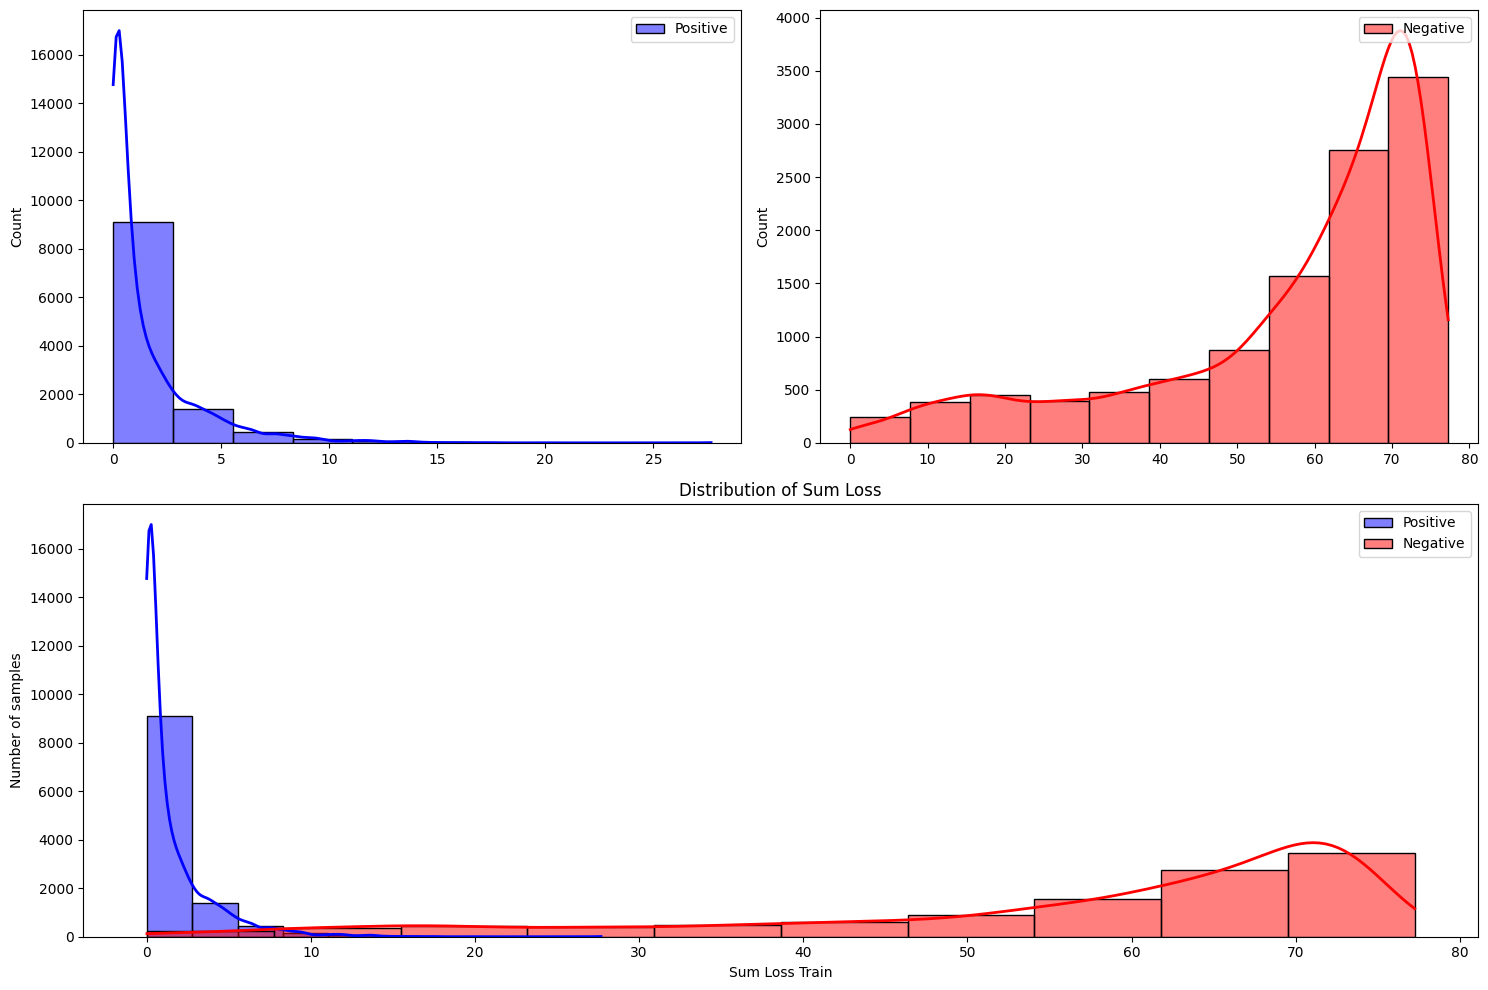

In [23]:
pos_loss, neg_loss = sumloss_visualize(train_triplets, type_name='Train')


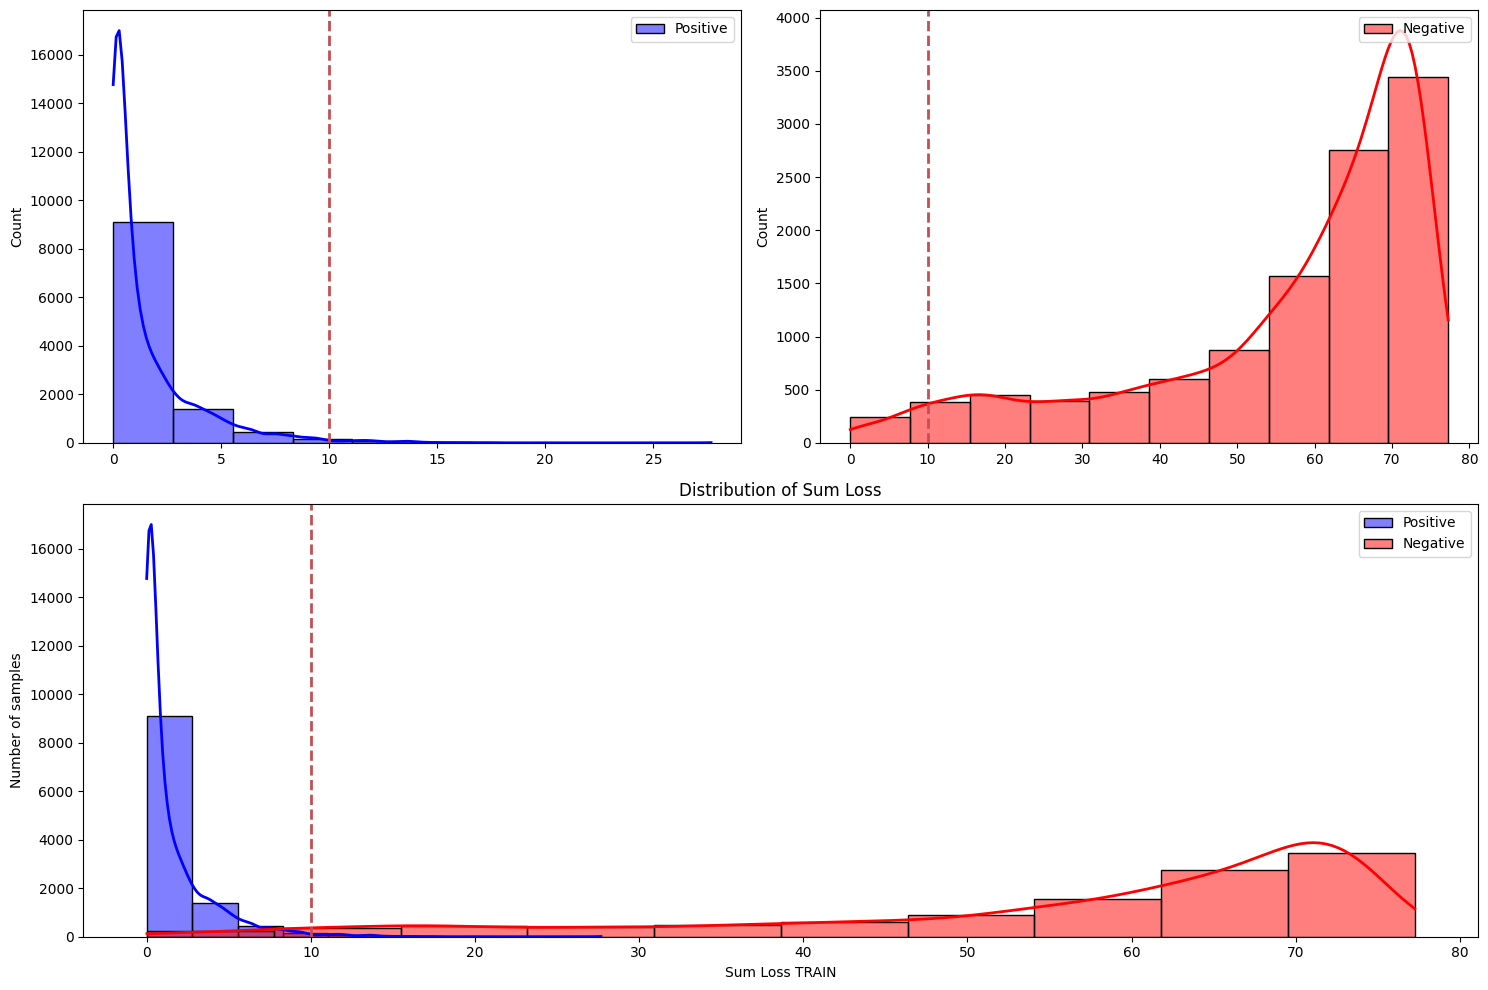

In [25]:
fig = plt.figure(figsize=(15,10))
axes = fig.subplot_mosaic("""AB
                            CC
                            """)

plt.title('Distribution of Sum Loss')
plt.xlabel(f'Sum Loss TRAIN')
plt.ylabel('Number of samples')

sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["A"], color='blue');

axes["A"].legend(loc='upper right')

sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["B"], color='red');

axes["B"].legend(loc='upper right')

sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["C"],  color='blue')
sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["C"],  color='red')

axes["C"].legend(loc='upper right')
threshold=10
if threshold is not None:
    axes["A"].axvline(x=threshold, color='r', linestyle='--')
    axes["B"].axvline(x=threshold, color='r', linestyle='--')
    axes["C"].axvline(x=threshold, color='r', linestyle='--')

plt.tight_layout()
plt.show()


  0%|          | 0/3692 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 3/3692 [00:00<02:13, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 6/3692 [00:00<02:13, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 9/3692 [00:00<02:14, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 12/3692 [00:00<02:11, 27.98it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 15/3692 [00:00<02:15, 27.17it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 18/3692 [00:00<02:16, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 21/3692 [00:00<02:15, 27.12it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 24/3692 [00:00<02:16, 26.92it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 27/3692 [00:00<02:17, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 30/3692 [00:01<02:21, 25.92it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 33/3692 [00:01<02:22, 25.66it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 36/3692 [00:01<02:21, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 39/3692 [00:01<02:18, 26.29it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 42/3692 [00:01<02:18, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 45/3692 [00:01<02:20, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 48/3692 [00:01<02:20, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏         | 51/3692 [00:01<02:18, 26.34it/s]

1/1 [==============================] - 0s 12ms/step


  1%|▏         | 54/3692 [00:02<02:17, 26.43it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 57/3692 [00:02<02:22, 25.45it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 60/3692 [00:02<02:21, 25.63it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 63/3692 [00:02<02:18, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 66/3692 [00:02<02:18, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 69/3692 [00:02<02:20, 25.77it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 72/3692 [00:02<02:16, 26.61it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 75/3692 [00:02<02:13, 27.05it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 78/3692 [00:02<02:14, 26.87it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 81/3692 [00:03<02:14, 26.76it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 84/3692 [00:03<02:15, 26.55it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 87/3692 [00:03<02:22, 25.27it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 90/3692 [00:03<02:20, 25.63it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 93/3692 [00:03<02:18, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 96/3692 [00:03<02:18, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 99/3692 [00:03<02:16, 26.31it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 102/3692 [00:03<02:14, 26.77it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 105/3692 [00:03<02:15, 26.41it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 108/3692 [00:04<02:14, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 111/3692 [00:04<02:13, 26.85it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 114/3692 [00:04<02:13, 26.80it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 117/3692 [00:04<02:12, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 120/3692 [00:04<02:17, 25.98it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 123/3692 [00:04<02:14, 26.55it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 126/3692 [00:04<02:12, 26.83it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 129/3692 [00:04<02:13, 26.59it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▎         | 132/3692 [00:04<02:13, 26.71it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▎         | 135/3692 [00:05<02:13, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▎         | 138/3692 [00:05<02:12, 26.87it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 141/3692 [00:05<02:10, 27.28it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 144/3692 [00:05<02:09, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 147/3692 [00:05<02:11, 26.93it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 150/3692 [00:05<02:12, 26.65it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 153/3692 [00:05<02:15, 26.19it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 156/3692 [00:05<02:15, 26.02it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 159/3692 [00:06<02:19, 25.24it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 162/3692 [00:06<02:16, 25.88it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 165/3692 [00:06<02:13, 26.47it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 168/3692 [00:06<02:13, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 171/3692 [00:06<02:10, 26.94it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 174/3692 [00:06<02:09, 27.10it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 177/3692 [00:06<02:10, 26.92it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 180/3692 [00:06<02:10, 26.94it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 183/3692 [00:06<02:09, 27.10it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 186/3692 [00:07<02:09, 27.00it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 189/3692 [00:07<02:09, 27.14it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 192/3692 [00:07<02:10, 26.77it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 195/3692 [00:07<02:09, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 198/3692 [00:07<02:12, 26.30it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 201/3692 [00:07<02:13, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 204/3692 [00:07<02:11, 26.60it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 207/3692 [00:07<02:10, 26.72it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 210/3692 [00:07<02:09, 26.87it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 213/3692 [00:08<02:07, 27.27it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 216/3692 [00:08<02:12, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 219/3692 [00:08<02:12, 26.29it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 222/3692 [00:08<02:10, 26.64it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 225/3692 [00:08<02:10, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 228/3692 [00:08<02:09, 26.65it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▋         | 231/3692 [00:08<02:10, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▋         | 234/3692 [00:08<02:08, 26.83it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▋         | 237/3692 [00:08<02:13, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 240/3692 [00:09<02:14, 25.68it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 243/3692 [00:09<02:12, 25.99it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 246/3692 [00:09<02:10, 26.49it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 249/3692 [00:09<02:11, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 252/3692 [00:09<02:11, 26.08it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 255/3692 [00:09<02:09, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 258/3692 [00:09<02:07, 26.86it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 261/3692 [00:09<02:07, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 264/3692 [00:09<02:05, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 267/3692 [00:10<02:06, 27.08it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 270/3692 [00:10<02:05, 27.30it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 273/3692 [00:10<02:07, 26.91it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 276/3692 [00:10<02:10, 26.16it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 279/3692 [00:10<02:08, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 282/3692 [00:10<02:09, 26.37it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 285/3692 [00:10<02:07, 26.70it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 288/3692 [00:10<02:07, 26.78it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 291/3692 [00:10<02:08, 26.56it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 294/3692 [00:11<02:07, 26.55it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 297/3692 [00:11<02:11, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 300/3692 [00:11<02:08, 26.46it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 303/3692 [00:11<02:04, 27.12it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 306/3692 [00:11<02:05, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 309/3692 [00:11<02:04, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 312/3692 [00:11<02:03, 27.37it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▊         | 315/3692 [00:11<02:03, 27.37it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 318/3692 [00:11<02:02, 27.48it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 321/3692 [00:12<02:02, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 324/3692 [00:12<02:02, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 327/3692 [00:12<02:00, 27.94it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▉         | 330/3692 [00:12<02:01, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 333/3692 [00:12<02:00, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 336/3692 [00:12<02:03, 27.11it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 339/3692 [00:12<02:04, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 343/3692 [00:12<02:00, 27.69it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▉         | 346/3692 [00:12<02:01, 27.53it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 349/3692 [00:13<02:03, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 352/3692 [00:13<02:06, 26.39it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 355/3692 [00:13<02:02, 27.13it/s]

1/1 [==============================] - 0s 13ms/step


 10%|▉         | 358/3692 [00:13<01:59, 27.83it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 361/3692 [00:13<02:00, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 10%|▉         | 364/3692 [00:13<01:59, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 367/3692 [00:13<02:00, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 370/3692 [00:13<01:58, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 373/3692 [00:13<01:59, 27.81it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 376/3692 [00:14<01:58, 28.02it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 379/3692 [00:14<02:00, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 383/3692 [00:14<01:57, 28.19it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 386/3692 [00:14<01:56, 28.41it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█         | 389/3692 [00:14<01:55, 28.71it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 392/3692 [00:14<01:58, 27.81it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█         | 395/3692 [00:14<01:57, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 398/3692 [00:14<01:59, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 401/3692 [00:14<01:58, 27.73it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 405/3692 [00:15<01:56, 28.31it/s]

1/1 [==============================] - 0s 11ms/step


 11%|█         | 408/3692 [00:15<01:55, 28.52it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 411/3692 [00:15<01:53, 28.83it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 414/3692 [00:15<01:55, 28.43it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█▏        | 417/3692 [00:15<01:55, 28.38it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█▏        | 420/3692 [00:15<01:53, 28.82it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 423/3692 [00:15<01:55, 28.33it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 426/3692 [00:15<01:56, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 429/3692 [00:15<01:56, 28.08it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 432/3692 [00:16<01:55, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 435/3692 [00:16<01:57, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 438/3692 [00:16<01:57, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 441/3692 [00:16<01:58, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 444/3692 [00:16<01:58, 27.31it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 447/3692 [00:16<01:58, 27.44it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 450/3692 [00:16<01:58, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 453/3692 [00:16<01:55, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 456/3692 [00:16<01:56, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 459/3692 [00:17<01:58, 27.34it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 462/3692 [00:17<01:58, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 465/3692 [00:17<01:56, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 468/3692 [00:17<01:53, 28.29it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 471/3692 [00:17<01:55, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 474/3692 [00:17<01:54, 28.21it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 477/3692 [00:17<01:55, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 480/3692 [00:17<01:54, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 483/3692 [00:17<01:53, 28.23it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 486/3692 [00:17<01:54, 28.12it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 489/3692 [00:18<01:54, 27.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 492/3692 [00:18<02:03, 25.99it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 495/3692 [00:18<02:05, 25.45it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 498/3692 [00:18<02:04, 25.63it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▎        | 501/3692 [00:18<02:02, 26.02it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▎        | 504/3692 [00:18<02:01, 26.21it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▎        | 507/3692 [00:18<02:02, 26.03it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 510/3692 [00:18<02:02, 25.90it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 513/3692 [00:19<02:01, 26.22it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 516/3692 [00:19<01:59, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 519/3692 [00:19<02:02, 25.91it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 522/3692 [00:19<02:03, 25.63it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 525/3692 [00:19<02:03, 25.65it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 528/3692 [00:19<02:00, 26.24it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 531/3692 [00:19<01:59, 26.46it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 534/3692 [00:19<02:00, 26.27it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 537/3692 [00:19<02:01, 25.97it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 540/3692 [00:20<01:59, 26.48it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 543/3692 [00:20<02:00, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 546/3692 [00:20<01:58, 26.65it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 549/3692 [00:20<01:57, 26.64it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 552/3692 [00:20<01:57, 26.82it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 555/3692 [00:20<01:56, 26.87it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 558/3692 [00:20<01:59, 26.13it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 561/3692 [00:20<02:01, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 564/3692 [00:20<02:01, 25.82it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 567/3692 [00:21<02:01, 25.82it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 570/3692 [00:21<01:59, 26.16it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 573/3692 [00:21<01:59, 26.20it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 576/3692 [00:21<01:59, 26.16it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 579/3692 [00:21<01:56, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 582/3692 [00:21<01:56, 26.76it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 585/3692 [00:21<01:57, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 588/3692 [00:21<01:55, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 591/3692 [00:22<01:56, 26.58it/s]

1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 594/3692 [00:22<02:03, 25.18it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 597/3692 [00:22<01:59, 25.84it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▋        | 600/3692 [00:22<01:58, 26.17it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 603/3692 [00:22<01:56, 26.48it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▋        | 606/3692 [00:22<01:55, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▋        | 609/3692 [00:22<01:56, 26.53it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 612/3692 [00:22<01:56, 26.52it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 615/3692 [00:22<01:57, 26.20it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 618/3692 [00:23<01:54, 26.82it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 621/3692 [00:23<01:55, 26.52it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 624/3692 [00:23<01:54, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 627/3692 [00:23<01:55, 26.60it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 630/3692 [00:23<01:58, 25.89it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 633/3692 [00:23<01:57, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 636/3692 [00:23<01:57, 25.93it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 639/3692 [00:23<01:54, 26.59it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 642/3692 [00:23<01:55, 26.43it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 645/3692 [00:24<01:54, 26.52it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 648/3692 [00:24<01:55, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 651/3692 [00:24<01:53, 26.89it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 654/3692 [00:24<01:52, 27.04it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 657/3692 [00:24<01:55, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 660/3692 [00:24<01:53, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 663/3692 [00:24<01:53, 26.78it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 666/3692 [00:24<01:57, 25.81it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 669/3692 [00:24<01:56, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 672/3692 [00:25<01:55, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 675/3692 [00:25<01:55, 26.11it/s]

1/1 [==============================] - 0s 12ms/step


 18%|█▊        | 678/3692 [00:25<01:53, 26.58it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 681/3692 [00:25<01:54, 26.21it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▊        | 684/3692 [00:25<01:52, 26.79it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▊        | 687/3692 [00:25<01:53, 26.36it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▊        | 690/3692 [00:25<01:51, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 693/3692 [00:25<01:49, 27.30it/s]

1/1 [==============================] - 0s 11ms/step


 19%|█▉        | 696/3692 [00:25<01:49, 27.31it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 699/3692 [00:26<01:48, 27.50it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 702/3692 [00:26<01:54, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 705/3692 [00:26<01:53, 26.36it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 708/3692 [00:26<01:51, 26.69it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 711/3692 [00:26<01:51, 26.72it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 714/3692 [00:26<01:51, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 717/3692 [00:26<01:51, 26.61it/s]

1/1 [==============================] - 0s 13ms/step


 20%|█▉        | 720/3692 [00:26<01:52, 26.33it/s]

1/1 [==============================] - 0s 13ms/step


 20%|█▉        | 723/3692 [00:26<01:53, 26.26it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 726/3692 [00:27<01:53, 26.23it/s]

1/1 [==============================] - 0s 13ms/step


 20%|█▉        | 729/3692 [00:27<01:55, 25.58it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 732/3692 [00:27<01:54, 25.79it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 735/3692 [00:27<02:02, 24.21it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 738/3692 [00:27<01:59, 24.70it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 742/3692 [00:27<01:51, 26.48it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 745/3692 [00:27<01:47, 27.30it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 748/3692 [00:27<01:49, 27.00it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 751/3692 [00:28<01:48, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 754/3692 [00:28<01:48, 27.04it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 757/3692 [00:28<01:47, 27.24it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 760/3692 [00:28<01:49, 26.88it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 763/3692 [00:28<01:47, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 766/3692 [00:28<01:45, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 769/3692 [00:28<01:47, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 772/3692 [00:28<01:45, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 775/3692 [00:28<01:45, 27.61it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 778/3692 [00:29<02:29, 19.45it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 781/3692 [00:29<02:16, 21.37it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 784/3692 [00:29<02:06, 22.95it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 787/3692 [00:29<01:59, 24.26it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 790/3692 [00:29<01:53, 25.66it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██▏       | 793/3692 [00:29<01:51, 26.11it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 796/3692 [00:29<01:48, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 799/3692 [00:29<01:47, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 802/3692 [00:30<01:45, 27.33it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 805/3692 [00:30<01:43, 27.98it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 808/3692 [00:30<01:42, 28.03it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 811/3692 [00:30<01:43, 27.78it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 814/3692 [00:30<01:45, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 817/3692 [00:30<01:47, 26.68it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 820/3692 [00:30<01:46, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 823/3692 [00:30<01:45, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 826/3692 [00:30<01:44, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 829/3692 [00:31<01:46, 26.77it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 832/3692 [00:31<01:45, 27.20it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 835/3692 [00:31<01:42, 27.89it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 838/3692 [00:31<01:40, 28.32it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 841/3692 [00:31<01:42, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 844/3692 [00:31<01:42, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 847/3692 [00:31<01:41, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 850/3692 [00:31<01:42, 27.78it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 853/3692 [00:31<01:41, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 856/3692 [00:32<01:42, 27.59it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 859/3692 [00:32<01:41, 27.79it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 862/3692 [00:32<01:41, 28.01it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 865/3692 [00:32<01:41, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▎       | 868/3692 [00:32<01:42, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▎       | 871/3692 [00:32<01:41, 27.88it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▎       | 874/3692 [00:32<01:41, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 877/3692 [00:32<01:41, 27.60it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 880/3692 [00:32<01:42, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 883/3692 [00:33<01:45, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▍       | 886/3692 [00:33<01:44, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 889/3692 [00:33<01:43, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 892/3692 [00:33<01:42, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 895/3692 [00:33<01:41, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 898/3692 [00:33<01:40, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 901/3692 [00:33<01:38, 28.20it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 904/3692 [00:33<01:38, 28.29it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 907/3692 [00:33<01:37, 28.44it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 910/3692 [00:33<01:36, 28.88it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 913/3692 [00:34<01:37, 28.53it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 916/3692 [00:34<01:41, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▍       | 919/3692 [00:34<01:41, 27.24it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▍       | 922/3692 [00:34<01:43, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 925/3692 [00:34<01:41, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 928/3692 [00:34<01:40, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 931/3692 [00:34<01:39, 27.62it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▌       | 934/3692 [00:34<01:39, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 937/3692 [00:34<01:39, 27.60it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▌       | 940/3692 [00:35<01:37, 28.19it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 943/3692 [00:35<01:37, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 946/3692 [00:35<01:38, 27.93it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 949/3692 [00:35<01:38, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 952/3692 [00:35<01:39, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 955/3692 [00:35<01:37, 27.97it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 958/3692 [00:35<01:37, 28.12it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 961/3692 [00:35<01:40, 27.09it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 964/3692 [00:35<01:40, 27.24it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 967/3692 [00:36<01:37, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▋       | 970/3692 [00:36<01:38, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▋       | 973/3692 [00:36<01:37, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▋       | 976/3692 [00:36<01:37, 27.86it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 979/3692 [00:36<01:36, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 982/3692 [00:36<01:36, 28.12it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 985/3692 [00:36<01:38, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 988/3692 [00:36<01:37, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 991/3692 [00:36<01:36, 28.00it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 994/3692 [00:36<01:36, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 997/3692 [00:37<01:36, 27.87it/s]

1/1 [==============================] - 0s 11ms/step


 27%|██▋       | 1000/3692 [00:37<01:37, 27.52it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 1003/3692 [00:37<01:36, 27.97it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 1006/3692 [00:37<01:39, 26.93it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 1009/3692 [00:37<01:39, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 1012/3692 [00:37<01:37, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 1015/3692 [00:37<01:35, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1018/3692 [00:37<01:35, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1021/3692 [00:37<01:35, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1024/3692 [00:38<01:35, 27.89it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 1027/3692 [00:38<01:35, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1030/3692 [00:38<01:35, 27.83it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1033/3692 [00:38<01:35, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1036/3692 [00:38<01:36, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1039/3692 [00:38<01:35, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1042/3692 [00:38<01:34, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1045/3692 [00:38<01:34, 28.09it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 1048/3692 [00:38<01:34, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 1051/3692 [00:39<01:34, 27.81it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 1054/3692 [00:39<01:38, 26.68it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▊       | 1057/3692 [00:39<01:38, 26.84it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▊       | 1060/3692 [00:39<01:35, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 1063/3692 [00:39<01:35, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 1066/3692 [00:39<01:36, 27.18it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 1069/3692 [00:39<01:35, 27.38it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▉       | 1072/3692 [00:39<01:35, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 1075/3692 [00:39<01:35, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 1078/3692 [00:40<01:33, 27.87it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 1081/3692 [00:40<01:35, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 1084/3692 [00:40<01:34, 27.60it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 1087/3692 [00:40<01:34, 27.67it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 1090/3692 [00:40<01:34, 27.54it/s]

1/1 [==============================] - 0s 13ms/step


 30%|██▉       | 1093/3692 [00:40<01:34, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 1096/3692 [00:40<01:35, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 1099/3692 [00:40<01:33, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 1102/3692 [00:40<01:36, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 1105/3692 [00:41<01:36, 26.82it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 1108/3692 [00:41<01:35, 27.09it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 1111/3692 [00:41<01:34, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 1114/3692 [00:41<01:33, 27.70it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 1117/3692 [00:41<01:33, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 1120/3692 [00:41<01:34, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 1123/3692 [00:41<01:33, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 1126/3692 [00:41<01:32, 27.63it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 1129/3692 [00:41<01:33, 27.32it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 1132/3692 [00:42<01:32, 27.83it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 1135/3692 [00:42<01:30, 28.39it/s]

1/1 [==============================] - 0s 11ms/step


 31%|███       | 1138/3692 [00:42<01:29, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 1141/3692 [00:42<01:29, 28.62it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 1144/3692 [00:42<01:29, 28.60it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 1147/3692 [00:42<01:30, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 1150/3692 [00:42<01:32, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 1153/3692 [00:42<01:31, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███▏      | 1156/3692 [00:42<01:30, 28.09it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███▏      | 1159/3692 [00:42<01:30, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███▏      | 1162/3692 [00:43<01:30, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1165/3692 [00:43<01:31, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1168/3692 [00:43<01:31, 27.69it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1171/3692 [00:43<01:30, 27.93it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1174/3692 [00:43<01:28, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1177/3692 [00:43<01:28, 28.42it/s]

1/1 [==============================] - 0s 11ms/step


 32%|███▏      | 1180/3692 [00:43<01:28, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1183/3692 [00:43<01:28, 28.31it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1186/3692 [00:43<01:32, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1190/3692 [00:44<01:29, 27.97it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 1193/3692 [00:44<01:28, 28.20it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1196/3692 [00:44<01:27, 28.60it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 1199/3692 [00:44<01:26, 28.74it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1202/3692 [00:44<01:27, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1205/3692 [00:44<01:28, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1208/3692 [00:44<01:27, 28.29it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1211/3692 [00:44<01:30, 27.29it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 1214/3692 [00:44<01:29, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1217/3692 [00:45<01:29, 27.69it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 1220/3692 [00:45<01:28, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1223/3692 [00:45<01:30, 27.37it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 1226/3692 [00:45<01:29, 27.55it/s]

1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 1229/3692 [00:45<01:27, 28.10it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 1232/3692 [00:45<01:28, 27.68it/s]

1/1 [==============================] - 0s 11ms/step


 33%|███▎      | 1235/3692 [00:45<01:28, 27.70it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███▎      | 1238/3692 [00:45<01:27, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▎      | 1241/3692 [00:45<01:28, 27.80it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███▎      | 1244/3692 [00:45<01:27, 27.98it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███▍      | 1247/3692 [00:46<01:25, 28.54it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 1250/3692 [00:46<01:26, 28.29it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 1253/3692 [00:46<01:25, 28.69it/s]

1/1 [==============================] - 0s 11ms/step


 34%|███▍      | 1256/3692 [00:46<01:29, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 1259/3692 [00:46<01:27, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 1262/3692 [00:46<01:26, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 1265/3692 [00:46<01:26, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 1268/3692 [00:46<01:25, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 1271/3692 [00:46<01:26, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 1274/3692 [00:47<01:25, 28.33it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▍      | 1277/3692 [00:47<01:26, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▍      | 1280/3692 [00:47<01:28, 27.37it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 1283/3692 [00:47<01:25, 28.02it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 1286/3692 [00:47<01:24, 28.33it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 1289/3692 [00:47<01:24, 28.31it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 1292/3692 [00:47<01:29, 26.89it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▌      | 1295/3692 [00:47<01:26, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 1298/3692 [00:47<01:26, 27.78it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 1301/3692 [00:48<01:26, 27.69it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 1304/3692 [00:48<01:25, 27.94it/s]

1/1 [==============================] - 0s 11ms/step


 35%|███▌      | 1307/3692 [00:48<01:24, 28.27it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 1310/3692 [00:48<01:22, 28.75it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 1313/3692 [00:48<01:23, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1316/3692 [00:48<01:23, 28.41it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1319/3692 [00:48<01:22, 28.85it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1322/3692 [00:48<01:21, 29.01it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1325/3692 [00:48<01:23, 28.29it/s]

1/1 [==============================] - 0s 11ms/step


 36%|███▌      | 1328/3692 [00:48<01:24, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1331/3692 [00:49<01:23, 28.35it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1334/3692 [00:49<01:22, 28.48it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 1337/3692 [00:49<01:22, 28.58it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▋      | 1340/3692 [00:49<01:21, 28.97it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1343/3692 [00:49<01:21, 28.92it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▋      | 1346/3692 [00:49<01:21, 28.84it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1350/3692 [00:49<01:19, 29.34it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1353/3692 [00:49<01:20, 28.95it/s]

1/1 [==============================] - 0s 11ms/step


 37%|███▋      | 1356/3692 [00:49<01:22, 28.38it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1359/3692 [00:50<01:25, 27.16it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1362/3692 [00:50<01:25, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1365/3692 [00:50<01:23, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1368/3692 [00:50<01:23, 27.98it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1371/3692 [00:50<01:22, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1374/3692 [00:50<01:22, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1377/3692 [00:50<01:24, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1380/3692 [00:50<01:23, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1383/3692 [00:50<01:22, 28.00it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 1386/3692 [00:51<01:22, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1389/3692 [00:51<01:22, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1392/3692 [00:51<01:25, 26.92it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1396/3692 [00:51<01:21, 28.20it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 1399/3692 [00:51<01:19, 28.68it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 1402/3692 [00:51<01:22, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1405/3692 [00:51<01:20, 28.40it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1408/3692 [00:51<01:19, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1411/3692 [00:51<01:19, 28.59it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1414/3692 [00:52<01:19, 28.57it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1417/3692 [00:52<01:20, 28.32it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 1420/3692 [00:52<01:20, 28.30it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 1423/3692 [00:52<01:22, 27.67it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▊      | 1426/3692 [00:52<01:25, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 1430/3692 [00:52<01:21, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 1433/3692 [00:52<01:21, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1436/3692 [00:52<01:21, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1439/3692 [00:52<01:20, 27.99it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1442/3692 [00:53<01:19, 28.14it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1445/3692 [00:53<01:19, 28.18it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1448/3692 [00:53<01:20, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1451/3692 [00:53<01:18, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1454/3692 [00:53<01:18, 28.48it/s]

1/1 [==============================] - 0s 11ms/step


 39%|███▉      | 1457/3692 [00:53<01:21, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 1460/3692 [00:53<01:21, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 1463/3692 [00:53<01:21, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 1466/3692 [00:53<01:20, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 1469/3692 [00:54<01:21, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 1472/3692 [00:54<01:21, 27.08it/s]

1/1 [==============================] - 0s 12ms/step


 40%|███▉      | 1475/3692 [00:54<01:22, 26.83it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 1478/3692 [00:54<01:20, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 1481/3692 [00:54<01:20, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 1484/3692 [00:54<01:18, 28.02it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 1487/3692 [00:54<01:22, 26.74it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 1490/3692 [00:54<01:21, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 1493/3692 [00:54<01:19, 27.79it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1496/3692 [00:55<01:18, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1499/3692 [00:55<01:17, 28.13it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████      | 1502/3692 [00:55<01:17, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1505/3692 [00:55<01:16, 28.47it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1508/3692 [00:55<01:16, 28.57it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1511/3692 [00:55<01:16, 28.56it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1514/3692 [00:55<01:16, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1517/3692 [00:55<01:16, 28.54it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 1520/3692 [00:55<01:19, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 1523/3692 [00:55<01:19, 27.41it/s]

1/1 [==============================] - 0s 11ms/step


 41%|████▏     | 1526/3692 [00:56<01:18, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 1529/3692 [00:56<01:19, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████▏     | 1532/3692 [00:56<01:17, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1535/3692 [00:56<01:16, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1538/3692 [00:56<01:17, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1541/3692 [00:56<01:17, 27.92it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 1544/3692 [00:56<01:18, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1547/3692 [00:56<01:18, 27.20it/s]

1/1 [==============================] - 0s 11ms/step


 42%|████▏     | 1550/3692 [00:56<01:21, 26.36it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1553/3692 [00:57<01:19, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1556/3692 [00:57<01:19, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1559/3692 [00:57<01:16, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1562/3692 [00:57<01:17, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1565/3692 [00:57<01:17, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 1568/3692 [00:57<01:16, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1571/3692 [00:57<01:15, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1574/3692 [00:57<01:14, 28.44it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 1577/3692 [00:57<01:15, 27.95it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████▎     | 1580/3692 [00:58<01:18, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1583/3692 [00:58<01:16, 27.52it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 1586/3692 [00:58<01:17, 27.21it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 1589/3692 [00:58<01:15, 27.98it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1592/3692 [00:58<01:14, 28.22it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 1595/3692 [00:58<01:13, 28.39it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 1598/3692 [00:58<01:12, 28.76it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1601/3692 [00:58<01:13, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1604/3692 [00:58<01:13, 28.49it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▎     | 1607/3692 [00:58<01:14, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▎     | 1610/3692 [00:59<01:16, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▎     | 1613/3692 [00:59<01:17, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 1616/3692 [00:59<01:16, 27.09it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 1619/3692 [00:59<01:14, 27.86it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1622/3692 [00:59<01:13, 28.30it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 1625/3692 [00:59<01:12, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1628/3692 [00:59<01:12, 28.47it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1631/3692 [00:59<01:12, 28.47it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 1634/3692 [00:59<01:12, 28.33it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1637/3692 [01:00<01:11, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1640/3692 [01:00<01:16, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 1643/3692 [01:00<01:14, 27.58it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 1646/3692 [01:00<01:12, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 1649/3692 [01:00<01:12, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 1652/3692 [01:00<01:11, 28.72it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 1655/3692 [01:00<01:11, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 1658/3692 [01:00<01:11, 28.59it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▍     | 1661/3692 [01:00<01:10, 28.73it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 1664/3692 [01:01<01:10, 28.67it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▌     | 1667/3692 [01:01<01:11, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 1670/3692 [01:01<01:14, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 1673/3692 [01:01<01:13, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 1677/3692 [01:01<01:10, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1680/3692 [01:01<01:11, 28.16it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 1683/3692 [01:01<01:40, 20.03it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▌     | 1686/3692 [01:01<01:31, 21.93it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1689/3692 [01:02<01:25, 23.31it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1692/3692 [01:02<01:21, 24.52it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1695/3692 [01:02<01:17, 25.85it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1698/3692 [01:02<01:15, 26.38it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▌     | 1701/3692 [01:02<01:17, 25.75it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1704/3692 [01:02<01:17, 25.61it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▌     | 1707/3692 [01:02<01:15, 26.21it/s]

1/1 [==============================] - 0s 11ms/step


 46%|████▋     | 1710/3692 [01:02<01:13, 26.79it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▋     | 1713/3692 [01:02<01:12, 27.16it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▋     | 1716/3692 [01:03<01:11, 27.78it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1719/3692 [01:03<01:10, 27.92it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1722/3692 [01:03<01:11, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1725/3692 [01:03<01:09, 28.35it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1728/3692 [01:03<01:08, 28.73it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1731/3692 [01:03<01:11, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1734/3692 [01:03<01:09, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1737/3692 [01:03<01:08, 28.40it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 1740/3692 [01:03<01:08, 28.60it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1743/3692 [01:03<01:07, 28.99it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1746/3692 [01:04<01:08, 28.52it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1749/3692 [01:04<01:08, 28.44it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1752/3692 [01:04<01:07, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1755/3692 [01:04<01:07, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1758/3692 [01:04<01:07, 28.75it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1761/3692 [01:04<01:10, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1764/3692 [01:04<01:10, 27.54it/s]

1/1 [==============================] - 0s 11ms/step


 48%|████▊     | 1767/3692 [01:04<01:09, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1770/3692 [01:04<01:08, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1773/3692 [01:05<01:08, 28.14it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1776/3692 [01:05<01:07, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1779/3692 [01:05<01:08, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1782/3692 [01:05<01:07, 28.31it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1785/3692 [01:05<01:07, 28.46it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 1788/3692 [01:05<01:09, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 1791/3692 [01:05<01:08, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 1794/3692 [01:05<01:09, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 1797/3692 [01:05<01:07, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1800/3692 [01:06<01:07, 28.12it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1803/3692 [01:06<01:07, 27.85it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 1806/3692 [01:06<01:06, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1809/3692 [01:06<01:06, 28.39it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 1812/3692 [01:06<01:05, 28.68it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1815/3692 [01:06<01:09, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1818/3692 [01:06<01:07, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1821/3692 [01:06<01:06, 28.03it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1824/3692 [01:06<01:05, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1827/3692 [01:06<01:05, 28.26it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 1830/3692 [01:07<01:04, 28.75it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 1833/3692 [01:07<01:05, 28.20it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 1836/3692 [01:07<01:06, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 1839/3692 [01:07<01:05, 28.12it/s]

1/1 [==============================] - 0s 11ms/step


 50%|████▉     | 1842/3692 [01:07<01:09, 26.56it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 1845/3692 [01:07<01:08, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 1848/3692 [01:07<01:07, 27.35it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 1851/3692 [01:07<01:06, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 1854/3692 [01:07<01:04, 28.28it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 1857/3692 [01:08<01:04, 28.52it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 1860/3692 [01:08<01:05, 27.96it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 1863/3692 [01:08<01:06, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1866/3692 [01:08<01:06, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1869/3692 [01:08<01:10, 25.94it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1872/3692 [01:08<01:09, 26.31it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1875/3692 [01:08<01:09, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1878/3692 [01:08<01:07, 26.81it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████     | 1881/3692 [01:08<01:07, 27.02it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1884/3692 [01:09<01:05, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1887/3692 [01:09<01:06, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 1890/3692 [01:09<01:05, 27.56it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 1893/3692 [01:09<01:07, 26.78it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████▏    | 1896/3692 [01:09<01:05, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████▏    | 1899/3692 [01:09<01:06, 27.16it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1902/3692 [01:09<01:04, 27.59it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1905/3692 [01:09<01:07, 26.54it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1908/3692 [01:09<01:06, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 1911/3692 [01:10<01:06, 26.85it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1914/3692 [01:10<01:07, 26.35it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1917/3692 [01:10<01:07, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 1920/3692 [01:10<01:06, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 1923/3692 [01:10<01:05, 26.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1926/3692 [01:10<01:08, 25.74it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1929/3692 [01:10<01:08, 25.61it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 1932/3692 [01:10<01:08, 25.81it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1935/3692 [01:11<01:06, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1938/3692 [01:11<01:06, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1941/3692 [01:11<01:06, 26.37it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 1944/3692 [01:11<01:05, 26.69it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 1947/3692 [01:11<01:04, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1950/3692 [01:11<01:03, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1953/3692 [01:11<01:03, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1956/3692 [01:11<01:04, 27.03it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1959/3692 [01:11<01:09, 25.06it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1962/3692 [01:12<01:07, 25.74it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1965/3692 [01:12<01:05, 26.45it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1968/3692 [01:12<01:03, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1971/3692 [01:12<01:03, 27.31it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1974/3692 [01:12<01:01, 28.05it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▎    | 1977/3692 [01:12<01:01, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 1980/3692 [01:12<01:01, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 1983/3692 [01:12<01:01, 27.60it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1986/3692 [01:12<01:02, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 1989/3692 [01:12<01:01, 27.52it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 1992/3692 [01:13<01:00, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 1995/3692 [01:13<01:00, 27.86it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 1998/3692 [01:13<01:00, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 2001/3692 [01:13<00:59, 28.32it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 2004/3692 [01:13<00:59, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 2007/3692 [01:13<00:58, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 2010/3692 [01:13<01:01, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 2013/3692 [01:13<01:00, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 2016/3692 [01:13<00:58, 28.52it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 2019/3692 [01:14<00:59, 28.33it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████▍    | 2022/3692 [01:14<00:59, 28.18it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 2025/3692 [01:14<00:59, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 2028/3692 [01:14<00:58, 28.40it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 2031/3692 [01:14<00:58, 28.34it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 2034/3692 [01:14<00:59, 28.08it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████▌    | 2037/3692 [01:14<00:59, 27.93it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 2040/3692 [01:14<01:00, 27.42it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 2043/3692 [01:14<01:02, 26.43it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████▌    | 2046/3692 [01:15<01:00, 27.02it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████▌    | 2049/3692 [01:15<01:01, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 2052/3692 [01:15<01:00, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 2055/3692 [01:15<00:58, 27.83it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 2058/3692 [01:15<00:58, 27.88it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████▌    | 2061/3692 [01:15<00:58, 27.76it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████▌    | 2064/3692 [01:15<00:58, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 2067/3692 [01:15<00:59, 27.32it/s]

1/1 [==============================] - 0s 13ms/step


 56%|█████▌    | 2070/3692 [01:15<01:00, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 2073/3692 [01:16<01:03, 25.68it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 2076/3692 [01:16<01:01, 26.48it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▋    | 2079/3692 [01:16<00:59, 27.10it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 2082/3692 [01:16<00:58, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 2085/3692 [01:16<00:57, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2088/3692 [01:16<00:56, 28.19it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 2091/3692 [01:16<00:56, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2094/3692 [01:16<00:56, 28.31it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2097/3692 [01:16<00:56, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2100/3692 [01:16<00:57, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2103/3692 [01:17<00:56, 28.14it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2106/3692 [01:17<00:57, 27.63it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 2109/3692 [01:17<00:58, 27.07it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2112/3692 [01:17<00:57, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2115/3692 [01:17<00:56, 27.81it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 2118/3692 [01:17<00:56, 27.86it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 2121/3692 [01:17<00:56, 27.86it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████▊    | 2124/3692 [01:17<00:55, 28.46it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 2127/3692 [01:17<00:56, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 2130/3692 [01:18<00:55, 27.95it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████▊    | 2133/3692 [01:18<00:55, 28.14it/s]

1/1 [==============================] - 0s 13ms/step


 58%|█████▊    | 2136/3692 [01:18<00:54, 28.57it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 2139/3692 [01:18<00:54, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 2142/3692 [01:18<00:55, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 2145/3692 [01:18<00:55, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 2148/3692 [01:18<00:55, 27.99it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 2152/3692 [01:18<00:53, 28.78it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 2155/3692 [01:18<00:54, 28.41it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 2158/3692 [01:19<00:54, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 2161/3692 [01:19<00:55, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 2165/3692 [01:19<00:54, 28.26it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▊    | 2168/3692 [01:19<00:53, 28.48it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 2171/3692 [01:19<00:53, 28.49it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2174/3692 [01:19<00:52, 28.90it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2177/3692 [01:19<00:53, 28.31it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2180/3692 [01:19<00:54, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2183/3692 [01:19<00:54, 27.80it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2186/3692 [01:20<00:54, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2189/3692 [01:20<00:53, 28.29it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 2193/3692 [01:20<00:51, 28.83it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 2196/3692 [01:20<00:51, 28.82it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 2199/3692 [01:20<00:51, 28.89it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 2202/3692 [01:20<00:51, 28.77it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 2205/3692 [01:20<00:52, 28.46it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 2208/3692 [01:20<00:51, 28.58it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 2211/3692 [01:20<00:52, 28.40it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 2214/3692 [01:21<00:52, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 2217/3692 [01:21<00:55, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 2220/3692 [01:21<00:53, 27.58it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 2223/3692 [01:21<00:52, 27.78it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 2226/3692 [01:21<00:52, 27.92it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 2229/3692 [01:21<00:51, 28.31it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 2233/3692 [01:21<00:50, 28.77it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2236/3692 [01:21<00:50, 28.78it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2239/3692 [01:21<00:50, 28.87it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2242/3692 [01:22<00:51, 28.42it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████    | 2245/3692 [01:22<00:51, 28.06it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████    | 2248/3692 [01:22<00:51, 28.20it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2251/3692 [01:22<00:54, 26.42it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2254/3692 [01:22<00:52, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2257/3692 [01:22<00:51, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2260/3692 [01:22<00:50, 28.19it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 2263/3692 [01:22<00:49, 28.61it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 2266/3692 [01:22<00:49, 28.75it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████▏   | 2269/3692 [01:22<00:49, 28.52it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 2272/3692 [01:23<00:49, 28.93it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 2275/3692 [01:23<00:49, 28.65it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 2278/3692 [01:23<00:50, 28.27it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 2281/3692 [01:23<00:49, 28.75it/s]

1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 2284/3692 [01:23<00:48, 29.10it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 2287/3692 [01:23<00:50, 28.03it/s]

1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 2290/3692 [01:23<00:50, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 2293/3692 [01:23<00:50, 27.98it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 2296/3692 [01:23<00:48, 28.49it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 2299/3692 [01:24<00:49, 28.38it/s]

1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 2302/3692 [01:24<00:48, 28.58it/s]

1/1 [==============================] - 0s 11ms/step


 62%|██████▏   | 2305/3692 [01:24<00:48, 28.41it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2308/3692 [01:24<00:49, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2312/3692 [01:24<00:48, 28.72it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2315/3692 [01:24<00:48, 28.59it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2318/3692 [01:24<00:47, 28.83it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 2321/3692 [01:24<00:47, 28.66it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2324/3692 [01:24<00:49, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2327/3692 [01:25<00:49, 27.72it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 2330/3692 [01:25<00:49, 27.50it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2333/3692 [01:25<00:48, 27.88it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 2336/3692 [01:25<00:47, 28.46it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2339/3692 [01:25<00:47, 28.73it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2342/3692 [01:25<00:46, 28.79it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▎   | 2345/3692 [01:25<00:46, 28.79it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 2349/3692 [01:25<00:45, 29.40it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 2353/3692 [01:25<00:45, 29.32it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 2356/3692 [01:26<00:45, 29.18it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 2359/3692 [01:26<00:48, 27.42it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 2362/3692 [01:26<00:47, 27.80it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 2365/3692 [01:26<00:47, 28.16it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 2368/3692 [01:26<00:46, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 2371/3692 [01:26<00:47, 27.77it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▍   | 2374/3692 [01:26<00:46, 28.25it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████▍   | 2377/3692 [01:26<00:46, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 2380/3692 [01:26<00:45, 28.58it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 2383/3692 [01:27<00:46, 28.40it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 2386/3692 [01:27<00:46, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 2389/3692 [01:27<00:46, 28.12it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 2392/3692 [01:27<00:47, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 2395/3692 [01:27<00:47, 27.22it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▍   | 2399/3692 [01:27<00:45, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 2402/3692 [01:27<00:45, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 2405/3692 [01:27<00:45, 28.41it/s]

1/1 [==============================] - 0s 11ms/step


 65%|██████▌   | 2409/3692 [01:27<00:45, 28.32it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████▌   | 2412/3692 [01:28<00:44, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 2415/3692 [01:28<00:45, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 2418/3692 [01:28<00:45, 27.98it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 2421/3692 [01:28<00:44, 28.53it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 2425/3692 [01:28<00:43, 29.09it/s]

1/1 [==============================] - 0s 13ms/step


 66%|██████▌   | 2428/3692 [01:28<00:44, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 2431/3692 [01:28<00:44, 28.30it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▌   | 2434/3692 [01:28<00:45, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 2437/3692 [01:28<00:44, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 2441/3692 [01:29<00:43, 29.06it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 2444/3692 [01:29<00:42, 29.14it/s]

1/1 [==============================] - 0s 11ms/step


 66%|██████▋   | 2447/3692 [01:29<00:42, 29.37it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▋   | 2450/3692 [01:29<00:42, 29.28it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▋   | 2453/3692 [01:29<00:42, 29.39it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2456/3692 [01:29<00:41, 29.47it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2459/3692 [01:29<00:42, 29.22it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 2462/3692 [01:29<00:44, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2465/3692 [01:29<00:43, 28.34it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 2468/3692 [01:29<00:42, 28.80it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 2472/3692 [01:30<00:41, 29.17it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 2475/3692 [01:30<00:42, 28.83it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2478/3692 [01:30<00:41, 29.14it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2481/3692 [01:30<00:41, 29.12it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2484/3692 [01:30<00:41, 28.87it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 2487/3692 [01:30<00:43, 27.90it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2490/3692 [01:30<00:43, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2493/3692 [01:30<00:42, 27.92it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 2496/3692 [01:30<00:42, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2499/3692 [01:31<00:42, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2502/3692 [01:31<00:42, 28.18it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 2505/3692 [01:31<00:41, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2508/3692 [01:31<00:41, 28.79it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2511/3692 [01:31<00:40, 29.13it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2514/3692 [01:31<00:40, 29.03it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2517/3692 [01:31<00:43, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2520/3692 [01:31<00:42, 27.62it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 2523/3692 [01:31<00:41, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2526/3692 [01:32<00:41, 28.05it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 2529/3692 [01:32<00:41, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 2532/3692 [01:32<00:40, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 2536/3692 [01:32<00:39, 29.10it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2539/3692 [01:32<00:39, 29.25it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2542/3692 [01:32<00:39, 29.12it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 2545/3692 [01:32<00:39, 28.87it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2548/3692 [01:32<00:39, 28.61it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2551/3692 [01:32<00:41, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2554/3692 [01:33<00:40, 27.80it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2557/3692 [01:33<00:40, 27.86it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 2560/3692 [01:33<00:39, 28.37it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▉   | 2563/3692 [01:33<00:56, 19.88it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2566/3692 [01:33<00:50, 22.10it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 2569/3692 [01:33<00:47, 23.87it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2572/3692 [01:33<00:44, 25.03it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2575/3692 [01:33<00:42, 26.05it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2578/3692 [01:34<00:42, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2581/3692 [01:34<00:41, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2584/3692 [01:34<00:42, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 2587/3692 [01:34<00:41, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 2590/3692 [01:34<00:40, 27.53it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 2593/3692 [01:34<00:39, 28.12it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 2596/3692 [01:34<00:39, 27.74it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 2599/3692 [01:34<00:38, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 2602/3692 [01:34<00:38, 28.17it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 2605/3692 [01:34<00:38, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 2609/3692 [01:35<00:37, 28.96it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 2612/3692 [01:35<00:38, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 2615/3692 [01:35<00:38, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 2618/3692 [01:35<00:38, 27.62it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████   | 2621/3692 [01:35<00:38, 27.87it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████   | 2624/3692 [01:35<00:37, 28.40it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 2627/3692 [01:35<00:37, 28.07it/s]

1/1 [==============================] - 0s 13ms/step


 71%|███████   | 2630/3692 [01:35<00:39, 27.12it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 2633/3692 [01:35<00:38, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 2636/3692 [01:36<00:38, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████▏  | 2639/3692 [01:36<00:38, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 2642/3692 [01:36<00:38, 27.63it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 2645/3692 [01:36<00:37, 27.74it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 2648/3692 [01:36<00:37, 27.74it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 2651/3692 [01:36<00:37, 27.72it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 2654/3692 [01:36<00:37, 27.65it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 2657/3692 [01:36<00:36, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 2660/3692 [01:36<00:37, 27.24it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 2663/3692 [01:37<00:37, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 2666/3692 [01:37<00:37, 27.18it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 2669/3692 [01:37<00:36, 27.80it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2672/3692 [01:37<00:37, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 2675/3692 [01:37<00:37, 26.78it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 2678/3692 [01:37<00:36, 27.67it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 2681/3692 [01:37<00:36, 28.08it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 2684/3692 [01:37<00:35, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 2687/3692 [01:37<00:35, 28.22it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 2690/3692 [01:38<00:36, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 2693/3692 [01:38<00:35, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 2696/3692 [01:38<00:35, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 2699/3692 [01:38<00:35, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 2702/3692 [01:38<00:36, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 2706/3692 [01:38<00:35, 28.05it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 2710/3692 [01:38<00:34, 28.65it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 2713/3692 [01:38<00:34, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 2716/3692 [01:38<00:35, 27.81it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▎  | 2719/3692 [01:39<00:34, 28.16it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 2722/3692 [01:39<00:34, 28.07it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 2725/3692 [01:39<00:33, 28.45it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 2728/3692 [01:39<00:34, 27.93it/s]

1/1 [==============================] - 0s 13ms/step


 74%|███████▍  | 2731/3692 [01:39<00:35, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 2734/3692 [01:39<00:35, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 2737/3692 [01:39<00:34, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 2740/3692 [01:39<00:33, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 2743/3692 [01:39<00:33, 28.23it/s]

1/1 [==============================] - 0s 11ms/step


 74%|███████▍  | 2746/3692 [01:40<00:33, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 2749/3692 [01:40<00:33, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 75%|███████▍  | 2752/3692 [01:40<00:33, 28.41it/s]

1/1 [==============================] - 0s 14ms/step


 75%|███████▍  | 2755/3692 [01:40<00:33, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 2758/3692 [01:40<00:33, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 2761/3692 [01:40<00:33, 28.07it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 2764/3692 [01:40<00:32, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 2767/3692 [01:40<00:32, 28.42it/s]

1/1 [==============================] - 0s 11ms/step


 75%|███████▌  | 2770/3692 [01:40<00:32, 27.98it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2773/3692 [01:41<00:34, 27.00it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 2776/3692 [01:41<00:33, 27.37it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 2779/3692 [01:41<00:33, 27.41it/s]

1/1 [==============================] - 0s 13ms/step


 75%|███████▌  | 2782/3692 [01:41<00:33, 27.36it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 2785/3692 [01:41<00:32, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2788/3692 [01:41<00:31, 28.40it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2791/3692 [01:41<00:32, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2794/3692 [01:41<00:31, 28.35it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2797/3692 [01:41<00:31, 28.81it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 2800/3692 [01:41<00:31, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2803/3692 [01:42<00:32, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2806/3692 [01:42<00:32, 27.44it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2809/3692 [01:42<00:31, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 2812/3692 [01:42<00:31, 27.83it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 2815/3692 [01:42<00:31, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 2818/3692 [01:42<00:30, 28.20it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 2821/3692 [01:42<00:30, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▋  | 2824/3692 [01:42<00:30, 28.75it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2827/3692 [01:42<00:31, 27.13it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2830/3692 [01:43<00:31, 27.61it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2833/3692 [01:43<00:30, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 2836/3692 [01:43<00:30, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 77%|███████▋  | 2839/3692 [01:43<00:30, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 2842/3692 [01:43<00:29, 28.51it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 2845/3692 [01:43<00:29, 28.67it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2848/3692 [01:43<00:29, 28.71it/s]

1/1 [==============================] - 0s 11ms/step


 77%|███████▋  | 2851/3692 [01:43<00:30, 27.98it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2854/3692 [01:43<00:30, 27.35it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 2857/3692 [01:44<00:30, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 2860/3692 [01:44<00:30, 27.61it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 2863/3692 [01:44<00:29, 27.88it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████▊  | 2867/3692 [01:44<00:28, 28.78it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████▊  | 2871/3692 [01:44<00:28, 29.24it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████▊  | 2874/3692 [01:44<00:28, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 2877/3692 [01:44<00:28, 28.59it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 2880/3692 [01:44<00:28, 28.65it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 2883/3692 [01:44<00:29, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 2886/3692 [01:45<00:29, 27.56it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 2889/3692 [01:45<00:29, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 2892/3692 [01:45<00:29, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 2895/3692 [01:45<00:28, 28.13it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 2898/3692 [01:45<00:28, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 2901/3692 [01:45<00:28, 28.02it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 2904/3692 [01:45<00:28, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 2907/3692 [01:45<00:29, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 2910/3692 [01:45<00:29, 26.79it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2913/3692 [01:46<00:28, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2916/3692 [01:46<00:28, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2919/3692 [01:46<00:28, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2922/3692 [01:46<00:28, 27.47it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 2925/3692 [01:46<00:28, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2928/3692 [01:46<00:29, 26.16it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2931/3692 [01:46<00:28, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 2934/3692 [01:46<00:28, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 2937/3692 [01:46<00:28, 26.72it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 2940/3692 [01:47<00:27, 27.05it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████▉  | 2943/3692 [01:47<00:27, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 2946/3692 [01:47<00:27, 27.27it/s]

1/1 [==============================] - 0s 14ms/step


 80%|███████▉  | 2949/3692 [01:47<00:28, 26.33it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 2952/3692 [01:47<00:27, 26.88it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 2955/3692 [01:47<00:27, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 2958/3692 [01:47<00:26, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 2961/3692 [01:47<00:26, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 2964/3692 [01:47<00:26, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 2967/3692 [01:48<00:25, 27.89it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 2970/3692 [01:48<00:27, 26.66it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2973/3692 [01:48<00:26, 27.12it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 2976/3692 [01:48<00:26, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2979/3692 [01:48<00:26, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2982/3692 [01:48<00:25, 27.35it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 2985/3692 [01:48<00:25, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2988/3692 [01:48<00:25, 27.89it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 2991/3692 [01:48<00:26, 26.91it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2994/3692 [01:49<00:26, 26.51it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2997/3692 [01:49<00:25, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████▏ | 3000/3692 [01:49<00:24, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████▏ | 3003/3692 [01:49<00:24, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████▏ | 3006/3692 [01:49<00:24, 28.32it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 3009/3692 [01:49<00:23, 28.70it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3012/3692 [01:49<00:24, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3015/3692 [01:49<00:24, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3018/3692 [01:49<00:24, 28.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3021/3692 [01:49<00:24, 27.18it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3024/3692 [01:50<00:24, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3027/3692 [01:50<00:24, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 3030/3692 [01:50<00:23, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3033/3692 [01:50<00:22, 28.65it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 3036/3692 [01:50<00:23, 28.45it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 3039/3692 [01:50<00:23, 27.88it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 3042/3692 [01:50<00:23, 27.17it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 3045/3692 [01:50<00:24, 26.86it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 3048/3692 [01:50<00:23, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 3051/3692 [01:51<00:24, 26.12it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 3054/3692 [01:51<00:24, 26.38it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 3057/3692 [01:51<00:23, 26.92it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 3060/3692 [01:51<00:23, 26.83it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 3063/3692 [01:51<00:23, 26.81it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 3066/3692 [01:51<00:23, 26.79it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 3069/3692 [01:51<00:22, 27.36it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 3072/3692 [01:51<00:22, 27.32it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 3075/3692 [01:51<00:23, 26.81it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 3078/3692 [01:52<00:22, 27.15it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 3081/3692 [01:52<00:22, 27.20it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▎ | 3084/3692 [01:52<00:21, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 3087/3692 [01:52<00:21, 28.15it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 3090/3692 [01:52<00:21, 28.10it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 3093/3692 [01:52<00:21, 27.57it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 3096/3692 [01:52<00:22, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 3099/3692 [01:52<00:21, 27.13it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████▍ | 3102/3692 [01:52<00:21, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 3105/3692 [01:53<00:21, 27.70it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 3108/3692 [01:53<00:21, 27.64it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 3111/3692 [01:53<00:20, 28.21it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 3114/3692 [01:53<00:21, 27.01it/s]

1/1 [==============================] - 0s 13ms/step


 84%|████████▍ | 3117/3692 [01:53<00:20, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 3120/3692 [01:53<00:20, 27.73it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 3123/3692 [01:53<00:20, 27.81it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 3126/3692 [01:53<00:20, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 3129/3692 [01:53<00:19, 28.30it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 3132/3692 [01:54<00:20, 26.91it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 3135/3692 [01:54<00:20, 27.60it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 3138/3692 [01:54<00:19, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 3141/3692 [01:54<00:19, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 3144/3692 [01:54<00:19, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 3147/3692 [01:54<00:19, 28.41it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 3150/3692 [01:54<00:19, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 3153/3692 [01:54<00:20, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 3156/3692 [01:54<00:20, 26.61it/s]

1/1 [==============================] - 0s 11ms/step


 86%|████████▌ | 3159/3692 [01:55<00:19, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 3162/3692 [01:55<00:19, 27.17it/s]

1/1 [==============================] - 0s 11ms/step


 86%|████████▌ | 3165/3692 [01:55<00:19, 27.64it/s]

1/1 [==============================] - 0s 11ms/step


 86%|████████▌ | 3168/3692 [01:55<00:18, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 3171/3692 [01:55<00:19, 26.60it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 3174/3692 [01:55<00:19, 27.20it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 3177/3692 [01:55<00:18, 27.51it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 3180/3692 [01:55<00:18, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 3183/3692 [01:55<00:18, 27.97it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▋ | 3186/3692 [01:55<00:18, 27.89it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 3189/3692 [01:56<00:18, 27.17it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▋ | 3192/3692 [01:56<00:18, 27.64it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3195/3692 [01:56<00:18, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3198/3692 [01:56<00:17, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3201/3692 [01:56<00:17, 28.65it/s]

1/1 [==============================] - 0s 11ms/step


 87%|████████▋ | 3204/3692 [01:56<00:17, 28.53it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3207/3692 [01:56<00:16, 28.53it/s]

1/1 [==============================] - 0s 11ms/step


 87%|████████▋ | 3210/3692 [01:56<00:17, 27.29it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3213/3692 [01:56<00:17, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3216/3692 [01:57<00:16, 28.45it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 3219/3692 [01:57<00:16, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 3223/3692 [01:57<00:16, 29.08it/s]

1/1 [==============================] - 0s 11ms/step


 87%|████████▋ | 3226/3692 [01:57<00:16, 28.92it/s]

1/1 [==============================] - 0s 11ms/step


 87%|████████▋ | 3230/3692 [01:57<00:15, 29.47it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3233/3692 [01:57<00:16, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3236/3692 [01:57<00:16, 28.23it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3240/3692 [01:57<00:15, 28.87it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3243/3692 [01:57<00:15, 28.70it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3246/3692 [01:58<00:15, 28.65it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3249/3692 [01:58<00:15, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3252/3692 [01:58<00:15, 28.01it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████▊ | 3255/3692 [01:58<00:16, 27.08it/s]

1/1 [==============================] - 0s 11ms/step


 88%|████████▊ | 3258/3692 [01:58<00:15, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3261/3692 [01:58<00:15, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3264/3692 [01:58<00:15, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 3267/3692 [01:58<00:14, 28.49it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▊ | 3270/3692 [01:58<00:14, 28.34it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 3273/3692 [01:59<00:15, 27.32it/s]

1/1 [==============================] - 0s 11ms/step


 89%|████████▊ | 3276/3692 [01:59<00:15, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 3279/3692 [01:59<00:14, 27.85it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 3282/3692 [01:59<00:14, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 3285/3692 [01:59<00:14, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 3288/3692 [01:59<00:14, 28.34it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 3291/3692 [01:59<00:14, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 3294/3692 [01:59<00:14, 27.36it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 3297/3692 [01:59<00:14, 26.88it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 3300/3692 [02:00<00:14, 27.35it/s]

1/1 [==============================] - 0s 14ms/step


 89%|████████▉ | 3303/3692 [02:00<00:14, 27.39it/s]

1/1 [==============================] - 0s 11ms/step


 90%|████████▉ | 3306/3692 [02:00<00:13, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 3310/3692 [02:00<00:13, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 3313/3692 [02:00<00:13, 28.47it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 3316/3692 [02:00<00:13, 28.72it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 3319/3692 [02:00<00:13, 28.58it/s]

1/1 [==============================] - 0s 11ms/step


 90%|████████▉ | 3322/3692 [02:00<00:13, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 3325/3692 [02:00<00:13, 27.72it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 3328/3692 [02:01<00:12, 28.34it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 3331/3692 [02:01<00:12, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 3334/3692 [02:01<00:12, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 3337/3692 [02:01<00:12, 28.46it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 3340/3692 [02:01<00:12, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3343/3692 [02:01<00:12, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3346/3692 [02:01<00:12, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3349/3692 [02:01<00:12, 27.74it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3352/3692 [02:01<00:12, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3355/3692 [02:02<00:11, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3358/3692 [02:02<00:11, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3361/3692 [02:02<00:12, 26.07it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 3364/3692 [02:02<00:12, 26.55it/s]

1/1 [==============================] - 0s 11ms/step


 91%|█████████ | 3367/3692 [02:02<00:12, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████▏| 3370/3692 [02:02<00:11, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████▏| 3373/3692 [02:02<00:11, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████▏| 3376/3692 [02:02<00:11, 27.54it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3379/3692 [02:02<00:11, 26.37it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3382/3692 [02:03<00:11, 26.98it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3385/3692 [02:03<00:11, 27.65it/s]

1/1 [==============================] - 0s 11ms/step


 92%|█████████▏| 3388/3692 [02:03<00:11, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3391/3692 [02:03<00:10, 27.87it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 3394/3692 [02:03<00:10, 27.46it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3397/3692 [02:03<00:11, 26.81it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3400/3692 [02:03<00:10, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3403/3692 [02:03<00:10, 27.35it/s]

1/1 [==============================] - 0s 11ms/step


 92%|█████████▏| 3406/3692 [02:03<00:10, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3409/3692 [02:03<00:10, 28.14it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3412/3692 [02:04<00:09, 28.33it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 3415/3692 [02:04<00:10, 26.97it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3418/3692 [02:04<00:09, 27.46it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3421/3692 [02:04<00:09, 27.92it/s]

1/1 [==============================] - 0s 11ms/step


 93%|█████████▎| 3424/3692 [02:04<00:09, 27.83it/s]

1/1 [==============================] - 0s 11ms/step


 93%|█████████▎| 3427/3692 [02:04<00:09, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3430/3692 [02:04<00:09, 28.29it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3433/3692 [02:04<00:09, 26.84it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3436/3692 [02:04<00:09, 27.17it/s]

1/1 [==============================] - 0s 11ms/step


 93%|█████████▎| 3439/3692 [02:05<00:09, 27.85it/s]

1/1 [==============================] - 0s 11ms/step


 93%|█████████▎| 3442/3692 [02:05<00:09, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3445/3692 [02:05<00:08, 27.76it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 3448/3692 [02:05<00:08, 27.79it/s]

1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 3451/3692 [02:05<00:12, 19.20it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▎| 3454/3692 [02:05<00:11, 20.93it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▎| 3457/3692 [02:05<00:10, 23.01it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▎| 3460/3692 [02:05<00:09, 24.28it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 3463/3692 [02:06<00:08, 25.71it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 3466/3692 [02:06<00:08, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 3469/3692 [02:06<00:08, 25.04it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████▍| 3472/3692 [02:06<00:08, 25.80it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 3475/3692 [02:06<00:08, 26.84it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████▍| 3478/3692 [02:06<00:07, 27.40it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 3481/3692 [02:06<00:07, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 3484/3692 [02:06<00:07, 27.82it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 3487/3692 [02:06<00:07, 27.04it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 3491/3692 [02:07<00:07, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 3494/3692 [02:07<00:07, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 3497/3692 [02:07<00:07, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 3500/3692 [02:07<00:06, 27.76it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 3503/3692 [02:07<00:06, 28.18it/s]

1/1 [==============================] - 0s 11ms/step


 95%|█████████▍| 3506/3692 [02:07<00:06, 26.76it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 3509/3692 [02:07<00:06, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 3512/3692 [02:07<00:06, 27.88it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 3515/3692 [02:07<00:06, 27.84it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 3518/3692 [02:08<00:06, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 3521/3692 [02:08<00:06, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 3524/3692 [02:08<00:06, 27.27it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 3527/3692 [02:08<00:05, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 3530/3692 [02:08<00:05, 27.69it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 3533/3692 [02:08<00:05, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 3536/3692 [02:08<00:05, 28.20it/s]

1/1 [==============================] - 0s 11ms/step


 96%|█████████▌| 3539/3692 [02:08<00:05, 27.88it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 3542/3692 [02:08<00:05, 26.80it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 3545/3692 [02:09<00:05, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 3548/3692 [02:09<00:05, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 3551/3692 [02:09<00:05, 27.46it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 3554/3692 [02:09<00:04, 27.85it/s]

1/1 [==============================] - 0s 13ms/step


 96%|█████████▋| 3557/3692 [02:09<00:04, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▋| 3560/3692 [02:09<00:04, 27.02it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 3563/3692 [02:09<00:04, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3566/3692 [02:09<00:04, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3569/3692 [02:09<00:04, 27.20it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 3572/3692 [02:10<00:04, 27.21it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 3575/3692 [02:10<00:04, 27.52it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3578/3692 [02:10<00:04, 26.56it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 3581/3692 [02:10<00:04, 27.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3584/3692 [02:10<00:03, 27.70it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3587/3692 [02:10<00:03, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3590/3692 [02:10<00:03, 27.79it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3593/3692 [02:10<00:03, 28.40it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 3596/3692 [02:10<00:03, 26.89it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 3599/3692 [02:11<00:03, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3602/3692 [02:11<00:03, 27.28it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3605/3692 [02:11<00:03, 26.97it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 3608/3692 [02:11<00:03, 27.27it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3611/3692 [02:11<00:02, 27.26it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3614/3692 [02:11<00:02, 26.75it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 3617/3692 [02:11<00:02, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3620/3692 [02:11<00:02, 27.34it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3623/3692 [02:11<00:02, 27.68it/s]

1/1 [==============================] - 0s 13ms/step


 98%|█████████▊| 3626/3692 [02:12<00:02, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3629/3692 [02:12<00:02, 28.49it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 3632/3692 [02:12<00:02, 26.93it/s]

1/1 [==============================] - 0s 11ms/step


 98%|█████████▊| 3635/3692 [02:12<00:02, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 3638/3692 [02:12<00:01, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 99%|█████████▊| 3641/3692 [02:12<00:01, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 3644/3692 [02:12<00:01, 28.27it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 3647/3692 [02:12<00:01, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 3650/3692 [02:12<00:01, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 3653/3692 [02:12<00:01, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 3656/3692 [02:13<00:01, 28.01it/s]

1/1 [==============================] - 0s 11ms/step


 99%|█████████▉| 3659/3692 [02:13<00:01, 27.85it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 3662/3692 [02:13<00:01, 27.98it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 3665/3692 [02:13<00:00, 28.48it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 3668/3692 [02:13<00:00, 27.36it/s]

1/1 [==============================] - 0s 11ms/step


 99%|█████████▉| 3671/3692 [02:13<00:00, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 3674/3692 [02:13<00:00, 28.24it/s]

1/1 [==============================] - 0s 11ms/step


100%|█████████▉| 3677/3692 [02:13<00:00, 28.19it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 3680/3692 [02:13<00:00, 27.77it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 3683/3692 [02:14<00:00, 27.46it/s]

1/1 [==============================] - 0s 11ms/step


100%|█████████▉| 3686/3692 [02:14<00:00, 25.91it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 3689/3692 [02:14<00:00, 26.85it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 3692/3692 [02:14<00:00, 27.47it/s]


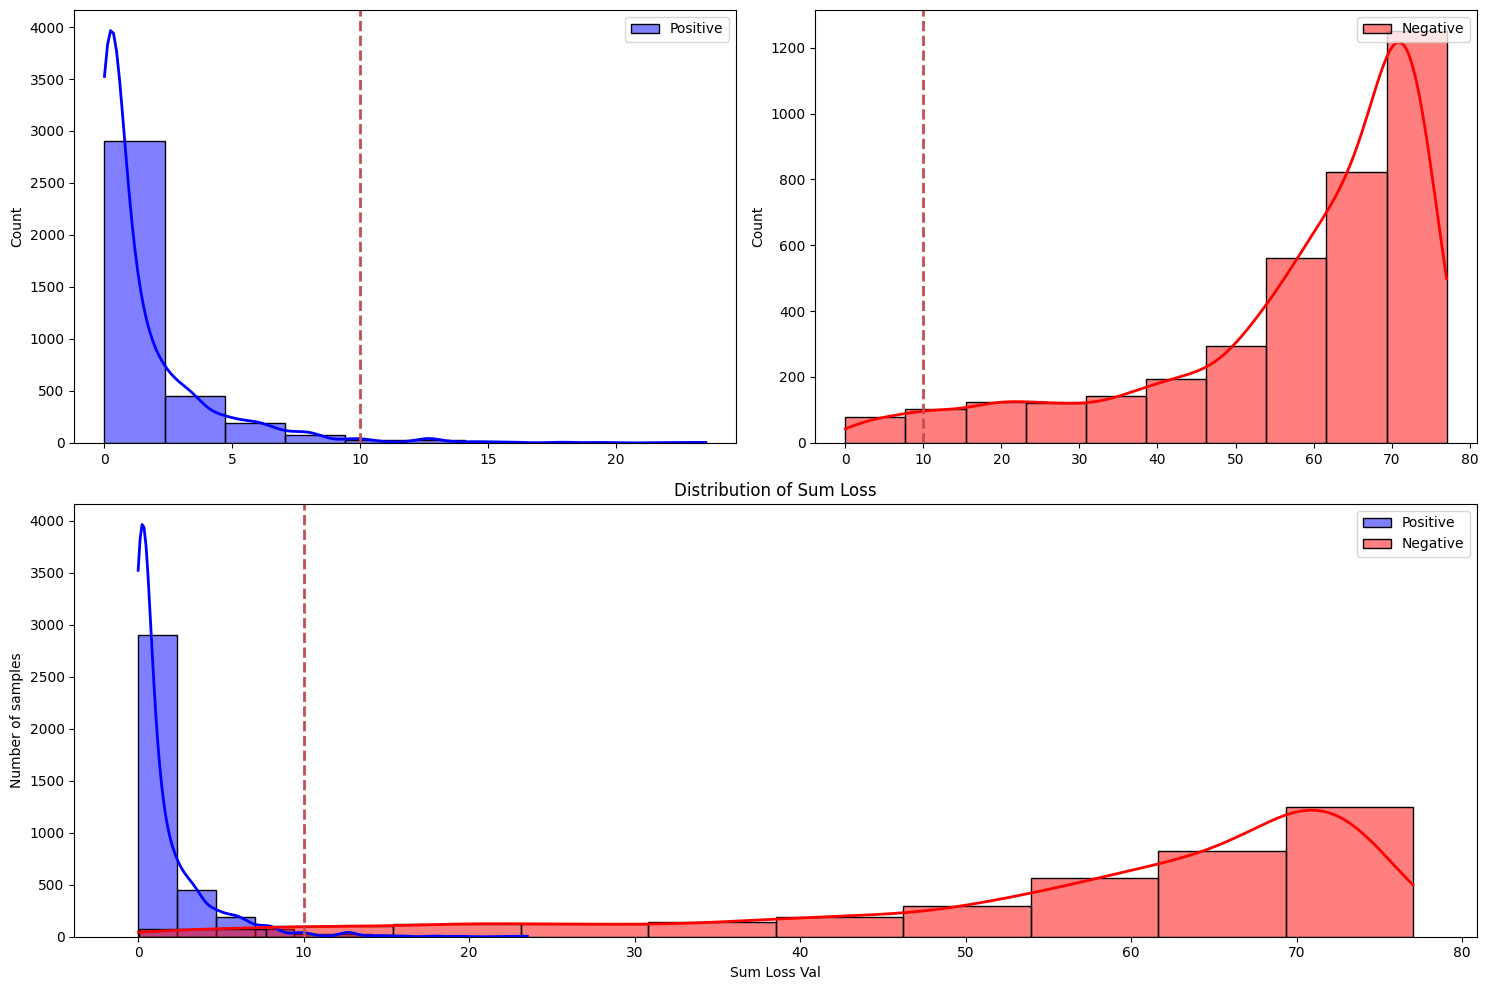

In [26]:
pos_loss, neg_loss = sumloss_visualize(val_triplets, type_name='Val', threshold=10)


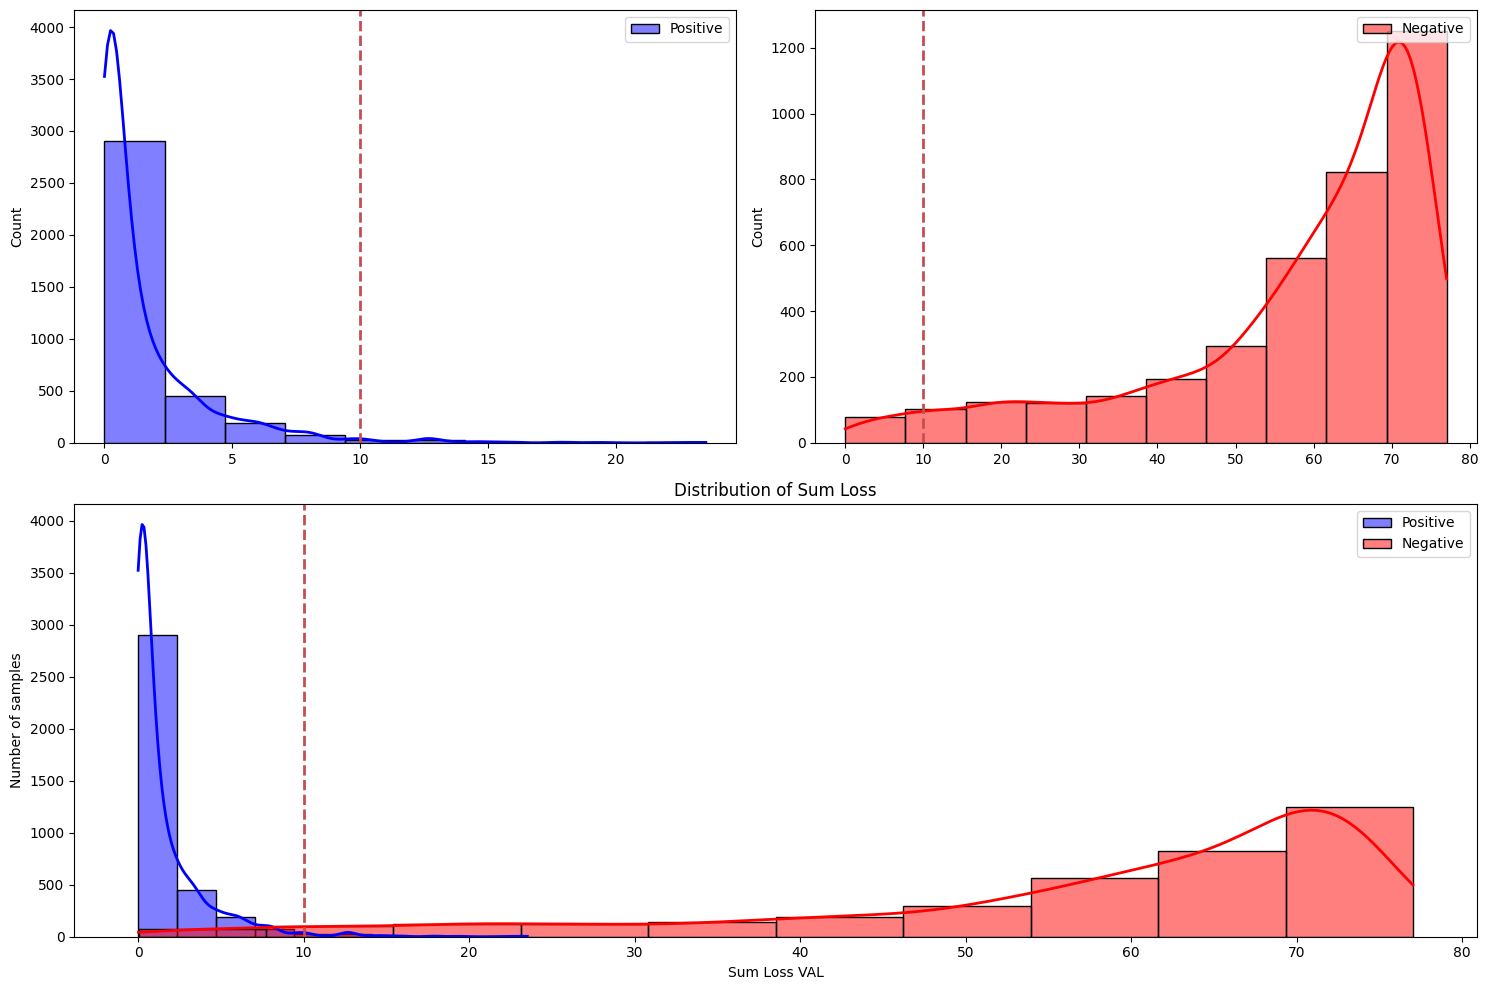

In [27]:
fig = plt.figure(figsize=(15,10))
axes = fig.subplot_mosaic("""AB
                            CC
                            """)

plt.title('Distribution of Sum Loss')
plt.xlabel(f'Sum Loss VAL')
plt.ylabel('Number of samples')

sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["A"], color='blue');

axes["A"].legend(loc='upper right')

sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["B"], color='red');

axes["B"].legend(loc='upper right')

sns.histplot(pos_loss, bins=10, kde=True, label="Positive", ax=axes["C"],  color='blue')
sns.histplot(neg_loss, bins=10, kde=True, label="Negative", ax=axes["C"],  color='red')

axes["C"].legend(loc='upper right')
threshold=10
if threshold is not None:
    axes["A"].axvline(x=threshold, color='r', linestyle='--')
    axes["B"].axvline(x=threshold, color='r', linestyle='--')
    axes["C"].axvline(x=threshold, color='r', linestyle='--')

plt.tight_layout()
plt.show()


  0%|          | 0/1819 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 3/1819 [00:00<01:08, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 6/1819 [00:00<01:10, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 9/1819 [00:00<01:07, 26.91it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 12/1819 [00:00<01:05, 27.62it/s]

1/1 [==============================] - 0s 11ms/step


  1%|          | 15/1819 [00:00<01:06, 27.18it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 18/1819 [00:00<01:05, 27.41it/s]

1/1 [==============================] - 0s 13ms/step


  1%|          | 21/1819 [00:00<01:09, 26.00it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏         | 24/1819 [00:00<01:07, 26.46it/s]

1/1 [==============================] - 0s 13ms/step


  1%|▏         | 27/1819 [00:01<01:06, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 30/1819 [00:01<01:06, 27.08it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 33/1819 [00:01<01:06, 26.90it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 36/1819 [00:01<01:05, 27.15it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 39/1819 [00:01<01:05, 27.25it/s]

1/1 [==============================] - 0s 13ms/step


  2%|▏         | 42/1819 [00:01<01:04, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 45/1819 [00:01<01:05, 27.20it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 48/1819 [00:01<01:04, 27.51it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 51/1819 [00:01<01:04, 27.58it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 54/1819 [00:01<01:04, 27.18it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 57/1819 [00:02<01:04, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 60/1819 [00:02<01:04, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 63/1819 [00:02<01:08, 25.77it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▎         | 66/1819 [00:02<01:06, 26.35it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 69/1819 [00:02<01:06, 26.47it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 72/1819 [00:02<01:04, 27.13it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 75/1819 [00:02<01:02, 27.68it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 78/1819 [00:02<01:03, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


  4%|▍         | 81/1819 [00:02<01:02, 27.85it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 84/1819 [00:03<01:02, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 87/1819 [00:03<01:02, 27.52it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▍         | 90/1819 [00:03<01:02, 27.74it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 93/1819 [00:03<01:03, 27.06it/s]

1/1 [==============================] - 0s 12ms/step


  5%|▌         | 96/1819 [00:03<01:04, 26.90it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 99/1819 [00:03<01:03, 27.07it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 102/1819 [00:03<01:07, 25.45it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 105/1819 [00:03<01:04, 26.51it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▌         | 108/1819 [00:03<01:03, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 111/1819 [00:04<01:03, 26.99it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▋         | 114/1819 [00:04<01:02, 27.36it/s]

1/1 [==============================] - 0s 13ms/step


  6%|▋         | 117/1819 [00:04<01:02, 27.25it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 120/1819 [00:04<01:02, 27.39it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 123/1819 [00:04<01:02, 27.27it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 126/1819 [00:04<01:01, 27.34it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 129/1819 [00:04<01:01, 27.45it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 132/1819 [00:04<01:01, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


  7%|▋         | 135/1819 [00:04<01:01, 27.48it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 138/1819 [00:05<01:04, 26.09it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 141/1819 [00:05<01:03, 26.35it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 144/1819 [00:05<01:01, 27.19it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 147/1819 [00:05<01:00, 27.50it/s]

1/1 [==============================] - 0s 11ms/step


  8%|▊         | 150/1819 [00:05<00:59, 28.03it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 154/1819 [00:05<00:57, 28.81it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 157/1819 [00:05<00:57, 28.97it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 160/1819 [00:05<00:57, 29.08it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 163/1819 [00:05<00:57, 28.68it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 166/1819 [00:06<00:57, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


  9%|▉         | 169/1819 [00:06<00:58, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 173/1819 [00:06<00:57, 28.70it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 176/1819 [00:06<00:56, 28.88it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 180/1819 [00:06<00:55, 29.41it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 183/1819 [00:06<00:56, 28.79it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 186/1819 [00:06<00:56, 28.94it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 189/1819 [00:06<00:56, 28.90it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 192/1819 [00:06<00:56, 28.79it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 195/1819 [00:07<00:55, 29.12it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 198/1819 [00:07<00:56, 28.78it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█         | 201/1819 [00:07<00:56, 28.54it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█▏        | 205/1819 [00:07<00:55, 28.96it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█▏        | 208/1819 [00:07<00:55, 29.15it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 211/1819 [00:07<00:55, 28.89it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 214/1819 [00:07<00:55, 28.70it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 217/1819 [00:07<00:56, 28.18it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 221/1819 [00:07<00:55, 28.68it/s]

1/1 [==============================] - 0s 13ms/step


 12%|█▏        | 224/1819 [00:08<00:55, 28.71it/s]

1/1 [==============================] - 0s 12ms/step


 12%|█▏        | 227/1819 [00:08<00:55, 28.74it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 230/1819 [00:08<00:54, 28.91it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 233/1819 [00:08<00:55, 28.72it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 236/1819 [00:08<00:55, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 239/1819 [00:08<00:56, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 242/1819 [00:08<00:56, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 245/1819 [00:08<00:56, 27.62it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▎        | 248/1819 [00:08<00:57, 27.50it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 251/1819 [00:09<00:56, 27.80it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 254/1819 [00:09<00:56, 27.78it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 257/1819 [00:09<00:55, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 261/1819 [00:09<00:54, 28.72it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 265/1819 [00:09<00:53, 29.27it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 269/1819 [00:09<00:52, 29.46it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 272/1819 [00:09<00:52, 29.58it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 275/1819 [00:09<00:52, 29.44it/s]

1/1 [==============================] - 0s 11ms/step


 15%|█▌        | 278/1819 [00:09<00:53, 28.64it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▌        | 281/1819 [00:10<00:53, 29.00it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 284/1819 [00:10<00:53, 28.94it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 287/1819 [00:10<00:53, 28.58it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 290/1819 [00:10<00:56, 26.87it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 293/1819 [00:10<00:56, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 296/1819 [00:10<00:55, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▋        | 299/1819 [00:10<00:54, 27.99it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 302/1819 [00:10<00:54, 27.78it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 305/1819 [00:10<00:53, 28.31it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 308/1819 [00:11<00:52, 28.54it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 311/1819 [00:11<00:53, 28.19it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 314/1819 [00:11<00:52, 28.61it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 317/1819 [00:11<00:52, 28.75it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 321/1819 [00:11<00:51, 29.14it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 324/1819 [00:11<00:52, 28.58it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 327/1819 [00:11<00:53, 27.99it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 330/1819 [00:11<00:52, 28.38it/s]

1/1 [==============================] - 0s 11ms/step


 18%|█▊        | 333/1819 [00:11<00:52, 28.13it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 336/1819 [00:12<00:53, 27.49it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 339/1819 [00:12<00:54, 27.05it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 342/1819 [00:12<00:54, 26.96it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 345/1819 [00:12<00:53, 27.33it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 348/1819 [00:12<00:53, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 351/1819 [00:12<00:54, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 354/1819 [00:12<00:52, 27.70it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 357/1819 [00:12<00:53, 27.30it/s]

1/1 [==============================] - 0s 13ms/step


 20%|█▉        | 360/1819 [00:12<00:54, 26.56it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 363/1819 [00:13<00:56, 25.87it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 366/1819 [00:13<00:56, 25.79it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 369/1819 [00:13<00:56, 25.67it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 372/1819 [00:13<00:56, 25.62it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██        | 375/1819 [00:13<00:56, 25.55it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 378/1819 [00:13<00:56, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 21%|██        | 381/1819 [00:13<00:56, 25.65it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 384/1819 [00:13<00:56, 25.51it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██▏       | 387/1819 [00:14<00:56, 25.33it/s]

1/1 [==============================] - 0s 13ms/step


 21%|██▏       | 390/1819 [00:14<00:55, 25.64it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 393/1819 [00:14<00:58, 24.50it/s]

1/1 [==============================] - 0s 11ms/step


 22%|██▏       | 396/1819 [00:14<00:57, 24.95it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 399/1819 [00:14<00:55, 25.60it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 402/1819 [00:14<00:53, 26.27it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 405/1819 [00:14<00:54, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 408/1819 [00:14<00:53, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 411/1819 [00:14<00:52, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 414/1819 [00:15<00:51, 27.19it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 417/1819 [00:15<00:50, 27.73it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 420/1819 [00:15<00:49, 28.12it/s]

1/1 [==============================] - 0s 12ms/step


 23%|██▎       | 423/1819 [00:15<00:49, 27.93it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 426/1819 [00:15<00:49, 27.90it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 429/1819 [00:15<00:50, 27.39it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▎       | 432/1819 [00:15<00:50, 27.27it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▍       | 435/1819 [00:15<00:50, 27.56it/s]

1/1 [==============================] - 0s 12ms/step


 24%|██▍       | 438/1819 [00:15<00:49, 27.69it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▍       | 441/1819 [00:16<00:49, 27.94it/s]

1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 444/1819 [00:16<00:48, 28.27it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 447/1819 [00:16<00:49, 27.85it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 450/1819 [00:16<00:49, 27.47it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 453/1819 [00:16<00:49, 27.55it/s]

1/1 [==============================] - 0s 11ms/step


 25%|██▌       | 456/1819 [00:16<00:48, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 459/1819 [00:16<00:47, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 462/1819 [00:16<01:10, 19.15it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 465/1819 [00:17<01:07, 20.15it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 468/1819 [00:17<01:02, 21.76it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 471/1819 [00:17<00:58, 22.90it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 474/1819 [00:17<00:55, 24.14it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 477/1819 [00:17<00:53, 24.99it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▋       | 480/1819 [00:17<00:52, 25.38it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 483/1819 [00:17<00:50, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 486/1819 [00:17<00:50, 26.54it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 489/1819 [00:17<00:49, 26.85it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 492/1819 [00:18<00:49, 26.82it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 495/1819 [00:18<00:49, 26.52it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 498/1819 [00:18<00:50, 26.38it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 501/1819 [00:18<00:52, 25.29it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 504/1819 [00:18<00:52, 25.26it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 507/1819 [00:18<00:51, 25.46it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 510/1819 [00:18<00:50, 25.82it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 513/1819 [00:18<00:50, 25.75it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 516/1819 [00:18<00:50, 25.91it/s]

1/1 [==============================] - 0s 13ms/step


 29%|██▊       | 519/1819 [00:19<00:50, 25.76it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▊       | 522/1819 [00:19<00:49, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 525/1819 [00:19<00:49, 26.11it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▉       | 528/1819 [00:19<00:50, 25.37it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 531/1819 [00:19<00:50, 25.72it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 534/1819 [00:19<00:50, 25.62it/s]

1/1 [==============================] - 0s 13ms/step


 30%|██▉       | 537/1819 [00:19<00:48, 26.43it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 540/1819 [00:19<00:48, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 543/1819 [00:20<00:49, 26.01it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 546/1819 [00:20<00:48, 26.46it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 549/1819 [00:20<00:47, 26.83it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 552/1819 [00:20<00:46, 27.03it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███       | 555/1819 [00:20<00:46, 26.94it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 558/1819 [00:20<00:48, 26.18it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 561/1819 [00:20<00:48, 26.15it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 564/1819 [00:20<00:49, 25.33it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███       | 567/1819 [00:20<00:49, 25.19it/s]

1/1 [==============================] - 0s 13ms/step


 31%|███▏      | 570/1819 [00:21<00:48, 25.88it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 573/1819 [00:21<00:46, 26.57it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 576/1819 [00:21<00:47, 26.28it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 579/1819 [00:21<00:46, 26.56it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 582/1819 [00:21<00:47, 26.06it/s]

1/1 [==============================] - 0s 12ms/step


 32%|███▏      | 585/1819 [00:21<00:47, 26.06it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 588/1819 [00:21<00:46, 26.37it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 591/1819 [00:21<00:46, 26.44it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 594/1819 [00:21<00:47, 26.00it/s]

1/1 [==============================] - 0s 12ms/step


 33%|███▎      | 597/1819 [00:22<00:46, 26.50it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 600/1819 [00:22<00:46, 26.26it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 603/1819 [00:22<00:47, 25.47it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 606/1819 [00:22<00:46, 25.90it/s]

1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 609/1819 [00:22<00:47, 25.59it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▎      | 612/1819 [00:22<00:47, 25.59it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███▍      | 615/1819 [00:22<00:47, 25.55it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███▍      | 618/1819 [00:22<00:46, 26.07it/s]

1/1 [==============================] - 0s 13ms/step


 34%|███▍      | 621/1819 [00:23<00:45, 26.41it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 624/1819 [00:23<00:45, 26.44it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 627/1819 [00:23<00:45, 26.15it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 630/1819 [00:23<00:44, 26.54it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 633/1819 [00:23<00:45, 26.32it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▍      | 636/1819 [00:23<00:45, 26.24it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 639/1819 [00:23<00:46, 25.46it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 642/1819 [00:23<00:46, 25.57it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▌      | 645/1819 [00:23<00:45, 25.78it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███▌      | 648/1819 [00:24<00:45, 25.92it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 651/1819 [00:24<00:45, 25.83it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███▌      | 654/1819 [00:24<00:45, 25.57it/s]

1/1 [==============================] - 0s 12ms/step


 36%|███▌      | 657/1819 [00:24<00:44, 26.18it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███▋      | 660/1819 [00:24<00:44, 26.15it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███▋      | 663/1819 [00:24<00:43, 26.40it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 666/1819 [00:24<00:43, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 669/1819 [00:24<00:43, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 672/1819 [00:24<00:43, 26.31it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 675/1819 [00:25<00:43, 26.23it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 678/1819 [00:25<00:45, 25.13it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 681/1819 [00:25<00:44, 25.34it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 684/1819 [00:25<00:43, 26.15it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 687/1819 [00:25<00:42, 26.50it/s]

1/1 [==============================] - 0s 12ms/step


 38%|███▊      | 690/1819 [00:25<00:41, 27.00it/s]

1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 693/1819 [00:25<00:42, 26.29it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 696/1819 [00:25<00:43, 26.09it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 699/1819 [00:25<00:42, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███▊      | 702/1819 [00:26<00:42, 26.40it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 705/1819 [00:26<00:43, 25.87it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 708/1819 [00:26<00:42, 26.30it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 711/1819 [00:26<00:42, 26.36it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 714/1819 [00:26<00:41, 26.41it/s]

1/1 [==============================] - 0s 13ms/step


 39%|███▉      | 717/1819 [00:26<00:43, 25.38it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███▉      | 720/1819 [00:26<00:42, 25.78it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███▉      | 723/1819 [00:26<00:42, 25.79it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███▉      | 726/1819 [00:27<00:41, 26.28it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 729/1819 [00:27<00:41, 26.21it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 732/1819 [00:27<00:41, 26.37it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 735/1819 [00:27<00:40, 26.63it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████      | 738/1819 [00:27<00:40, 26.45it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 741/1819 [00:27<00:40, 26.61it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 744/1819 [00:27<00:40, 26.65it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████      | 747/1819 [00:27<00:41, 25.99it/s]

1/1 [==============================] - 0s 12ms/step


 41%|████      | 750/1819 [00:27<00:41, 25.72it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 753/1819 [00:28<00:42, 25.17it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 756/1819 [00:28<00:41, 25.76it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████▏     | 759/1819 [00:28<00:41, 25.63it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 762/1819 [00:28<00:41, 25.76it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 765/1819 [00:28<00:40, 26.32it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 769/1819 [00:28<00:37, 27.67it/s]

1/1 [==============================] - 0s 12ms/step


 42%|████▏     | 772/1819 [00:28<00:37, 27.91it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 775/1819 [00:28<00:37, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 778/1819 [00:28<00:36, 28.31it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████▎     | 781/1819 [00:29<00:37, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 784/1819 [00:29<00:36, 28.17it/s]

1/1 [==============================] - 0s 13ms/step


 43%|████▎     | 787/1819 [00:29<00:35, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 790/1819 [00:29<00:36, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▎     | 793/1819 [00:29<00:36, 28.40it/s]

1/1 [==============================] - 0s 11ms/step


 44%|████▍     | 796/1819 [00:29<00:36, 28.35it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 799/1819 [00:29<00:35, 28.81it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 802/1819 [00:29<00:36, 28.24it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 805/1819 [00:29<00:36, 27.63it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 808/1819 [00:30<00:36, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▍     | 811/1819 [00:30<00:36, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 814/1819 [00:30<00:35, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▍     | 817/1819 [00:30<00:35, 28.24it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▌     | 820/1819 [00:30<00:36, 27.70it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▌     | 823/1819 [00:30<00:36, 27.33it/s]

1/1 [==============================] - 0s 13ms/step


 45%|████▌     | 826/1819 [00:30<00:36, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 829/1819 [00:30<00:35, 27.59it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 832/1819 [00:30<00:36, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 835/1819 [00:31<00:35, 27.58it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 838/1819 [00:31<00:35, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 841/1819 [00:31<00:35, 27.83it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▋     | 844/1819 [00:31<00:34, 28.29it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 847/1819 [00:31<00:34, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 850/1819 [00:31<00:34, 28.49it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 853/1819 [00:31<00:34, 28.38it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 856/1819 [00:31<00:33, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 859/1819 [00:31<00:35, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 862/1819 [00:31<00:34, 27.90it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 865/1819 [00:32<00:33, 28.16it/s]

1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 868/1819 [00:32<00:33, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 871/1819 [00:32<00:33, 28.54it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 874/1819 [00:32<00:32, 28.95it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 878/1819 [00:32<00:32, 29.03it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 881/1819 [00:32<00:32, 29.20it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▊     | 884/1819 [00:32<00:31, 29.33it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 887/1819 [00:32<00:32, 28.77it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 890/1819 [00:32<00:32, 28.54it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 893/1819 [00:33<00:32, 28.50it/s]

1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 896/1819 [00:33<00:32, 28.27it/s]

1/1 [==============================] - 0s 11ms/step


 49%|████▉     | 899/1819 [00:33<00:32, 28.50it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 902/1819 [00:33<00:32, 28.51it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 905/1819 [00:33<00:32, 28.52it/s]

1/1 [==============================] - 0s 13ms/step


 50%|████▉     | 908/1819 [00:33<00:31, 28.85it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 911/1819 [00:33<00:32, 28.27it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 914/1819 [00:33<00:33, 27.34it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 917/1819 [00:33<00:32, 27.76it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 920/1819 [00:34<00:32, 27.38it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████     | 923/1819 [00:34<00:33, 26.90it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 926/1819 [00:34<00:32, 27.07it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████     | 929/1819 [00:34<00:32, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 932/1819 [00:34<00:32, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████▏    | 935/1819 [00:34<00:31, 27.77it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 938/1819 [00:34<00:31, 27.91it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 941/1819 [00:34<00:31, 27.94it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 944/1819 [00:34<00:31, 28.03it/s]

1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 947/1819 [00:34<00:31, 28.10it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 950/1819 [00:35<00:31, 27.72it/s]

1/1 [==============================] - 0s 11ms/step


 52%|█████▏    | 953/1819 [00:35<00:30, 28.07it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 956/1819 [00:35<00:30, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 959/1819 [00:35<00:30, 28.31it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 962/1819 [00:35<00:30, 28.08it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 965/1819 [00:35<00:31, 26.92it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 968/1819 [00:35<00:30, 27.54it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 971/1819 [00:35<00:30, 28.02it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 974/1819 [00:35<00:30, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▎    | 977/1819 [00:36<00:29, 28.62it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 980/1819 [00:36<00:29, 28.76it/s]

1/1 [==============================] - 0s 11ms/step


 54%|█████▍    | 983/1819 [00:36<00:29, 28.82it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 987/1819 [00:36<00:28, 29.28it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 990/1819 [00:36<00:28, 29.23it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 993/1819 [00:36<00:28, 29.10it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 996/1819 [00:36<00:28, 29.10it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▍    | 999/1819 [00:36<00:28, 28.72it/s]

1/1 [==============================] - 0s 12ms/step


 55%|█████▌    | 1002/1819 [00:36<00:28, 28.50it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▌    | 1005/1819 [00:37<00:28, 28.27it/s]

1/1 [==============================] - 0s 13ms/step


 55%|█████▌    | 1008/1819 [00:37<00:28, 28.03it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 1011/1819 [00:37<00:28, 28.58it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 1014/1819 [00:37<00:28, 28.48it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 1017/1819 [00:37<00:29, 27.22it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 1020/1819 [00:37<00:28, 27.99it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▌    | 1023/1819 [00:37<00:28, 27.99it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▋    | 1026/1819 [00:37<00:28, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 1029/1819 [00:37<00:27, 28.35it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 1032/1819 [00:37<00:27, 28.27it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 1035/1819 [00:38<00:27, 28.27it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 1038/1819 [00:38<00:27, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 1041/1819 [00:38<00:27, 27.96it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 1044/1819 [00:38<00:27, 28.53it/s]

1/1 [==============================] - 0s 11ms/step


 58%|█████▊    | 1047/1819 [00:38<00:26, 28.78it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 1051/1819 [00:38<00:26, 29.23it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 1054/1819 [00:38<00:26, 29.35it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 1058/1819 [00:38<00:25, 29.78it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 1061/1819 [00:38<00:25, 29.75it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 1064/1819 [00:39<00:26, 28.77it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▊    | 1067/1819 [00:39<00:27, 27.40it/s]

1/1 [==============================] - 0s 11ms/step


 59%|█████▉    | 1070/1819 [00:39<00:27, 27.12it/s]

1/1 [==============================] - 0s 13ms/step


 59%|█████▉    | 1073/1819 [00:39<00:27, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 1076/1819 [00:39<00:26, 27.79it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 1079/1819 [00:39<00:26, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 1082/1819 [00:39<00:25, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 1085/1819 [00:39<00:25, 28.86it/s]

1/1 [==============================] - 0s 12ms/step


 60%|█████▉    | 1088/1819 [00:39<00:25, 28.63it/s]

1/1 [==============================] - 0s 11ms/step


 60%|█████▉    | 1091/1819 [00:40<00:25, 29.02it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 1094/1819 [00:40<00:24, 29.16it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 1097/1819 [00:40<00:24, 28.97it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 1100/1819 [00:40<00:24, 29.25it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 1103/1819 [00:40<00:24, 29.03it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 1106/1819 [00:40<00:24, 29.22it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 1109/1819 [00:40<00:24, 29.01it/s]

1/1 [==============================] - 0s 13ms/step


 61%|██████    | 1112/1819 [00:40<00:24, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████▏   | 1116/1819 [00:40<00:24, 29.02it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 1119/1819 [00:41<00:25, 27.97it/s]

1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 1122/1819 [00:41<00:24, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 1125/1819 [00:41<00:24, 28.64it/s]

1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 1128/1819 [00:41<00:24, 28.77it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 1131/1819 [00:41<00:23, 29.02it/s]

1/1 [==============================] - 0s 12ms/step


 62%|██████▏   | 1134/1819 [00:41<00:23, 29.11it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 1137/1819 [00:41<00:23, 29.02it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 1140/1819 [00:41<00:23, 29.29it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 1143/1819 [00:41<00:23, 28.40it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1146/1819 [00:41<00:23, 28.12it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 1149/1819 [00:42<00:23, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 1152/1819 [00:42<00:23, 28.20it/s]

1/1 [==============================] - 0s 11ms/step


 64%|██████▎   | 1156/1819 [00:42<00:22, 29.19it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 1159/1819 [00:42<00:22, 29.08it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 1162/1819 [00:42<00:22, 29.16it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 1165/1819 [00:42<00:22, 29.30it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 1168/1819 [00:42<00:22, 28.99it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▍   | 1171/1819 [00:42<00:23, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 1174/1819 [00:42<00:22, 28.08it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▍   | 1177/1819 [00:43<00:22, 28.45it/s]

1/1 [==============================] - 0s 13ms/step


 65%|██████▍   | 1180/1819 [00:43<00:22, 28.55it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 1183/1819 [00:43<00:22, 28.42it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 1186/1819 [00:43<00:22, 28.45it/s]

1/1 [==============================] - 0s 12ms/step


 65%|██████▌   | 1189/1819 [00:43<00:22, 28.48it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 1192/1819 [00:43<00:22, 28.49it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 1195/1819 [00:43<00:21, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 1198/1819 [00:43<00:21, 28.62it/s]

1/1 [==============================] - 0s 13ms/step


 66%|██████▌   | 1202/1819 [00:43<00:21, 29.28it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 1205/1819 [00:44<00:21, 29.23it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▋   | 1208/1819 [00:44<00:22, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 1211/1819 [00:44<00:21, 27.91it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 1214/1819 [00:44<00:21, 28.32it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 1217/1819 [00:44<00:20, 28.70it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 1220/1819 [00:44<00:20, 29.06it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 1223/1819 [00:44<00:20, 29.06it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 1226/1819 [00:44<00:20, 28.53it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 1229/1819 [00:44<00:21, 27.82it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 1232/1819 [00:44<00:20, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 1235/1819 [00:45<00:20, 28.64it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 1238/1819 [00:45<00:20, 28.77it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 1241/1819 [00:45<00:19, 28.94it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 1244/1819 [00:45<00:20, 27.40it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 1247/1819 [00:45<00:20, 27.93it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▊   | 1250/1819 [00:45<00:20, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 1253/1819 [00:45<00:20, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 1256/1819 [00:45<00:20, 28.10it/s]

1/1 [==============================] - 0s 13ms/step


 69%|██████▉   | 1259/1819 [00:45<00:19, 28.39it/s]

1/1 [==============================] - 0s 11ms/step


 69%|██████▉   | 1262/1819 [00:46<00:19, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 1265/1819 [00:46<00:19, 28.63it/s]

1/1 [==============================] - 0s 11ms/step


 70%|██████▉   | 1268/1819 [00:46<00:19, 28.74it/s]

1/1 [==============================] - 0s 13ms/step


 70%|██████▉   | 1271/1819 [00:46<00:18, 28.85it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 1275/1819 [00:46<00:18, 29.47it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 1278/1819 [00:46<00:18, 29.28it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 1281/1819 [00:46<00:18, 29.20it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 1284/1819 [00:46<00:19, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 1287/1819 [00:46<00:19, 27.55it/s]

1/1 [==============================] - 0s 12ms/step


 71%|███████   | 1290/1819 [00:47<00:18, 27.98it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████   | 1293/1819 [00:47<00:18, 27.98it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████   | 1296/1819 [00:47<00:18, 27.76it/s]

1/1 [==============================] - 0s 11ms/step


 71%|███████▏  | 1299/1819 [00:47<00:18, 27.94it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 1302/1819 [00:47<00:18, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 72%|███████▏  | 1306/1819 [00:47<00:17, 28.67it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 1309/1819 [00:47<00:17, 28.94it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 1312/1819 [00:47<00:17, 28.82it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 1315/1819 [00:47<00:17, 28.11it/s]

1/1 [==============================] - 0s 13ms/step


 72%|███████▏  | 1318/1819 [00:48<00:19, 26.28it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 1321/1819 [00:48<00:18, 26.59it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 1324/1819 [00:48<00:18, 27.09it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 1327/1819 [00:48<00:17, 27.73it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 1330/1819 [00:48<00:17, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 1333/1819 [00:48<00:17, 28.03it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 1336/1819 [00:48<00:17, 27.71it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▎  | 1340/1819 [00:48<00:16, 28.52it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 1343/1819 [00:48<00:16, 28.68it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 1346/1819 [00:49<00:16, 28.87it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 1349/1819 [00:49<00:16, 28.38it/s]

1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 1352/1819 [00:49<00:17, 27.15it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 1355/1819 [00:49<00:16, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 1358/1819 [00:49<00:16, 27.65it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▍  | 1361/1819 [00:49<00:16, 27.87it/s]

1/1 [==============================] - 0s 13ms/step


 75%|███████▍  | 1364/1819 [00:49<00:16, 27.75it/s]

1/1 [==============================] - 0s 14ms/step


 75%|███████▌  | 1367/1819 [00:49<00:16, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 1370/1819 [00:49<00:16, 27.43it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 1373/1819 [00:50<00:16, 27.52it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 1376/1819 [00:50<00:23, 19.09it/s]

1/1 [==============================] - 0s 12ms/step


 76%|███████▌  | 1380/1819 [00:50<00:19, 21.97it/s]

1/1 [==============================] - 0s 13ms/step


 76%|███████▌  | 1383/1819 [00:50<00:18, 22.98it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 1387/1819 [00:50<00:17, 24.47it/s]

1/1 [==============================] - 0s 11ms/step


 76%|███████▋  | 1390/1819 [00:50<00:16, 25.60it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 1393/1819 [00:50<00:16, 26.35it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 1396/1819 [00:51<00:15, 26.53it/s]

1/1 [==============================] - 0s 11ms/step


 77%|███████▋  | 1399/1819 [00:51<00:15, 26.31it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 1402/1819 [00:51<00:15, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 1405/1819 [00:51<00:15, 27.43it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 1408/1819 [00:51<00:15, 27.23it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 1411/1819 [00:51<00:14, 27.83it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 1414/1819 [00:51<00:14, 28.19it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 1417/1819 [00:51<00:14, 28.13it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 1420/1819 [00:51<00:14, 26.95it/s]

1/1 [==============================] - 0s 12ms/step


 78%|███████▊  | 1423/1819 [00:51<00:14, 27.33it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 1426/1819 [00:52<00:14, 27.87it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 1429/1819 [00:52<00:13, 28.22it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▊  | 1432/1819 [00:52<00:13, 28.31it/s]

1/1 [==============================] - 0s 11ms/step


 79%|███████▉  | 1435/1819 [00:52<00:13, 28.70it/s]

1/1 [==============================] - 0s 13ms/step


 79%|███████▉  | 1438/1819 [00:52<00:13, 28.57it/s]

1/1 [==============================] - 0s 12ms/step


 79%|███████▉  | 1441/1819 [00:52<00:13, 28.39it/s]

1/1 [==============================] - 0s 11ms/step


 79%|███████▉  | 1444/1819 [00:52<00:13, 28.76it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 1447/1819 [00:52<00:13, 28.05it/s]

1/1 [==============================] - 0s 13ms/step


 80%|███████▉  | 1450/1819 [00:52<00:13, 28.35it/s]

1/1 [==============================] - 0s 11ms/step


 80%|███████▉  | 1453/1819 [00:53<00:12, 28.16it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 1456/1819 [00:53<00:13, 26.56it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 1459/1819 [00:53<00:13, 27.19it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 1462/1819 [00:53<00:12, 27.96it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 1465/1819 [00:53<00:12, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 1468/1819 [00:53<00:12, 28.43it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 1471/1819 [00:53<00:12, 28.14it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 1474/1819 [00:53<00:12, 28.66it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████▏ | 1478/1819 [00:53<00:11, 29.11it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████▏ | 1481/1819 [00:54<00:11, 29.03it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 1484/1819 [00:54<00:11, 28.80it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 1487/1819 [00:54<00:11, 28.18it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 1490/1819 [00:54<00:12, 27.01it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 1493/1819 [00:54<00:11, 27.30it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 1496/1819 [00:54<00:11, 27.28it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 1499/1819 [00:54<00:11, 27.30it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 1502/1819 [00:54<00:11, 27.96it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 1505/1819 [00:54<00:11, 27.74it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 1508/1819 [00:54<00:10, 28.29it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 1511/1819 [00:55<00:10, 28.60it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 1514/1819 [00:55<00:10, 28.74it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 1517/1819 [00:55<00:10, 29.09it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 1520/1819 [00:55<00:10, 28.84it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▎ | 1523/1819 [00:55<00:10, 27.80it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 1526/1819 [00:55<00:10, 28.41it/s]

1/1 [==============================] - 0s 11ms/step


 84%|████████▍ | 1529/1819 [00:55<00:10, 28.61it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 1533/1819 [00:55<00:09, 29.27it/s]

1/1 [==============================] - 0s 12ms/step


 84%|████████▍ | 1536/1819 [00:55<00:09, 28.67it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▍ | 1540/1819 [00:56<00:09, 29.03it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 1543/1819 [00:56<00:09, 28.37it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 1547/1819 [00:56<00:09, 29.12it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 1550/1819 [00:56<00:09, 28.89it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▌ | 1553/1819 [00:56<00:09, 28.48it/s]

1/1 [==============================] - 0s 11ms/step


 86%|████████▌ | 1556/1819 [00:56<00:09, 28.04it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 1559/1819 [00:56<00:09, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▌ | 1562/1819 [00:56<00:09, 27.68it/s]

1/1 [==============================] - 0s 11ms/step


 86%|████████▌ | 1565/1819 [00:57<00:09, 28.00it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 1568/1819 [00:57<00:09, 27.47it/s]

1/1 [==============================] - 0s 12ms/step


 86%|████████▋ | 1571/1819 [00:57<00:08, 27.78it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 1574/1819 [00:57<00:08, 27.99it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 1577/1819 [00:57<00:08, 27.72it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 1580/1819 [00:57<00:08, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 1583/1819 [00:57<00:08, 28.17it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 1586/1819 [00:57<00:08, 28.27it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 1589/1819 [00:57<00:08, 26.98it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 1592/1819 [00:57<00:08, 27.35it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 1595/1819 [00:58<00:07, 28.08it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 1598/1819 [00:58<00:07, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 1601/1819 [00:58<00:07, 28.36it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 1604/1819 [00:58<00:07, 28.81it/s]

1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 1607/1819 [00:58<00:07, 29.06it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▊ | 1610/1819 [00:58<00:07, 28.94it/s]

1/1 [==============================] - 0s 11ms/step


 89%|████████▊ | 1613/1819 [00:58<00:07, 29.23it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 1616/1819 [00:58<00:07, 28.58it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 1619/1819 [00:58<00:06, 28.81it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 1622/1819 [00:59<00:06, 29.06it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 1625/1819 [00:59<00:07, 27.41it/s]

1/1 [==============================] - 0s 13ms/step


 89%|████████▉ | 1628/1819 [00:59<00:06, 27.66it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 1631/1819 [00:59<00:06, 27.45it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 1634/1819 [00:59<00:06, 28.16it/s]

1/1 [==============================] - 0s 12ms/step


 90%|████████▉ | 1637/1819 [00:59<00:06, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 1640/1819 [00:59<00:06, 27.68it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 1643/1819 [00:59<00:06, 28.32it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 1646/1819 [00:59<00:06, 28.47it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████ | 1649/1819 [00:59<00:06, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 1652/1819 [01:00<00:06, 27.81it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 1655/1819 [01:00<00:06, 26.75it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 1659/1819 [01:00<00:05, 27.94it/s]

1/1 [==============================] - 0s 13ms/step


 91%|█████████▏| 1662/1819 [01:00<00:05, 28.25it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 1665/1819 [01:00<00:05, 28.10it/s]

1/1 [==============================] - 0s 11ms/step


 92%|█████████▏| 1668/1819 [01:00<00:05, 28.53it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 1671/1819 [01:00<00:05, 28.06it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 1674/1819 [01:00<00:05, 28.59it/s]

1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 1677/1819 [01:00<00:05, 28.10it/s]

1/1 [==============================] - 0s 13ms/step


 92%|█████████▏| 1680/1819 [01:01<00:05, 27.75it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 1683/1819 [01:01<00:04, 27.60it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 1686/1819 [01:01<00:04, 26.67it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 1689/1819 [01:01<00:04, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 1692/1819 [01:01<00:04, 27.14it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 1695/1819 [01:01<00:04, 27.53it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 1698/1819 [01:01<00:04, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▎| 1701/1819 [01:01<00:04, 28.11it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████▎| 1704/1819 [01:01<00:04, 28.00it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 1708/1819 [01:02<00:03, 28.68it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████▍| 1711/1819 [01:02<00:03, 28.41it/s]

1/1 [==============================] - 0s 12ms/step


 94%|█████████▍| 1714/1819 [01:02<00:03, 28.29it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 1717/1819 [01:02<00:03, 27.13it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 1720/1819 [01:02<00:03, 27.38it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▍| 1723/1819 [01:02<00:03, 27.63it/s]

1/1 [==============================] - 0s 13ms/step


 95%|█████████▍| 1727/1819 [01:02<00:03, 27.89it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 1731/1819 [01:02<00:03, 28.69it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 1734/1819 [01:03<00:02, 28.56it/s]

1/1 [==============================] - 0s 12ms/step


 95%|█████████▌| 1737/1819 [01:03<00:02, 28.11it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 1740/1819 [01:03<00:02, 27.95it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 1743/1819 [01:03<00:02, 28.26it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 1746/1819 [01:03<00:02, 28.34it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▌| 1749/1819 [01:03<00:02, 27.41it/s]

1/1 [==============================] - 0s 12ms/step


 96%|█████████▋| 1752/1819 [01:03<00:02, 27.14it/s]

1/1 [==============================] - 0s 11ms/step


 96%|█████████▋| 1755/1819 [01:03<00:02, 27.92it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 1758/1819 [01:03<00:02, 28.49it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 1761/1819 [01:03<00:02, 28.34it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 1764/1819 [01:04<00:01, 28.56it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 1767/1819 [01:04<00:01, 27.42it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 1770/1819 [01:04<00:01, 28.05it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 1773/1819 [01:04<00:01, 28.35it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 1776/1819 [01:04<00:01, 27.70it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 1779/1819 [01:04<00:01, 26.47it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 1782/1819 [01:04<00:01, 26.78it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 1785/1819 [01:04<00:01, 27.21it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 1788/1819 [01:04<00:01, 27.74it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 1791/1819 [01:05<00:01, 27.59it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▊| 1794/1819 [01:05<00:00, 27.86it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 1797/1819 [01:05<00:00, 27.77it/s]

1/1 [==============================] - 0s 11ms/step


 99%|█████████▉| 1800/1819 [01:05<00:00, 27.61it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 1804/1819 [01:05<00:00, 28.09it/s]

1/1 [==============================] - 0s 12ms/step


 99%|█████████▉| 1807/1819 [01:05<00:00, 28.21it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 1810/1819 [01:05<00:00, 27.49it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 1813/1819 [01:05<00:00, 28.01it/s]

1/1 [==============================] - 0s 12ms/step


100%|█████████▉| 1816/1819 [01:05<00:00, 28.39it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 1819/1819 [01:06<00:00, 27.53it/s]


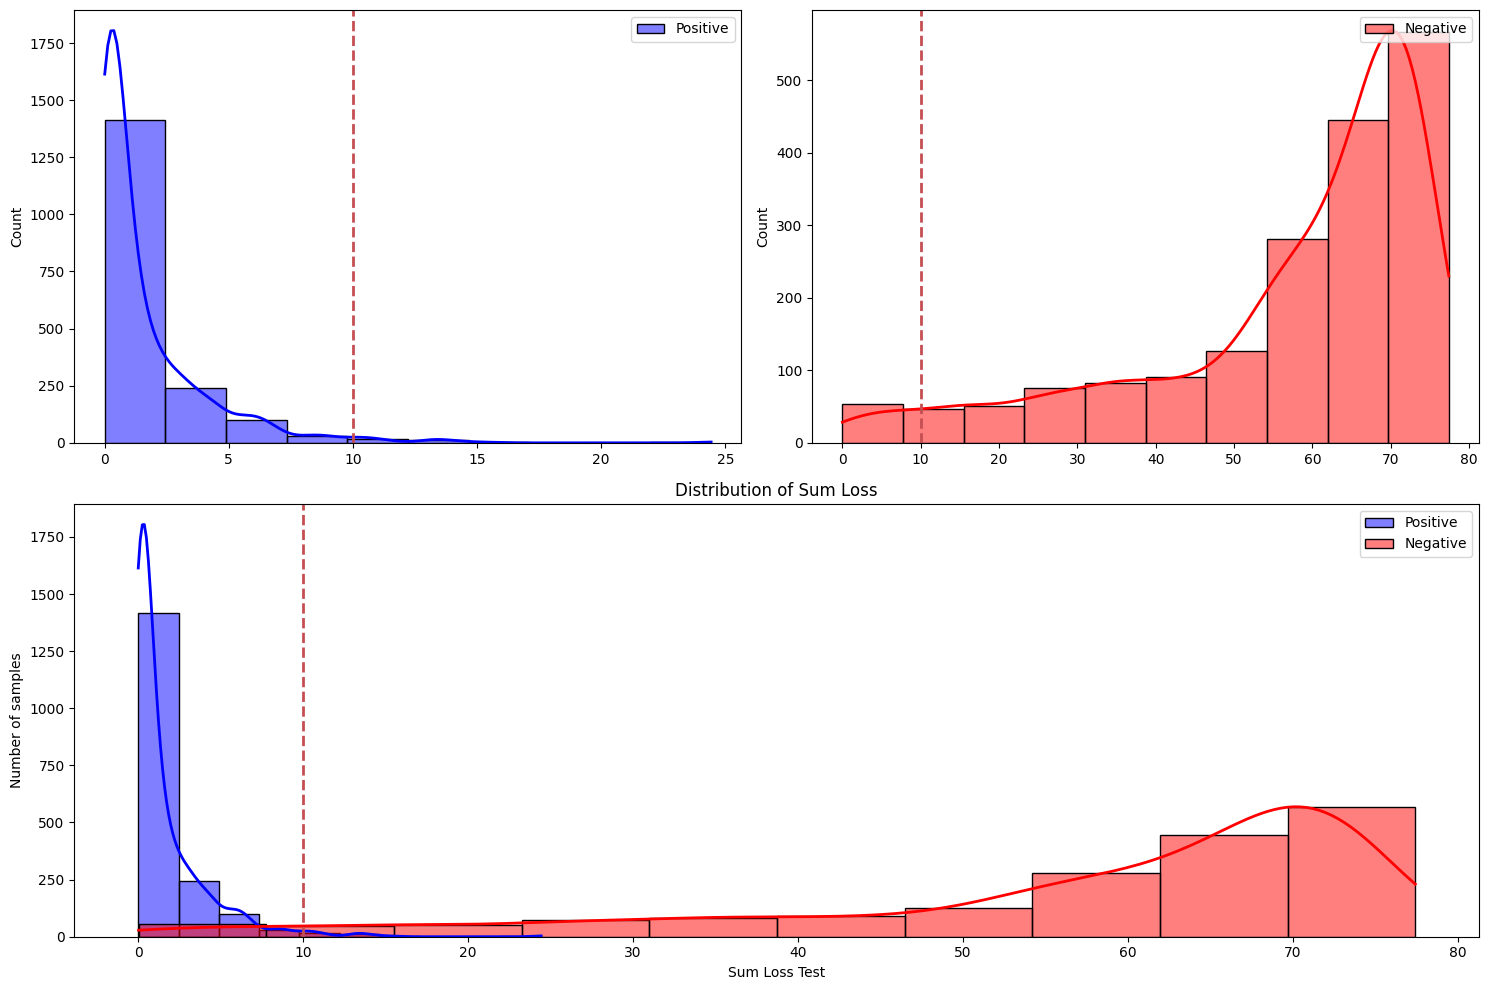

In [28]:
pos_loss, neg_loss = sumloss_visualize(test_triplets, type_name='Test', threshold=10)


In [29]:
correct_pos = sum(loss <= 10 for loss in pos_loss)
print(f'Correct positive predictions: {correct_pos}/{len(pos_loss)}')

correct_neg = sum(loss >= 10 for loss in neg_loss)
print(f'Correct negative predictions: {correct_neg}/{len(neg_loss)}')


Correct positive predictions: 1788/1819
Correct negative predictions: 1754/1819


              precision    recall  f1-score   support

         0.0       0.89      0.99      0.93      1819
         1.0       0.98      0.87      0.92      1819

    accuracy                           0.93      3638
   macro avg       0.93      0.93      0.93      3638
weighted avg       0.93      0.93      0.93      3638




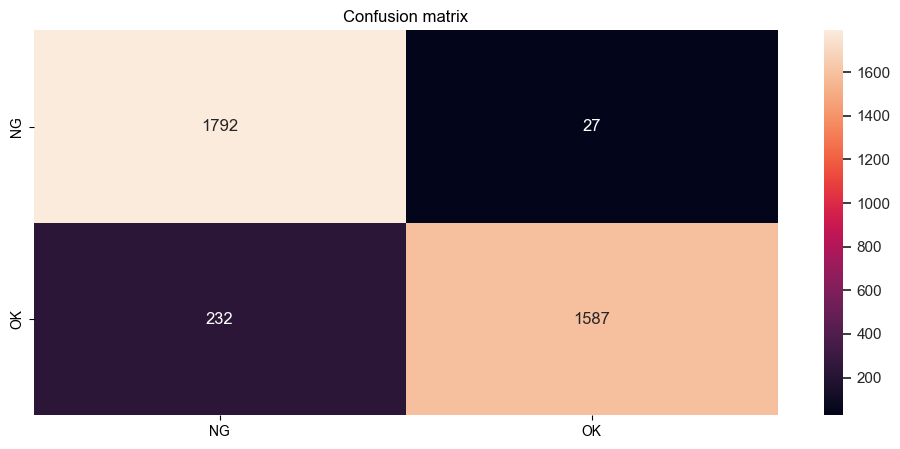

In [30]:
class_label = {0: "NG", 1: "OK"}
pred = np.array([1 if loss <= 4 else 0 for loss in pos_loss] + [0 if loss >= 4 else 1 for loss in neg_loss])
true = np.concatenate((np.ones(len(pos_loss)), np.zeros(len(neg_loss))))
plt.figure(figsize=(12, 5))
cf_matrix3 = confusion_matrix(true, pred)
plt.title("Confusion matrix")
sns.set(rc={'figure.figsize': (12, 6)})
sns.heatmap(cf_matrix3, annot=True, fmt="d",
            xticklabels={0: 'NG', 1: 'OK'}.values(),
            yticklabels={0: 'NG', 1: 'OK'}.values())

print(classification_report(true, pred))
print()
plt.show()


In [49]:
anchor_image = load_and_preprocess_audio(r'DATASET-16-4-2024-clean\TEST\NG\Recorded_NG_MERGE_15-4-2024 (28).wav')
positive_image = load_and_preprocess_audio(r'DATASET-16-4-2024-clean\TEST\OK\Recorded_OK_00-02-40-573883.wav')
negative_image = load_and_preprocess_audio(r'DATASET-16-4-2024-clean\TEST\NG\RECORDED_TRAIN_NG_v12_188.wav')

sample = next(batch_generator([[r'DATASET-16-4-2024-clean\TEST\NG\Recorded_NG_MERGE_15-4-2024 (28).wav', 
                                r'DATASET-16-4-2024-clean\TEST\OK\Recorded_OK_00-02-40-573883.wav',
                                r'DATASET-16-4-2024-clean\TEST\NG\RECORDED_TRAIN_NG_v12_188.wav']], 1))
# anchor_embedding, positive_embedding, negative_embedding = embedding([anchor_image, positive_image, negative_image])
dis_pos, dis_neg = siamese_model(sample)
print(f"Distance by model:\nPositive: {dis_pos[0]}, Negative: {dis_neg[0]}")


Distance by model:
Positive: 45.64638137817383, Negative: 3.4086337089538574
